In [1]:
!pip install allensdk
!pip install scipy==1.7.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)

import allensdk
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import pprint

import pkg_resources

# Confirming your allensdk version
print('allensdk version {} installed'.format(pkg_resources.get_distribution("allensdk").version))

allensdk version 2.13.6 installed


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
c_vals = ['firebrick', 'darkgreen', 'blue', 'darkorange', 'm', 'deeppink', 'r', 'gray', 'g', 'navy', 
                'y', 'purple', 'cyan', 'olive', 'skyblue', 'pink', 'tan']
c_vals_l = ['salmon', 'limegreen', 'cornflowerblue', 'bisque', 'plum', 'pink', 'tomato', 'lightgray', 'g', 'b', 
                      'y', 'purple', 'cyan', 'olive', 'skyblue', 'pink', 'tan']

In [4]:
# This class uses a 'manifest' to keep track of downloaded data and metadata.  
# All downloaded files will be stored relative to the directory holding the manifest
# file.  If 'manifest_file' is a relative path (as it is below), it will be 
# saved relative to your working directory.  It can also be an absolute path.
boc = BrainObservatoryCache()

# Download a list of all targeted areas
targeted_structures = boc.get_all_targeted_structures()
print("all targeted structures: " + str(targeted_structures))

# Download a list of all stimuli
stims = boc.get_all_stimuli()
print("all stimuli:\n")
pprint.pprint(stims)

cre_lines = boc.get_all_cre_lines()
print("all cre lines:\n")
pprint.pprint(cre_lines)

all targeted structures: ['VISal', 'VISam', 'VISl', 'VISp', 'VISpm', 'VISrl']
all stimuli:

['drifting_gratings',
 'locally_sparse_noise',
 'locally_sparse_noise_4deg',
 'locally_sparse_noise_8deg',
 'natural_movie_one',
 'natural_movie_three',
 'natural_movie_two',
 'natural_scenes',
 'spontaneous',
 'static_gratings']
all cre lines:

['Cux2-CreERT2',
 'Emx1-IRES-Cre',
 'Fezf2-CreER',
 'Nr5a1-Cre',
 'Ntsr1-Cre_GN220',
 'Pvalb-IRES-Cre',
 'Rbp4-Cre_KL100',
 'Rorb-IRES2-Cre',
 'Scnn1a-Tg3-Cre',
 'Slc17a7-IRES2-Cre',
 'Sst-IRES-Cre',
 'Tlx3-Cre_PL56',
 'Vip-IRES-Cre']


### Load in Experiments

In [5]:
# Cre lines:
# Inhibitory: Pvalb-IRES-Cre; Ai162, Sst-IRES-Cre; Ai148, Vip-IRES-Cre; Ai148

cre_lines = [
    # 'Cux2-CreERT2', # This one seems to have a lot of outliers
    'Emx1-IRES-Cre',
    'Fezf2-CreER',
    'Nr5a1-Cre',
    'Ntsr1-Cre_GN220',
    'Rbp4-Cre_KL100',
    'Rorb-IRES2-Cre',
    'Scnn1a-Tg3-Cre',
    'Slc17a7-IRES2-Cre',
    'Tlx3-Cre_PL56',
    ]

# cre_lines = ['Cux2-CreERT2',
#     'Emx1-IRES-Cre',
#     'Slc17a7-IRES2-Cre',
#     ]

# Download experiment containers for Cux2 experiments targetting VISp
# ecs = boc.get_experiment_containers(cre_lines=['Cux2-CreERT2'], targeted_structures=['VISp'])
ecs = []
cre_lines_ecs = []

for cre_line in cre_lines:

    print("Cre Line:", cre_line)
    ecs_cre = boc.get_experiment_containers(cre_lines=[cre_line,], targeted_structures=['VISp'])
    print("  Experiment containers:", len(ecs_cre))
    ecs.extend(ecs_cre)
    cre_lines_ecs.extend([cre_line for _ in range(len(ecs_cre))])

# print("Example experiment container record:")
# pprint.pprint(ecs[0])

print('\nTotal experiment containers:', len(ecs))

Cre Line: Emx1-IRES-Cre
  Experiment containers: 10
Cre Line: Fezf2-CreER
  Experiment containers: 4
Cre Line: Nr5a1-Cre
  Experiment containers: 8
Cre Line: Ntsr1-Cre_GN220
  Experiment containers: 6
Cre Line: Rbp4-Cre_KL100
  Experiment containers: 7
Cre Line: Rorb-IRES2-Cre
  Experiment containers: 8
Cre Line: Scnn1a-Tg3-Cre
  Experiment containers: 9
Cre Line: Slc17a7-IRES2-Cre
  Experiment containers: 60
Cre Line: Tlx3-Cre_PL56
  Experiment containers: 6

Total experiment containers: 118


In [6]:
import allensdk.brain_observatory.stimulus_info as stim_info

n_containers = len(ecs)
# n_containers = 20
exps = []
cre_lines_experiments = []

for container_idx in range(n_containers):
    # pick one of the cux2 experiment containers
    ec_id = ecs[container_idx]['id']

    # Find the experiments with the natural movie one
    exps_container = boc.get_ophys_experiments(
        experiment_container_ids=[ec_id], 
        stimuli=[stim_info.NATURAL_MOVIE_ONE])

    # All three experiments should have natural movie one
    if len(exps_container) != 3:
        print('Skipping, number of experiment container is:', len(exps_container))
        continue
    exps.extend(exps_container)
    cre_lines_experiments.extend([cre_lines_ecs[container_idx] for _ in range(3)])

print('Total Number of experiments:', len(exps))

n_containers = int(len(exps)//3.0)

print('Setting number of containers:', n_containers)

if n_containers == 1:
    print("Experiment with natural movie one:")
    pprint.pprint(exps)

Skipping, number of experiment container is: 0
Skipping, number of experiment container is: 0
Skipping, number of experiment container is: 0
Skipping, number of experiment container is: 0
Skipping, number of experiment container is: 0
Skipping, number of experiment container is: 0
Skipping, number of experiment container is: 0
Skipping, number of experiment container is: 0
Skipping, number of experiment container is: 0
Skipping, number of experiment container is: 0
Skipping, number of experiment container is: 0
Skipping, number of experiment container is: 0
Skipping, number of experiment container is: 0
Skipping, number of experiment container is: 0
Skipping, number of experiment container is: 0
Skipping, number of experiment container is: 0
Skipping, number of experiment container is: 0
Skipping, number of experiment container is: 0
Skipping, number of experiment container is: 0
Skipping, number of experiment container is: 0
Skipping, number of experiment container is: 0
Skipping, num

Details about a given experiment

In [ ]:
exp = exps[0]

data_set = boc.get_ophys_experiment_data(exp['id'])

# print out the metadata available in the NWB file
pprint.pprint(data_set.get_metadata())

2021-10-15 20:40:50,499 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/527311221


{'age_days': 144,
 'cre_line': 'Emx1-IRES-Cre/wt',
 'device': 'Nikon A1R-MP multiphoton microscope',
 'device_name': 'CAM2P.1',
 'excitation_lambda': '910 nanometers',
 'experiment_container_id': 517328083,
 'fov': '400x400 microns (512 x 512 pixels)',
 'genotype': 'Emx1-IRES-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/Ai93(TITL-GCaMP6f)',
 'imaging_depth_um': 175,
 'indicator': 'GCaMP6f',
 'ophys_experiment_id': 526928092,
 'pipeline_version': '3.0',
 'session_start_time': datetime.datetime(2016, 6, 30, 11, 25, 55),
 'session_type': 'three_session_B',
 'sex': 'male',
 'specimen_name': 'Emx1-IRES-Cre;Camk2a-tTA;Ai93-237706',
 'targeted_structure': 'VISp'}


In [ ]:
time, dff_traces = data_set.get_dff_traces()
movie = data_set.get_stimulus_template('natural_movie_one')
stim_table = data_set.get_stimulus_table('natural_movie_one')

# frame_range = [ 100, 120 ]
# stim_table = stim_table[(stim_table.frame >= frame_range[0]) & (stim_table.frame <= frame_range[1])]

NameError: ignored

In [7]:
import pickle

def save_data_summary(path, exp_id, n_divs, dff_values, cell_ids):

    save_the_file = True

    if os.path.exists(path):
        print('File already exists at:', path)
        override = input('Override? (Y/N):')
        if override == 'Y':
            save_the_file = True
        else:
            save_the_file = False

    if save_the_file:
        with open(path, 'wb') as save_file:
            pickle.dump(dff_values, save_file, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump(cell_ids, save_file, protocol=pickle.HIGHEST_PROTOCOL)
        print('Data Saved')
    else:
        print('Data Not Saved')

def load_data_summary(root_path, exp_id, n_divs):

    save_string = get_save_string_summary(exp_id, n_divs)
    path = root_path + save_string + '.pickle'

    if not os.path.exists(path):
        raise ValueError('No file at path:', path)
    else:
        with open(path, 'rb') as load_file:
            dff_values_load = pickle.load(load_file)
            cell_ids_load = pickle.load(load_file)
 
        return dff_values_load, cell_ids_load

def get_save_string_summary(exp_id, n_divs):
    """ Returns a unique string identifier for the data """
    return ('naturalmovieone_ndivs' + str(n_divs) + '_expid' + str(exp_id))

def get_align_angle(x, y):
    dot = np.dot(x,y)/(
         np.linalg.norm(x) * np.linalg.norm(y)
     )
    if dot > 1.0:
         dot = 1.0
    elif dot < -1.0:
        dot = -1.0
    
    return 180/np.pi * np.arccos(dot)


In [8]:
def get_dff_vals_dataset(data_set, n_divs = 30):

    if n_frames % n_divs > 0:
        raise ValueError('Number of frames does not divide evenly.')
    frames_per_repeat = int(n_frames/n_divs)

    time, dff_traces = data_set.get_dff_traces()
    cell_ids = data_set.get_cell_specimen_ids()
    stim_table = data_set.get_stimulus_table('natural_movie_one')

    n_cells = len(cell_ids)

    frame_idxs = np.zeros((n_repeats, n_divs, int(n_frames/n_divs)))
    dff_vals = np.zeros((n_repeats, n_divs, n_cells))

    for repeat_idx in range(n_repeats):
        repeat_frames = np.array(stim_table.query('repeat == @repeat_idx')['start'])
        for div_idx in range(n_divs):
            div_repeat_idxs = repeat_frames[
                div_idx*frames_per_repeat:(div_idx+1)*frames_per_repeat
            ]
            
            frame_idxs[repeat_idx, div_idx] = div_repeat_idxs
            dff_vals[repeat_idx, div_idx] = np.mean(dff_traces[:, div_repeat_idxs],
                                                    axis=1)

    return dff_vals, cell_ids

dff_vals_experiments = []
cell_ids_experiments = []
data_sets_experiments = []

n_frames = 900
n_repeats = 10
n_divs = 30

root_path = '/content/drive/MyDrive/neuro_research/visual_change_drift/summary_data/'
save_summary_data = False
load_summary_data = True

for exp in exps:

    if load_summary_data:
        save_string = get_save_string_summary(exp['id'], n_divs)
        path = root_path + save_string + '.pickle'
        
        if os.path.exists(path):
            print('Loading from path:', path)
            
            dff_values_load, cell_ids_load = load_data_summary(root_path, exp['id'], n_divs)
            
            dff_vals_experiments.append(dff_values_load)
            cell_ids_experiments.append(cell_ids_load)
            
            continue # Skips rest of loop since data doesn't need to be recalculated
        else:
            print('Loaded data not found at: ', path)

    data_set = boc.get_ophys_experiment_data(exp['id'])
    data_sets_experiments.append(data_set)

    dff_vals, cell_ids = get_dff_vals_dataset(data_set, n_divs=n_divs)

    dff_vals_experiments.append(dff_vals)
    cell_ids_experiments.append(cell_ids)

    if save_summary_data: 
        save_string = get_save_string_summary(exp['id'], n_divs)
        path = root_path + save_string + '.pickle'

        print('   Saving to path:', path)
        save_data_summary(path, exp['id'], n_divs, dff_vals, cell_ids)


Loading from path: /content/drive/MyDrive/neuro_research/visual_change_drift/summary_data/naturalmovieone_ndivs30_expid526928092.pickle
Loading from path: /content/drive/MyDrive/neuro_research/visual_change_drift/summary_data/naturalmovieone_ndivs30_expid526504941.pickle
Loading from path: /content/drive/MyDrive/neuro_research/visual_change_drift/summary_data/naturalmovieone_ndivs30_expid527583578.pickle
Loading from path: /content/drive/MyDrive/neuro_research/visual_change_drift/summary_data/naturalmovieone_ndivs30_expid540684467.pickle
Loading from path: /content/drive/MyDrive/neuro_research/visual_change_drift/summary_data/naturalmovieone_ndivs30_expid541048140.pickle
Loading from path: /content/drive/MyDrive/neuro_research/visual_change_drift/summary_data/naturalmovieone_ndivs30_expid539515366.pickle
Loading from path: /content/drive/MyDrive/neuro_research/visual_change_drift/summary_data/naturalmovieone_ndivs30_expid540168837.pickle
Loading from path: /content/drive/MyDrive/neuro_

### Correlations/plots within a single session

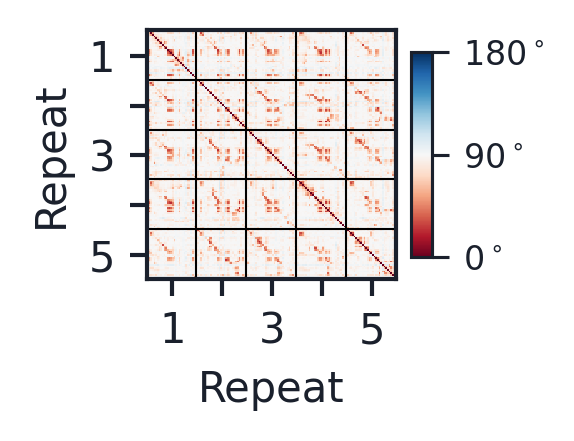

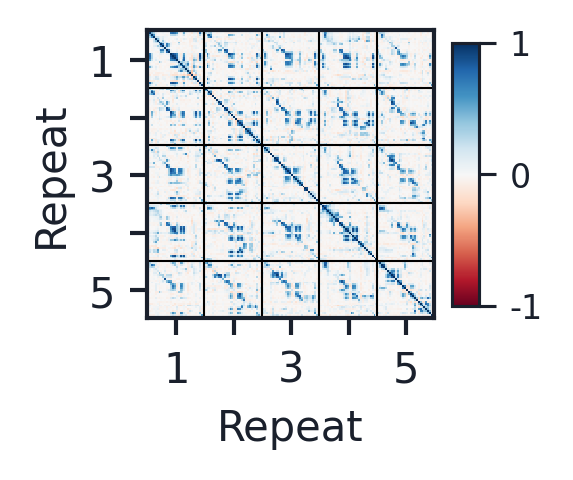

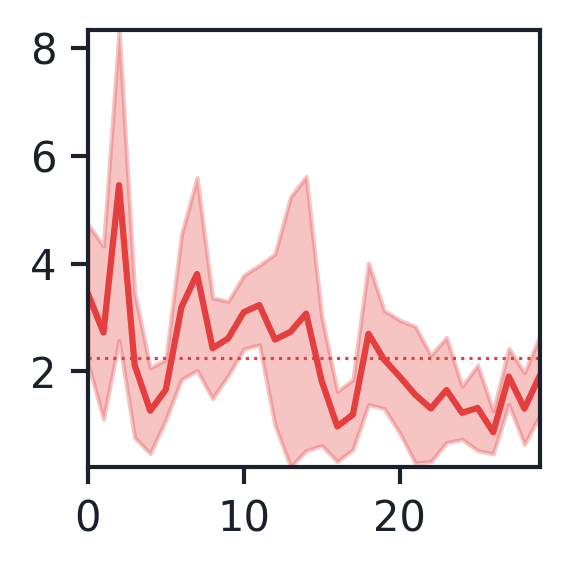

In [ ]:
exp_idx = 5 #21, 30
n_repeat_plot = 5

dff_vals = dff_vals_experiments[exp_idx]
n_cells = dff_vals.shape[-1]
within_session_corrs = np.zeros((n_repeats*n_divs, n_repeats*n_divs))
within_session_angles = np.zeros((n_repeats*n_divs, n_repeats*n_divs))

for repeat_idx1 in range(n_repeats):
    for repeat_idx2 in range(n_repeats):
        within_session_corrs[
            repeat_idx1 * n_divs:(repeat_idx1+1) * n_divs, 
            repeat_idx2 * n_divs:(repeat_idx2+1) * n_divs] = np.corrcoef(
                dff_vals[repeat_idx1], dff_vals[repeat_idx2])[n_divs:, :n_divs]
        for div_idx1 in range(n_divs):
            for div_idx2 in range(n_divs):
                within_session_angles[
                    repeat_idx1 * n_divs + div_idx1, 
                    repeat_idx2 * n_divs + div_idx2] = get_align_angle(
                        dff_vals[repeat_idx1, div_idx1], 
                        dff_vals[repeat_idx2, div_idx2]
                    )


fig, ax = plt.subplots(1, 1, figsize=(2,2))

# c_plot = ax.imshow(within_session_corrs, cmap='RdBu', vmin=-1, vmax=1)
c_plot = ax.imshow(within_session_angles[:n_repeat_plot*n_divs, :n_repeat_plot*n_divs]
                   , cmap='RdBu', vmin=0, vmax=180)
cbar = plt.colorbar(c_plot, ax=ax, shrink=0.45, ticks=[0, 90, 180], aspect=10)
cbar.ax.set_yticklabels(['0$^\circ$', '90$^\circ$', '180$^\circ$'])
cbar.ax.tick_params(labelsize=8, width=0.75) 
cbar.outline.set_linewidth(0.75)

# tick_locs = [n_divs/2 + i * n_divs for i in range(n_repeat_plot)]
# ax.set_xticks(tick_locs)
# ax.set_yticks(tick_locs)
# tick_labels = [i+1 for i in range(n_repeat_plot)]
# ax.set_xticklabels(tick_labels)
# ax.set_yticklabels(tick_labels)
tick_locs = [n_divs/2 + i * n_divs for i in range(n_repeat_plot)]
ax.set_xticks(tick_locs)
ax.set_yticks(tick_locs)
tick_labels = [1, None, 3, None, 5]
ax.set_xticklabels(tick_labels)
ax.set_yticklabels(tick_labels)
ax.set_xlabel('Repeat')
ax.set_ylabel('Repeat')

for repeat_idx in range(1, n_repeat_plot):
    ax.axhline((repeat_idx * n_divs)-0.5, color='k', linewidth=0.5)
    ax.axvline((repeat_idx * n_divs)-0.5, color='k', linewidth=0.5)


fig, ax = plt.subplots(1, 1, figsize=(2,2))

# c_plot = ax.imshow(within_session_corrs, cmap='RdBu', vmin=-1, vmax=1)
c_plot = ax.imshow(within_session_corrs[:n_repeat_plot*n_divs, :n_repeat_plot*n_divs]
                   , cmap='RdBu', vmin=-1, vmax=1)
cbar = plt.colorbar(c_plot, ax=ax, shrink=0.6, ticks=[-1, 0, 1], aspect=10)
cbar.ax.set_yticklabels([-1, 0, 1])
cbar.ax.tick_params(labelsize=8, width=0.75) 
cbar.outline.set_linewidth(0.75)

# tick_locs = [n_divs/2 + i * n_divs for i in range(n_repeat_plot)]
# ax.set_xticks(tick_locs)
# ax.set_yticks(tick_locs)
# tick_labels = [i+1 for i in range(n_repeat_plot)]
# ax.set_xticklabels(tick_labels)
# ax.set_yticklabels(tick_labels)
tick_locs = [n_divs/2 + i * n_divs for i in range(n_repeat_plot)]
ax.set_xticks(tick_locs)
ax.set_yticks(tick_locs)
tick_labels = [1, None, 3, None, 5]
ax.set_xticklabels(tick_labels)
ax.set_yticklabels(tick_labels)
ax.set_xlabel('Repeat')
ax.set_ylabel('Repeat')

for repeat_idx in range(1, n_repeat_plot):
    ax.axhline((repeat_idx * n_divs)-0.5, color='k', linewidth=0.5)
    ax.axvline((repeat_idx * n_divs)-0.5, color='k', linewidth=0.5)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

fig, ax = plt.subplots(1, 1, figsize=(2,2))

# dff_vals_flat = dff_vals[:n_repeat_plot, :, :].reshape(n_repeat_plot*n_divs, n_cells)

mean_mag = np.mean(np.linalg.norm(dff_vals, axis=-1), axis=0)
std_mag = np.std(np.linalg.norm(dff_vals, axis=-1), axis=0)

ax.fill_between(np.arange(n_divs), mean_mag-std_mag,
                mean_mag+std_mag, color=c_vals[0], alpha=0.3)
ax.plot(np.arange(n_divs), mean_mag, color=c_vals[0])
ax.axhline(np.mean(mean_mag), color=c_vals[0], linewidth=0.75,
            linestyle='dotted')

# for repeat_idx in range(n_repeat_plot):
    # ax.plot(np.arange(n_divs),
    #         np.linalg.norm(dff_vals[repeat_idx], axis=-1))

Average over many sessions

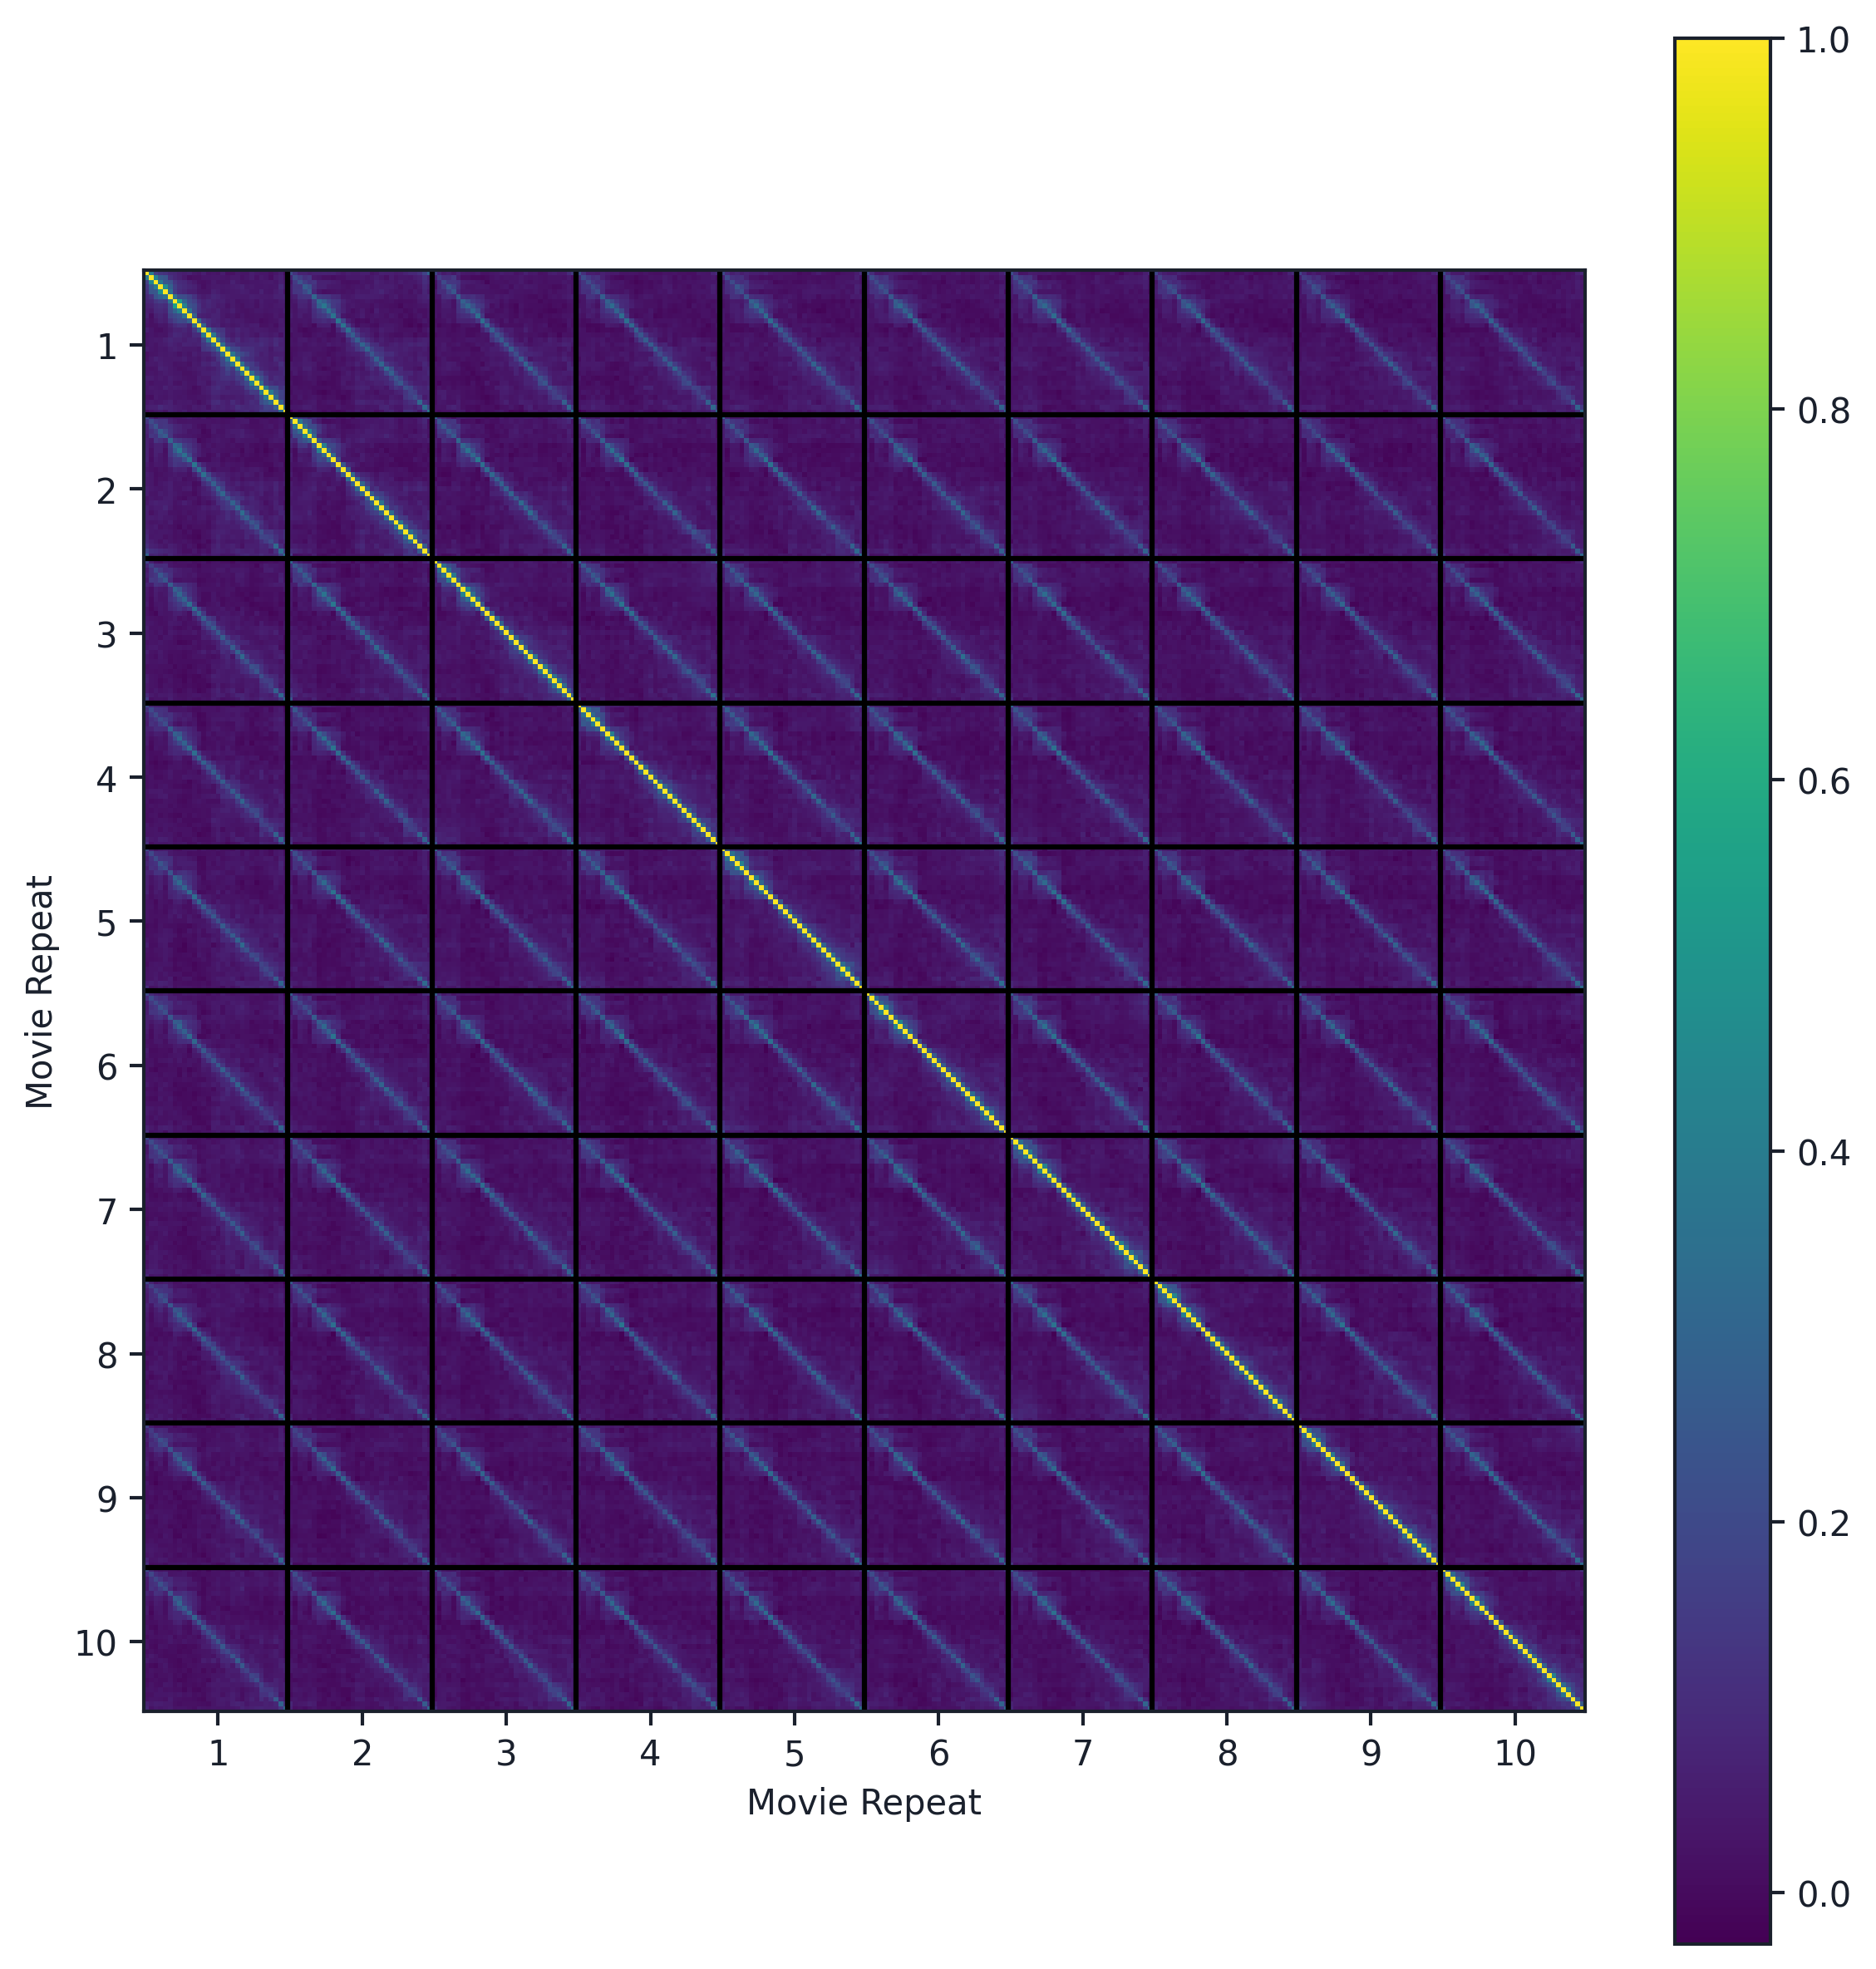

In [ ]:
within_session_corrs = np.zeros((len(exps), n_repeats*n_divs, n_repeats*n_divs))

for exp_idx in range(len(exps)):
    dff_vals = dff_vals_experiments[exp_idx]

    for repeat_idx1 in range(n_repeats):
        for repeat_idx2 in range(n_repeats):
            within_session_corrs[exp_idx,
                repeat_idx1 * n_divs:(repeat_idx1+1) * n_divs, 
                repeat_idx2 * n_divs:(repeat_idx2+1) * n_divs] = np.corrcoef(
                    dff_vals[repeat_idx1], dff_vals[repeat_idx2])[n_divs:, :n_divs]


avg_within_session_corrs = np.mean(within_session_corrs, axis=0)

fig, ax = plt.subplots(1, 1, figsize=(8,8))

c_plot = ax.imshow(avg_within_session_corrs, cmap='viridis')
plt.colorbar(c_plot, ax=ax)

tick_locs = [n_divs/2 + i * n_divs for i in range(n_repeats)]
ax.set_xticks(tick_locs)
ax.set_yticks(tick_locs)
tick_labels = [i+1 for i in range(n_repeats)]
ax.set_xticklabels(tick_labels)
ax.set_yticklabels(tick_labels)
ax.set_xlabel('Movie Repeat')
ax.set_ylabel('Movie Repeat')

for repeat_idx in range(1, n_repeats):
    ax.axhline((repeat_idx * n_divs)-0.5, color='k')
    ax.axvline((repeat_idx * n_divs)-0.5, color='k')

This averages the angle and corrleation plots across all mice and sessions. Reviewer 1 wanted to see this.

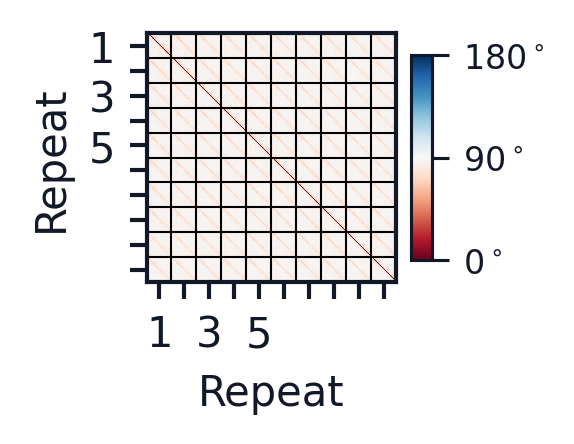

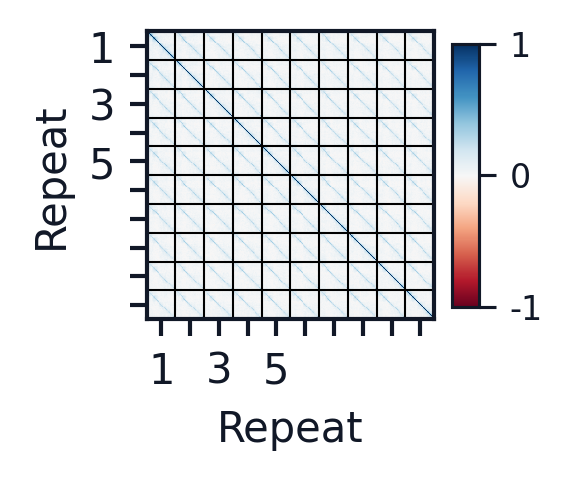

In [23]:
n_repeat_plot = 10

corrs_exp = np.zeros((len(dff_vals_experiments), n_repeats*n_divs, n_repeats*n_divs))
angles_exp = np.zeros((len(dff_vals_experiments), n_repeats*n_divs, n_repeats*n_divs))

for exp_idx in range(len(dff_vals_experiments)):

    dff_vals = dff_vals_experiments[exp_idx]
    n_cells = dff_vals.shape[-1]
    within_session_corrs = np.zeros((n_repeats*n_divs, n_repeats*n_divs))
    within_session_angles = np.zeros((n_repeats*n_divs, n_repeats*n_divs))

    for repeat_idx1 in range(n_repeats):
        for repeat_idx2 in range(n_repeats):
            within_session_corrs[
                repeat_idx1 * n_divs:(repeat_idx1+1) * n_divs, 
                repeat_idx2 * n_divs:(repeat_idx2+1) * n_divs] = np.corrcoef(
                    dff_vals[repeat_idx1], dff_vals[repeat_idx2])[n_divs:, :n_divs]
            for div_idx1 in range(n_divs):
                for div_idx2 in range(n_divs):
                    within_session_angles[
                        repeat_idx1 * n_divs + div_idx1, 
                        repeat_idx2 * n_divs + div_idx2] = get_align_angle(
                            dff_vals[repeat_idx1, div_idx1], 
                            dff_vals[repeat_idx2, div_idx2]
                        )
    corrs_exp[exp_idx] = within_session_corrs
    angles_exp[exp_idx] = within_session_angles

mean_corrs = np.mean(corrs_exp, axis=0)
mean_angles = np.mean(angles_exp, axis=0)

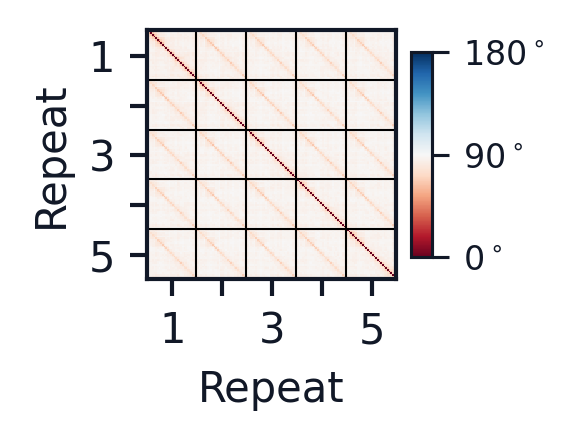

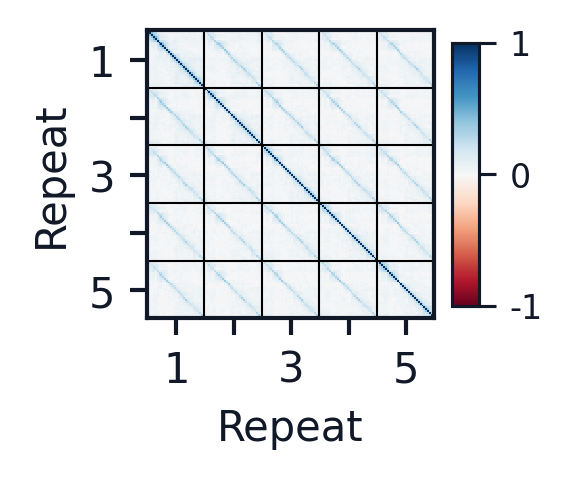

In [25]:
n_repeat_plot = 5

fig, ax = plt.subplots(1, 1, figsize=(2,2))

# c_plot = ax.imshow(within_session_corrs, cmap='RdBu', vmin=-1, vmax=1)
c_plot = ax.imshow(mean_angles[:n_repeat_plot*n_divs, :n_repeat_plot*n_divs]
                , cmap='RdBu', vmin=0, vmax=180)
cbar = plt.colorbar(c_plot, ax=ax, shrink=0.45, ticks=[0, 90, 180], aspect=10)
cbar.ax.set_yticklabels(['0$^\circ$', '90$^\circ$', '180$^\circ$'])
cbar.ax.tick_params(labelsize=8, width=0.75) 
cbar.outline.set_linewidth(0.75)

# tick_locs = [n_divs/2 + i * n_divs for i in range(n_repeat_plot)]
# ax.set_xticks(tick_locs)
# ax.set_yticks(tick_locs)
# tick_labels = [i+1 for i in range(n_repeat_plot)]
# ax.set_xticklabels(tick_labels)
# ax.set_yticklabels(tick_labels)
tick_locs = [n_divs/2 + i * n_divs for i in range(n_repeat_plot)]
ax.set_xticks(tick_locs)
ax.set_yticks(tick_locs)
if n_repeat_plot == 10:
    tick_labels = [1, None, None, None, None, None, None, None, None, 10]
else:
    tick_labels = [1, None, 3, None, 5]
ax.set_xticklabels(tick_labels)
ax.set_yticklabels(tick_labels)
ax.set_xlabel('Repeat')
ax.set_ylabel('Repeat')

for repeat_idx in range(1, n_repeat_plot):
    ax.axhline((repeat_idx * n_divs)-0.5, color='k', linewidth=0.5)
    ax.axvline((repeat_idx * n_divs)-0.5, color='k', linewidth=0.5)


fig, ax = plt.subplots(1, 1, figsize=(2,2))

# c_plot = ax.imshow(within_session_corrs, cmap='RdBu', vmin=-1, vmax=1)
c_plot = ax.imshow(mean_corrs[:n_repeat_plot*n_divs, :n_repeat_plot*n_divs]
                , cmap='RdBu', vmin=-1, vmax=1)
cbar = plt.colorbar(c_plot, ax=ax, shrink=0.6, ticks=[-1, 0, 1], aspect=10)
cbar.ax.set_yticklabels([-1, 0, 1])
cbar.ax.tick_params(labelsize=8, width=0.75) 
cbar.outline.set_linewidth(0.75)

# tick_locs = [n_divs/2 + i * n_divs for i in range(n_repeat_plot)]
# ax.set_xticks(tick_locs)
# ax.set_yticks(tick_locs)
# tick_labels = [i+1 for i in range(n_repeat_plot)]
# ax.set_xticklabels(tick_labels)
# ax.set_yticklabels(tick_labels)
tick_locs = [n_divs/2 + i * n_divs for i in range(n_repeat_plot)]
ax.set_xticks(tick_locs)
ax.set_yticks(tick_locs)
ax.set_xticklabels(tick_labels)
ax.set_yticklabels(tick_labels)
ax.set_xlabel('Repeat')
ax.set_ylabel('Repeat')

for repeat_idx in range(1, n_repeat_plot):
    ax.axhline((repeat_idx * n_divs)-0.5, color='k', linewidth=0.5)
    ax.axvline((repeat_idx * n_divs)-0.5, color='k', linewidth=0.5)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

Reviewer 1 also wants to know what drift looks like within a single session, so here it is

In [42]:
align_vals_repeats = [[] for _ in range(n_repeats-1)]
corr_vals_repeats = [[] for _ in range(n_repeats-1)]
n_classes = dff_vals_container[0].shape[1]

for container_idx in range(n_containers):

    cell_ids_container = cell_ids_experiments[container_idx*n_sessions:(container_idx+1)*n_sessions]
    dff_vals_container = dff_vals_experiments[container_idx*n_sessions:(container_idx+1)*n_sessions]

    # Find shared IDs
    unique_cell_ids = get_unique_cell_ids(cell_ids_container)
    shared_cell_idxs = get_shared_cell_idxs(unique_cell_ids, verbose=False)
    n_shared = shared_cell_idxs[0].shape[0]

    n_pcas = np.min((n_repeats, n_shared))

    for session_idx in range(n_sessions):
        dff_vals_session = dff_vals_container[session_idx][:, :, shared_cell_idxs[session_idx]]

        for class_idx in range(n_classes):

            for repeat_idx1 in range(n_repeats):
                for repeat_idx2 in range(repeat_idx1+1, n_repeats):

                    align = get_align_angle(dff_vals_session[repeat_idx2, class_idx],
                                            dff_vals_session[repeat_idx1, class_idx])
                    
                    align_vals_repeats[repeat_idx2-repeat_idx1-1].append(align)

                    corr = np.corrcoef(dff_vals_session[repeat_idx2, class_idx],
                                       dff_vals_session[repeat_idx1, class_idx])[0, 1]

                    corr_vals_repeats[repeat_idx2-repeat_idx1-1].append(corr)    

In [45]:
fit_X = [(i+1)*np.ones_like(align_vals_repeats[i]) for i in range(n_repeats-1)]
fit_X = np.concatenate(fit_X)

# fit_y = np.concatenate(align_vals_repeats)
# plot_color = c_vals[0]

fit_y = np.concatenate(corr_vals_repeats)
plot_color = c_vals[1]


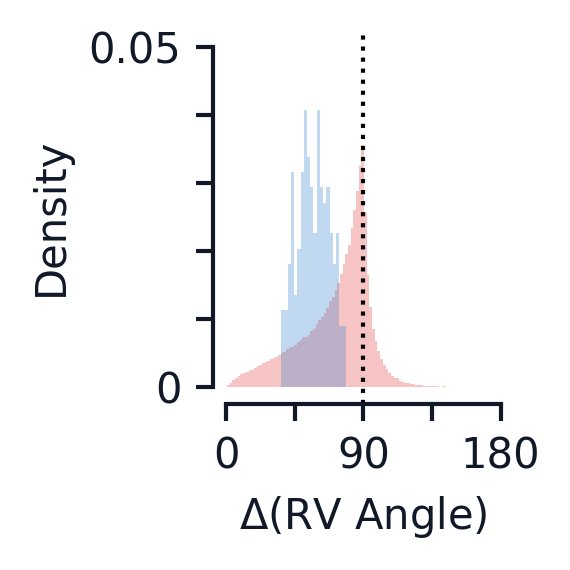

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(2,2))

ax.hist(np.concatenate(align_vals_repeats), bins=100, alpha=0.3, density=True,
        color=c_vals[0])

ax.hist(drift_angles.flatten()[delta_t_filter], bins=20, alpha=0.3, density=True,
        color=c_vals[1])

ax.axvline(90.0, color='k', linestyle='dotted', linewidth=1.0)

ax.set_ylabel('Density')
ax.set_xlabel('$\Delta$(RV Angle)')

ax.set_xlim((0, 180))
ax.set_xticks((0, 45, 90, 135, 180))
ax.set_xticklabels((0, None, 90, None, 180))

ax.set_ylim((0, 0.05))
ax.set_yticks((0, 0.01, 0.02, 0.03, 0.04, 0.05))
ax.set_yticklabels((0, None,  None,  None,  None, 0.05))

jetplot.breathe(ax=ax)

Slope: -0.01 (se: 0.00), r: -0.04 p: 3.11e-92


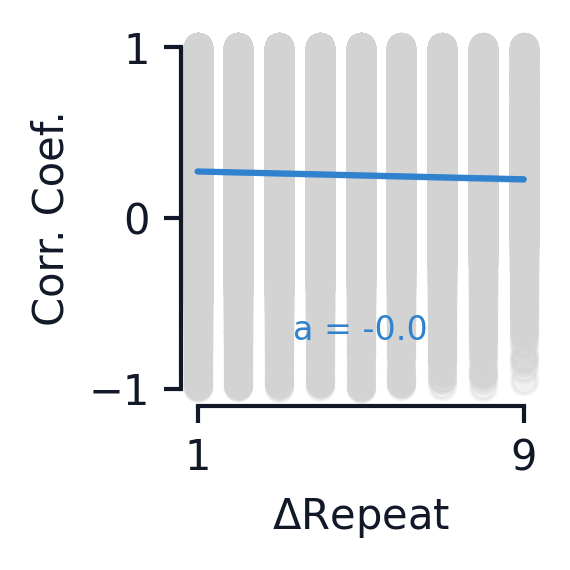

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(2,2))

reg = linregress(fit_X, fit_y)
print('Slope: {:.2f} (se: {:.2f}), r: {:.2f} p: {:.2e}'.format(
      reg.slope, reg.stderr, reg.rvalue, reg.pvalue))
reg_plot_X = np.linspace(np.min(fit_X), np.max(fit_X), num=50)
reg_plot_y = reg.slope * reg_plot_X + reg.intercept
reg_plot_min_y = ((reg.slope - n_se* reg.stderr) * reg_plot_X + 
                  (reg.intercept - n_se * reg.intercept_stderr))
reg_plot_max_y = ((reg.slope + n_se * reg.stderr) * reg_plot_X + 
                  (reg.intercept + n_se * reg.intercept_stderr))

# for interval_idx in range(n_repeats-1):
#     ax.scatter(interval_idx+1, np.mean(align_vals_repeats[interval_idx]), color=c_vals[1], zorder=5)

ax.scatter(fit_X, fit_y, color='lightgrey', alpha=0.3)

ax.fill_between(reg_plot_X, reg_plot_min_y, reg_plot_max_y, 
                    color=c_vals[0], alpha=0.3)
ax.plot(reg_plot_X, reg_plot_y, color=c_vals[0])

ax.text(0.5, 0.2, 'a = {:.1f}'.format(reg.slope), 
           horizontalalignment='center', verticalalignment='center', 
           color=plot_color, fontsize=8, transform=ax.transAxes)

ax.set_xlabel('$\Delta$Repeat')
ax.set_xlim([1, np.max(fit_X)])
ax.set_xticks([1, np.max(fit_X)])

# ax.set_ylabel('$\Delta$(RV Angle)')
# ax.set_ylim([0, 180.0])
# ax.set_yticks([0, 45.0, 90.0, 135.0, 180])
# ax.set_yticklabels([0, None, 90.0, None, 180])

ax.set_ylabel('Corr. Coef.')
ax.set_ylim([-1, 1.0])
ax.set_yticks([-1, 0 ,1])

try:
    jetplot.breathe(ax=ax)
except NameError:
    pass

### Correlations across sessions

In [9]:
def get_unique_cell_ids(cell_ids_experiment):
    """
    Finds all unique cell_ids. For each unique cell_id, creates a list of 
    corresponding indexes in datasets
    """
    unique_cell_ids = {}

    for cell_ids in cell_ids_experiment:
        for cell_idx, cell_id in enumerate(cell_ids):
            if cell_id not in unique_cell_ids.keys():
                unique_cell_ids[cell_id] = []

    # For each cell_id, finds the indexes in all experimental datasets
    # (lists index as nan if not in given dataset.
    for cell_id in unique_cell_ids.keys():
        for cell_ids in cell_ids_experiment:
            if cell_id in cell_ids:
                # unique_cell_ids[cell_id].append(cell_ids.index(cell_id))
                unique_cell_ids[cell_id].append(np.where(cell_ids == cell_id)[0][0])
            else:
                unique_cell_ids[cell_id].append(np.nan)

    return unique_cell_ids

def get_shared_cell_idxs(unique_cell_ids, verbose=True):
    """
    Finds all cell_ids shared across the datasets, and then returns a numpy 
    array which has the idx of said cell_ids in each dataset.
    """
    n_exp = len(unique_cell_ids[list(unique_cell_ids.keys())[0]])

    shared_cell_ids = []
    for cell_id in unique_cell_ids.keys():
        if np.sum(np.isnan(unique_cell_ids[cell_id])) == 0:
            shared_cell_ids.append(cell_id)

    if verbose:
        print('Shared IDs: {}/{}'.format(len(shared_cell_ids), 
                                        len(unique_cell_ids.keys())))

    # Map of shared cell_ids to cell_idxs in both datasets
    shared_cell_idxs = np.zeros((n_exp, len(shared_cell_ids)), dtype=np.int64)
    for cell_idx, cell_id in enumerate(shared_cell_ids):
        shared_cell_idxs[:, cell_idx] = unique_cell_ids[cell_id]

    return shared_cell_idxs

def get_align_angle(x, y):
    dot = np.dot(x,y)/(
         np.linalg.norm(x) * np.linalg.norm(y)
     )
    if dot > 1.0:
         dot = 1.0
    elif dot < -1.0:
        dot = -1.0
    
    return 180/np.pi * np.arccos(dot)

def participation_ratio_vector(C):
    """Computes the participation ratio of a vector of variances."""
    return np.sum(C) ** 2 / np.sum(C*C)

Sorts all sessions by age

In [10]:
# Number of sessions per container
n_sessions = 3

ages_experiments = []

for container_idx in range(n_containers):
    print('Container idx:', container_idx)
    
    exps_container = exps[container_idx*n_sessions:(container_idx+1)*n_sessions]
    cell_ids_container = cell_ids_experiments[container_idx*n_sessions:(container_idx+1)*n_sessions]
    dff_vals_container = dff_vals_experiments[container_idx*n_sessions:(container_idx+1)*n_sessions]

    session_ages = [exp['acquisition_age_days'] for exp in exps_container]
    
    print('  Ages:', session_ages)
    # Sorts experiment ids by age
    age_sort_idxs = np.argsort(session_ages)
    for session_idx in range(n_sessions):
        exps[session_idx + container_idx*n_sessions] = exps_container[age_sort_idxs[session_idx]]
        cell_ids_experiments[session_idx + container_idx*n_sessions] = cell_ids_container[age_sort_idxs[session_idx]]
        dff_vals_experiments[session_idx + container_idx*n_sessions] = dff_vals_container[age_sort_idxs[session_idx]]

    session_ages = [exp['acquisition_age_days'] for exp in exps[container_idx*n_sessions:(container_idx+1)*n_sessions]]
    print('  Sorted ages:', session_ages)

    ages_experiments.extend(session_ages)

Container idx: 0
  Ages: [143, 141, 149]
  Sorted ages: [141, 143, 149]
Container idx: 1
  Ages: [120, 121, 113]
  Sorted ages: [113, 120, 121]
Container idx: 2
  Ages: [73, 75, 74]
  Sorted ages: [73, 74, 75]
Container idx: 3
  Ages: [123, 122, 121]
  Sorted ages: [121, 122, 123]
Container idx: 4
  Ages: [86, 94, 95]
  Sorted ages: [86, 94, 95]
Container idx: 5
  Ages: [129, 130, 128]
  Sorted ages: [128, 129, 130]
Container idx: 6
  Ages: [117, 116, 112]
  Sorted ages: [112, 116, 117]
Container idx: 7
  Ages: [99, 91, 93]
  Sorted ages: [91, 93, 99]
Container idx: 8
  Ages: [100, 107, 105]
  Sorted ages: [100, 105, 107]
Container idx: 9
  Ages: [155, 156, 154]
  Sorted ages: [154, 155, 156]
Container idx: 10
  Ages: [97, 100, 93]
  Sorted ages: [93, 97, 100]
Container idx: 11
  Ages: [109, 102, 98]
  Sorted ages: [98, 102, 109]
Container idx: 12
  Ages: [90, 88, 89]
  Sorted ages: [88, 89, 90]
Container idx: 13
  Ages: [104, 97, 105]
  Sorted ages: [97, 104, 105]
Container idx: 14
  

Session to session correlation for a single container

Shared IDs: 178/388


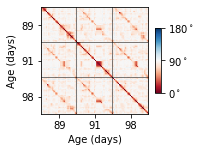

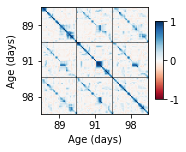

In [11]:
container_idx = 5

exps_container = exps[container_idx*n_sessions:(container_idx+1)*n_sessions]
cell_ids_container = cell_ids_experiments[container_idx*n_sessions:(container_idx+1)*n_sessions]
dff_vals_container = dff_vals_experiments[container_idx*n_sessions:(container_idx+1)*n_sessions]

unique_cell_ids = get_unique_cell_ids(cell_ids_container)
shared_cell_idxs = get_shared_cell_idxs(unique_cell_ids)

across_session_corrs = np.zeros((n_sessions*n_divs, n_sessions*n_divs))
across_session_angles = np.zeros((n_sessions*n_divs, n_sessions*n_divs))

avg_dff_vals_container = []

for session_idx in range(n_sessions):
    avg_dff_vals_container.append(np.mean(
        dff_vals_container[session_idx][:, :, shared_cell_idxs[session_idx]],
        axis = 0
    ))

for session_idx1 in range(n_sessions):
    for session_idx2 in range(n_sessions):
        across_session_corrs[
            session_idx1 * n_divs:(session_idx1+1) * n_divs, 
            session_idx2 * n_divs:(session_idx2+1) * n_divs] = np.corrcoef(
                avg_dff_vals_container[session_idx1], 
                avg_dff_vals_container[session_idx2])[n_divs:, :n_divs]
        for div_idx1 in range(n_divs):
            for div_idx2 in range(n_divs):
                across_session_angles[
                    session_idx1 * n_divs + div_idx1,
                    session_idx2 * n_divs + div_idx2] = get_align_angle(
                        avg_dff_vals_container[session_idx1][div_idx1], 
                        avg_dff_vals_container[session_idx2][div_idx2]
                    )

fig, ax = plt.subplots(1, 1, figsize=(2.4,2.4))

# c_plot = ax.imshow(across_session_corrs, cmap='RdBu', vmin=-1, vmax=1)
c_plot = ax.imshow(across_session_angles, cmap='RdBu', vmin=0, vmax=180)
cbar = plt.colorbar(c_plot, ax=ax, shrink=0.5, ticks=[0, 90, 180], aspect=10)
cbar.ax.set_yticklabels(['0$^\circ$', '90$^\circ$', '180$^\circ$'])


tick_locs = [n_divs/2 + i*n_divs for i in range(n_sessions)]
ax.set_xticks(tick_locs)
ax.set_yticks(tick_locs)
tick_labels = [str(age) for age in session_ages]
ax.set_xticklabels(tick_labels)
ax.set_yticklabels(tick_labels)

ax.set_xlabel('Age (days)')
ax.set_ylabel('Age (days)')

for session_idx in range(1, n_sessions):
    ax.axhline((session_idx * n_divs)-1, color='k', linewidth=0.5)
    ax.axvline((session_idx * n_divs)-1, color='k', linewidth=0.5)

fig, ax = plt.subplots(1, 1, figsize=(2.4,2.4))

c_plot = ax.imshow(across_session_corrs, cmap='RdBu', vmin=-1, vmax=1)
# c_plot = ax.imshow(across_session_angles, cmap='RdBu', vmin=0, vmax=180)
cbar = plt.colorbar(c_plot, ax=ax, shrink=0.6, ticks=[-1, 0, 1], aspect=10)
cbar.ax.set_yticklabels([-1, 0, 1])

tick_locs = [n_divs/2 + i*n_divs for i in range(n_sessions)]
ax.set_xticks(tick_locs)
ax.set_yticks(tick_locs)
tick_labels = [str(age) for age in session_ages]
ax.set_xticklabels(tick_labels)
ax.set_yticklabels(tick_labels)

ax.set_xlabel('Age (days)')
ax.set_ylabel('Age (days)')

for session_idx in range(1, n_sessions):
    ax.axhline((session_idx * n_divs)-1, color='k', linewidth=0.5)
    ax.axvline((session_idx * n_divs)-1, color='k', linewidth=0.5)

Some examples of feature space

0.5499697662440687
Norm: 0.8249546493661031
0.24895806831526204
Norm: 0.3734371024728931
0.6601677768563262
Norm: 0.9902516652844893
0.21851510889718656
Norm: 0.3277726633457798
0.5499697662440687
Norm: 0.8249546493661031
0.24895806831526204
Norm: 0.3734371024728931
0.4737991873386916
Norm: 0.7106987810080374
0.2841284537876946
Norm: 0.4261926806815418


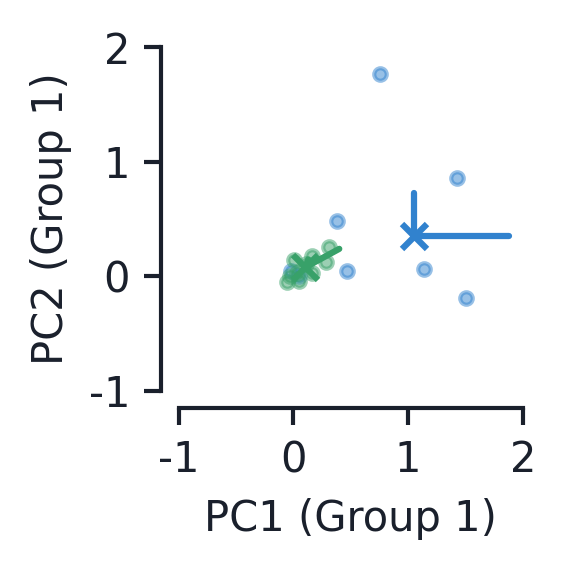

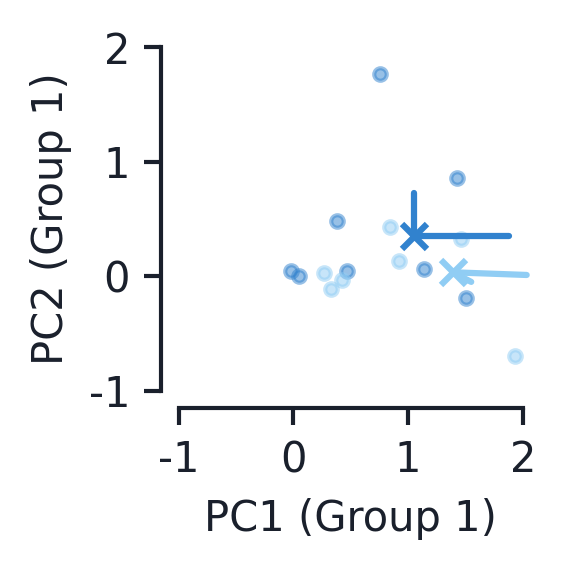

In [ ]:
from sklearn.decomposition import PCA

drift_pair_idxs = [[0, 1], [1, 2], [0, 2]]
n_drifts = len(drift_pair_idxs)

container_idx = 12 #9
drift_pair = (0, 1)
class_idxs = (0, n_divs-1)
n_classes = len(class_idxs)


exps_container = exps[container_idx*n_sessions:(container_idx+1)*n_sessions]
cell_ids_container = cell_ids_experiments[container_idx*n_sessions:(container_idx+1)*n_sessions]
dff_vals_container = dff_vals_experiments[container_idx*n_sessions:(container_idx+1)*n_sessions]

# Find shared IDs
unique_cell_ids = get_unique_cell_ids(cell_ids_container)
shared_cell_idxs = get_shared_cell_idxs(unique_cell_ids, verbose=False)
n_shared = shared_cell_idxs[0].shape[0]

n_pcas = np.min((n_repeats, n_shared))

means_session = np.zeros((n_sessions, n_divs, n_shared))
pcas_session = [[] for _ in range(n_sessions)] 

for session_idx in range(n_sessions):
    # dff_vals = np.zeros((n_repeats, n_divs, n_cells))
    dff_vals_session = dff_vals_container[session_idx][:, :, shared_cell_idxs[session_idx]]
    
    means_session[session_idx] = np.mean(dff_vals_session, axis=0)
    for div_idx in range(n_divs):
        pca_div = PCA()
        pca_div.fit(dff_vals_session[:, div_idx])
        
        # Removes ambiguity in PCA direction by making sure all means (along PC directions) are positive
        pca_dir_signs = np.sign(np.mean(np.matmul(dff_vals_session[:, div_idx], pca_div.components_.T), axis=0))
        for pca_idx, pca_dir in enumerate(pca_div.components_):
            pca_div.components_[pca_idx, :] = pca_dir_signs[pca_idx] * pca_dir        
        pcas_session[session_idx].append(pca_div)

        dim_var_space = participation_ratio_vector(
            pca_div.explained_variance_ratio_
        )


drifts_session = np.zeros((n_drifts, n_divs, n_shared))
pca_drift_magnitude = np.zeros((n_drifts, n_divs, n_pcas))

for drift_idx in range(n_drifts):
    session_idx1 = drift_pair_idxs[drift_idx][0]
    session_idx2 = drift_pair_idxs[drift_idx][1]

    drifts_session[drift_idx] = (means_session[session_idx2] - 
                    means_session[session_idx1])

    for div_idx in range(n_divs):
        # Drift in the PCA coordinates (of starting session)
        pca_drift = np.matmul( 
            pcas_session[session_idx1][div_idx].components_,
            drifts_session[drift_idx, div_idx]
        )
        for pca_idx in range(n_pcas):
            pca_drift_magnitude[drift_idx, div_idx, pca_idx] = np.abs(pca_drift[pca_idx])


fig, ax = plt.subplots(1, 1, figsize=(2,2))
pc1 = 0
pc2 = 1

dff_vals_session = dff_vals_container[drift_pair[0]][:, :, shared_cell_idxs[drift_pair[0]]]

# random_proj = np.random.uniform(low=-1.0, high=1.0, size=(2, n_shared))
# random_proj = random_proj/np.linalg.norm(random_proj, axis=-1)[:, np.newaxis] # Unit size
# # Orthogonalizes
# random_proj[1] = random_proj[1] - np.dot(random_proj[0], random_proj[1]) * random_proj[0]
# random_proj = random_proj/np.linalg.norm(random_proj, axis=-1)[:, np.newaxis] # Unit size
# # Checks mags and orthogonal:
# print('Mags:', np.linalg.norm(random_proj, axis=-1))
# print('Dot:', np.dot(random_proj[0], random_proj[1]))

class0_pca = pcas_session[drift_pair[0]][class_idxs[0]]

pca_scale = 1.5

for class_idx_idx, class_idx in enumerate(class_idxs):
    dff_vals_class = dff_vals_session[:, class_idx]
    class_pca = pcas_session[drift_pair[0]][class_idx]

    dff_vals_pca = np.matmul(dff_vals_class, class0_pca.components_.T)

    ax.scatter(dff_vals_pca[:, pc1], dff_vals_pca[:, pc2], marker='.', 
               color=c_vals[1+class_idx_idx], alpha=0.5)
    
    class_mean = np.mean(dff_vals_pca, axis=0)

    ax.scatter(class_mean[pc1], class_mean[pc2],
               marker='x', color=c_vals[1+class_idx_idx])
    
    pcas_proj =  np.matmul(class_pca.components_, class0_pca.components_.T)

    for pc_idx in (pc1, pc2):
        pcas_proj[pc_idx] = (pca_scale * class_pca.explained_variance_ratio_[pc_idx] *
                             pcas_proj[pc_idx] / np.linalg.norm(pcas_proj[pc_idx]))
        print(class_pca.explained_variance_ratio_[pc_idx])
        print('Norm:', np.linalg.norm(pcas_proj[pc_idx]))
        ax.plot([class_mean[pc1], class_mean[pc1]+pcas_proj[pc_idx, pc1]],
                [class_mean[pc2], class_mean[pc2]+pcas_proj[pc_idx, pc2]],
                color=c_vals[1+class_idx_idx])


ax.set_xlim([-1, 2])
ax.set_ylim([-1, 2])
ax.set_xticks([-1, 0, 1, 2])
ax.set_yticks([-1, 0, 1, 2])
ax.set_xticklabels([-1, 0, 1, 2])
ax.set_yticklabels([-1, 0, 1, 2])
ax.set_xlabel('PC1 (Group 1)')
ax.set_ylabel('PC2 (Group 1)')

jetplot.breathe(ax=ax)

fig, ax = plt.subplots(1, 1, figsize=(2,2))

class_idx = class_idxs[0]
colors = (c_vals[1], c_vals_l[1])
for session_idx_idx, session_idx in enumerate(drift_pair):

    dff_vals_class = dff_vals_container[session_idx][:, class_idx, shared_cell_idxs[session_idx]]
    class_pca = pcas_session[session_idx][class_idx]

    dff_vals_pca = np.matmul(dff_vals_class, class0_pca.components_.T)

    ax.scatter(dff_vals_pca[:, pc1], dff_vals_pca[:, pc2], marker='.', 
            color=colors[session_idx_idx], alpha=0.5)
    
    class_mean = np.mean(dff_vals_pca, axis=0)

    ax.scatter(class_mean[pc1], class_mean[pc2],
               marker='x', color=colors[session_idx_idx])
    
    pcas_proj =  np.matmul(class_pca.components_, class0_pca.components_.T)

    for pc_idx in (pc1, pc2):
        pcas_proj[pc_idx] = (pca_scale * class_pca.explained_variance_ratio_[pc_idx] *
                             pcas_proj[pc_idx] / np.linalg.norm(pcas_proj[pc_idx]))
        print(class_pca.explained_variance_ratio_[pc_idx])
        print('Norm:', np.linalg.norm(pcas_proj[pc_idx]))
        ax.plot([class_mean[pc1], class_mean[pc1]+pcas_proj[pc_idx, pc1]],
                [class_mean[pc2], class_mean[pc2]+pcas_proj[pc_idx, pc2]],
                color=colors[session_idx_idx])


ax.set_xlim([-1, 2])
ax.set_ylim([-1, 2])
ax.set_xticks([-1, 0, 1, 2])
ax.set_yticks([-1, 0, 1, 2])
ax.set_xticklabels([-1, 0, 1, 2])
ax.set_yticklabels([-1, 0, 1, 2])
ax.set_xlabel('PC1 (Group 1)')
ax.set_ylabel('PC2 (Group 1)')


jetplot.breathe(ax=ax)

Session to session correlation averaged over containers

Shared IDs: 83/236
Shared IDs: 135/413
Shared IDs: 96/334
Shared IDs: 93/356
Shared IDs: 124/390
Shared IDs: 178/388
Shared IDs: 61/192
Shared IDs: 78/282
Shared IDs: 74/217
Shared IDs: 123/265
Shared IDs: 60/125
Shared IDs: 32/77
Shared IDs: 52/109
Shared IDs: 33/96
Shared IDs: 36/90
Shared IDs: 13/21
Shared IDs: 56/110
Shared IDs: 27/59
Shared IDs: 27/69
Shared IDs: 44/106
Shared IDs: 24/83
Shared IDs: 11/40
Shared IDs: 49/163
Shared IDs: 24/65
Shared IDs: 12/34
Shared IDs: 34/69
Shared IDs: 81/214
Shared IDs: 6/28
Shared IDs: 20/83
Shared IDs: 10/29
Shared IDs: 13/41
Shared IDs: 7/27
Shared IDs: 29/66
Shared IDs: 41/89
Shared IDs: 31/123
Shared IDs: 164/390
Shared IDs: 116/304
Shared IDs: 97/199
Shared IDs: 110/307
Shared IDs: 59/122
Shared IDs: 80/376
Shared IDs: 103/270
Shared IDs: 87/250
Shared IDs: 63/158
Shared IDs: 69/237
Shared IDs: 42/111
Shared IDs: 84/177
Shared IDs: 128/303
Shared IDs: 29/302
Shared IDs: 62/295
Shared IDs: 30/167
Shared IDs: 24/123
Shared IDs: 52/142
Shar

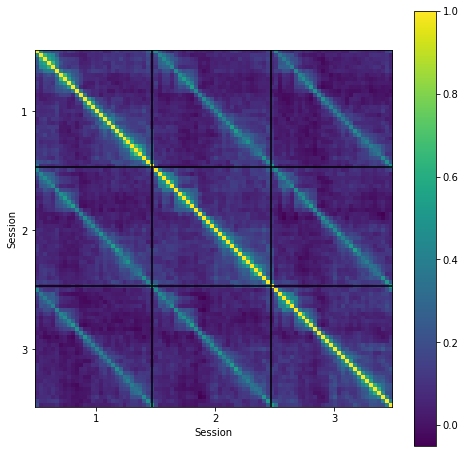

In [ ]:
across_session_corrs = np.zeros((n_containers, n_sessions*n_divs, n_sessions*n_divs))

for container_idx in range(n_containers):

    exps_container = exps[container_idx*n_sessions:(container_idx+1)*n_sessions]
    cell_ids_container = cell_ids_experiments[container_idx*n_sessions:(container_idx+1)*n_sessions]
    dff_vals_container = dff_vals_experiments[container_idx*n_sessions:(container_idx+1)*n_sessions]

    unique_cell_ids = get_unique_cell_ids(cell_ids_container)
    shared_cell_idxs = get_shared_cell_idxs(unique_cell_ids)

    avg_dff_vals_container = []

    for session_idx in range(n_sessions):
        avg_dff_vals_container.append(np.mean(
            dff_vals_container[session_idx][:, :, shared_cell_idxs[session_idx]],
            axis = 0
        ))

    for session_idx1 in range(n_sessions):
        for session_idx2 in range(n_sessions):
            across_session_corrs[container_idx,
                session_idx1 * n_divs:(session_idx1+1) * n_divs, 
                session_idx2 * n_divs:(session_idx2+1) * n_divs] = np.corrcoef(
                    avg_dff_vals_container[session_idx1], 
                    avg_dff_vals_container[session_idx2])[n_divs:, :n_divs]

fig, ax = plt.subplots(1, 1, figsize=(8,8))

avg_across_session_corrs = np.mean(across_session_corrs, axis=0)

c_plot = ax.imshow(avg_across_session_corrs, cmap='viridis')
plt.colorbar(c_plot, ax=ax)

tick_locs = [n_divs/2 + i*n_divs for i in range(n_sessions)]
ax.set_xticks(tick_locs)
ax.set_yticks(tick_locs)
tick_labels = [i+1 for i in range(3)]
ax.set_xticklabels(tick_labels)
ax.set_yticklabels(tick_labels)

ax.set_xlabel('Session')
ax.set_ylabel('Session')

for session_idx in range(1, n_sessions):
    ax.axhline((session_idx * n_divs)-1, color='k')
    ax.axvline((session_idx * n_divs)-1, color='k')

#### Drift Metrics

Filters containers based on time differences or number of samples

In [12]:
min_shared = 10

drift_pair_idxs = [[0, 1], [1, 2], [0, 2]]
n_drifts = len(drift_pair_idxs)

remove_idxs = []

print('Start containers:', n_containers)

for container_idx in range(n_containers):

    cell_ids_container = cell_ids_experiments[container_idx*n_sessions:(container_idx+1)*n_sessions]
    ages_containder = ages_experiments[container_idx*n_sessions:(container_idx+1)*n_sessions]

    # Find shared IDs
    unique_cell_ids = get_unique_cell_ids(cell_ids_container)
    shared_cell_idxs = get_shared_cell_idxs(unique_cell_ids, verbose=False)
    n_shared = shared_cell_idxs[0].shape[0]

    # Removes containers that have too few shared IDs
    if n_shared < min_shared:
        print('Container index {} only {} shared cells'.format(
            container_idx, n_shared))
        n_containers += -1
        for i in range(n_sessions):
           remove_idxs.append(container_idx*n_sessions+i)

    # Remove containders that have sessions on the same day
    for drift_idx in range(n_drifts):
        session_idx1 = drift_pair_idxs[drift_idx][0]
        session_idx2 = drift_pair_idxs[drift_idx][1]

        age_diff = ages_containder[session_idx2] - ages_containder[session_idx1]

        if age_diff < 0:
            raise ValueError('Found a negative delta t, something is wrong!')
        elif age_diff == 0:
            print('Container index {} has delta t == 0'.format(container_idx))
            n_containers += -1
            for i in range(n_sessions):
                remove_idxs.append(container_idx*n_sessions+i)

print('Filtered containers:', n_containers)

# Reverses so that it removes from the back first
remove_idxs = remove_idxs[::-1]

for remove_idx in remove_idxs:
    del exps[remove_idx]
    del cell_ids_experiments[remove_idx]
    del dff_vals_experiments[remove_idx]
    del ages_experiments[remove_idx]
    del cre_lines_experiments[remove_idx]

Start containers: 78
Container index 19 has delta t == 0
Container index 27 only 6 shared cells
Container index 31 only 7 shared cells
Container index 39 has delta t == 0
Container index 48 has delta t == 0
Filtered containers: 73


In [13]:
# Number of mice of each cre line
from collections import Counter

for cre_idx, cre_line in enumerate(Counter(cre_lines_experiments)):
    print('Cre line:', cre_line, 'count:', Counter(cre_lines_experiments)[cre_line]/3)

Cre line: Emx1-IRES-Cre count: 10.0
Cre line: Fezf2-CreER count: 4.0
Cre line: Nr5a1-Cre count: 7.0
Cre line: Ntsr1-Cre_GN220 count: 5.0
Cre line: Rbp4-Cre_KL100 count: 6.0
Cre line: Rorb-IRES2-Cre count: 7.0
Cre line: Scnn1a-Tg3-Cre count: 8.0
Cre line: Slc17a7-IRES2-Cre count: 20.0
Cre line: Tlx3-Cre_PL56 count: 6.0


Dimension of variation space: 2.72 (std: 1.11)
Relative Dimension of variation space: 5.011e-02 (std: 4.320e-02)
Perc. variance in variation space: 0.91 (std: 0.04)


Text(0, 0.5, 'Drift magnitude along PC')

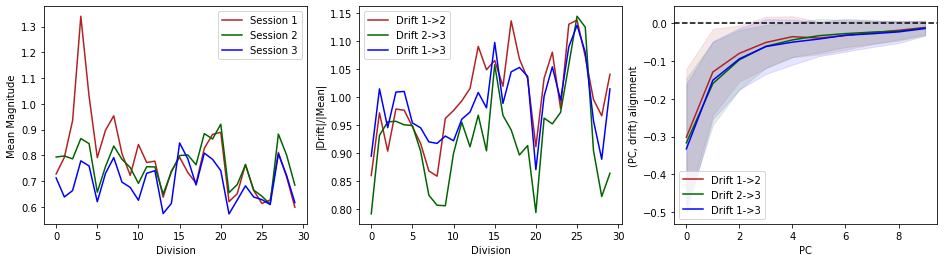

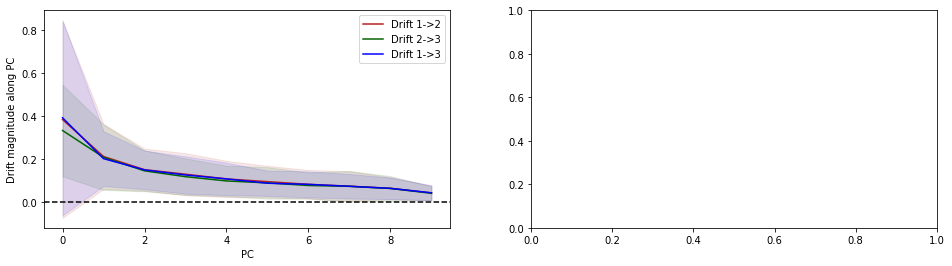

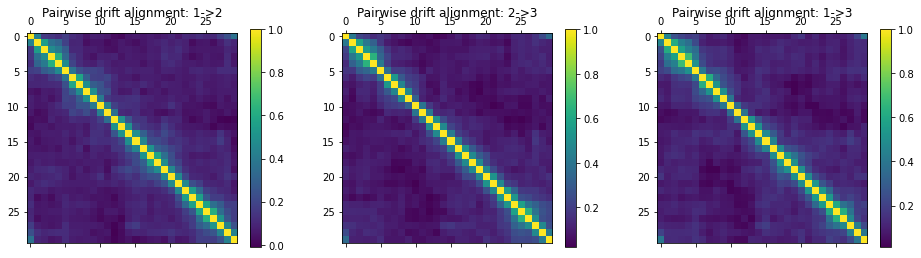

In [14]:
from sklearn.decomposition import PCA

def get_align(x, y):
     return np.dot(x,y)/(
         np.linalg.norm(x) * np.linalg.norm(y)
     )

drift_pair_idxs = [[0, 1], [1, 2], [0, 2]]
n_drifts = len(drift_pair_idxs)

mean_mags_experiments = np.zeros((n_containers, n_sessions, n_divs))
drift_mags_experiments = np.zeros((n_containers, n_drifts, n_divs))
# Assumes max number of PCAs is always going to be at most n_repeats
prs_experiments = np.zeros((n_containers, n_sessions, n_divs))
prs_rel_experiments = np.zeros((n_containers, n_sessions, n_divs))
var_space_variance_experiments = np.zeros((n_containers, n_sessions, n_divs))
pca_drift_align_experiments = np.zeros((n_containers, n_drifts, n_divs, n_repeats))
pca_drift_magnitude_experiments = np.zeros((n_containers, n_drifts, n_divs, n_repeats))

drift_drift_aligns_experiments = np.zeros((n_containers, n_drifts, n_divs, n_divs))

session_labels = ['1', '2', '3']

for container_idx in range(n_containers):

    exps_container = exps[container_idx*n_sessions:(container_idx+1)*n_sessions]
    cell_ids_container = cell_ids_experiments[container_idx*n_sessions:(container_idx+1)*n_sessions]
    dff_vals_container = dff_vals_experiments[container_idx*n_sessions:(container_idx+1)*n_sessions]

    # Find shared IDs
    unique_cell_ids = get_unique_cell_ids(cell_ids_container)
    shared_cell_idxs = get_shared_cell_idxs(unique_cell_ids, verbose=False)
    n_shared = shared_cell_idxs[0].shape[0]

    n_pcas = np.min((n_repeats, n_shared))

    means_session = np.zeros((n_sessions, n_divs, n_shared))
    pcas_session = [[] for _ in range(n_sessions)] 

    for session_idx in range(n_sessions):
        # dff_vals = np.zeros((n_repeats, n_divs, n_cells))
        dff_vals_session = dff_vals_container[session_idx][:, :, shared_cell_idxs[session_idx]]
        
        means_session[session_idx] = np.mean(dff_vals_session, axis=0)
        for div_idx in range(n_divs):
            pca_div = PCA()
            pca_div.fit(dff_vals_session[:, div_idx])
            
            # Removes ambiguity in PCA direction by making sure all means (along PC directions) are positive
            pca_dir_signs = np.sign(np.mean(np.matmul(dff_vals_session[:, div_idx], pca_div.components_.T), axis=0))
            for pca_idx, pca_dir in enumerate(pca_div.components_):
                pca_div.components_[pca_idx, :] = pca_dir_signs[pca_idx] * pca_dir        
            pcas_session[session_idx].append(pca_div)

            dim_var_space = participation_ratio_vector(
                pca_div.explained_variance_ratio_
            )

            prs_experiments[container_idx, session_idx, div_idx] = dim_var_space
            prs_rel_experiments[container_idx, session_idx, div_idx] = dim_var_space/n_shared
            var_space_variance_experiments[container_idx, session_idx, div_idx] = (
                np.sum(pca_div.explained_variance_ratio_[:int(np.ceil(dim_var_space))])
            )          


    drifts_session = np.zeros((n_drifts, n_divs, n_shared))
    pca_drift_align = np.zeros((n_drifts, n_divs, n_pcas))
    pca_drift_magnitude = np.zeros((n_drifts, n_divs, n_pcas))
    drift_drift_aligns = np.zeros((n_drifts, n_divs, n_divs))

    for drift_idx in range(n_drifts):
        session_idx1 = drift_pair_idxs[drift_idx][0]
        session_idx2 = drift_pair_idxs[drift_idx][1]

        drifts_session[drift_idx] = (means_session[session_idx2] - 
                        means_session[session_idx1])

        for div_idx in range(n_divs):
            # Drift in the PCA coordinates (of starting session)
            pca_drift = np.matmul( 
                pcas_session[session_idx1][div_idx].components_,
                drifts_session[drift_idx, div_idx]
            )
            for pca_idx in range(n_pcas):
                pca_drift_align[drift_idx, div_idx, pca_idx] = get_align(
                    drifts_session[drift_idx, div_idx],
                    pcas_session[session_idx1][div_idx].components_[pca_idx]
                )
                pca_drift_magnitude[drift_idx, div_idx, pca_idx] = np.abs(pca_drift[pca_idx])
            for div_idx2 in range(n_divs):
                drift_drift_aligns[drift_idx, div_idx, div_idx2] = get_align(
                    drifts_session[drift_idx, div_idx],
                    drifts_session[drift_idx, div_idx2]
                )

    mean_mags_experiments[container_idx] = np.linalg.norm(means_session, axis=-1)
    drift_mags_experiments[container_idx] = np.linalg.norm(drifts_session, axis=-1)
    pca_drift_align_experiments[container_idx, :, :, :n_pcas] = pca_drift_align
    pca_drift_magnitude_experiments[container_idx, :, :, :n_pcas] = pca_drift_magnitude
    drift_drift_aligns_experiments[container_idx] = drift_drift_aligns

print('Dimension of variation space: {:.2f} (std: {:.2f})'.format(
    prs_experiments.mean(), prs_experiments.std()
))
print('Relative Dimension of variation space: {:.3e} (std: {:.3e})'.format(
    prs_rel_experiments.mean(), prs_rel_experiments.std()
))
print('Perc. variance in variation space: {:.2f} (std: {:.2f})'.format(
    var_space_variance_experiments.mean(), var_space_variance_experiments.std()
))

fig, ax = plt.subplots(1, 3, figsize=(16,4))
fig2, ax2 = plt.subplots(1, 2, figsize=(16,4))
fig3, ax3 = plt.subplots(1, 3, figsize=(16,4))

avg_mean_mags = np.mean(mean_mags_experiments, axis=0)
avg_drift_mags = np.mean(drift_mags_experiments, axis=0)
# Average over all divisions first
avg_pca_drift_align = np.mean(np.mean(pca_drift_align_experiments, axis=2), axis=0)
std_pca_drift_align = np.std(np.mean(pca_drift_align_experiments, axis=2), axis=0)
avg_drift_drift_aligns = np.mean(drift_drift_aligns_experiments, axis=0)

# Average over all divisions first
avg_pca_drift_mag = np.mean(np.mean(pca_drift_magnitude_experiments, axis=2), axis=0)
std_pca_drift_mag = np.std(np.mean(pca_drift_magnitude_experiments, axis=2), axis=0)

for session_idx in range(n_sessions):
    ax[0].plot(avg_mean_mags[session_idx], color=c_vals[session_idx], 
               label='Session {}'.format(
                   session_labels[session_idx]
               ))

for drift_idx in range(n_drifts):
    session_idx1 = drift_pair_idxs[drift_idx][0]
    session_idx2 = drift_pair_idxs[drift_idx][1]
    ax[1].plot(avg_drift_mags[drift_idx] / avg_mean_mags[session_idx1], 
               color=c_vals[drift_idx], label='Drift {}->{}'.format(
                   session_labels[session_idx1], session_labels[session_idx2]
               ))
    
    # PCA/drift alignment, as a function of PC. Average over divisions
    # avg_align = np.mean(avg_pca_drift_align[session_idx], axis=0)
    # avg_align_std = np.mean(std_pca_drift_align[session_idx], axis=0)
    avg_align = avg_pca_drift_align[drift_idx]
    avg_align_std = std_pca_drift_align[drift_idx]
    
    ax[2].plot(avg_align,
               color=c_vals[drift_idx], label='Drift {}->{}'.format(
                   session_labels[session_idx1], session_labels[session_idx2]
               ))
    # for container_idx in range(n_containers):
    #     ax[2].plot(np.mean(pca_drift_align_experiments[container_idx, drift_idx], axis=0), 
    #                color=c_vals[drift_idx], alpha=0.3)
    ax[2].fill_between(np.arange(n_pcas), avg_align-avg_align_std, avg_align+avg_align_std,
               color=c_vals[drift_idx], alpha=0.1
               )
    

    avg_mag = avg_pca_drift_mag[drift_idx]
    avg_mag_std = std_pca_drift_mag[drift_idx]

    ax2[0].plot(avg_mag, color=c_vals[drift_idx], label='Drift {}->{}'.format(
                   session_labels[session_idx1], session_labels[session_idx2]
               ))
    # for container_idx in range(n_containers):
    #     cre_line_container = cre_lines_experiments[container_idx*n_sessions]
    #     ax2[0].plot(np.mean(pca_drift_magnitude_experiments[container_idx, drift_idx], axis=0), 
    #                color=c_vals[cre_lines.index(cre_line_container)], alpha=0.3)

    ax2[0].fill_between(np.arange(n_pcas), avg_mag-avg_mag_std, avg_mag+avg_mag_std,
               color=c_vals[drift_idx], alpha=0.1
               )

    mat_plot = ax3[drift_idx].matshow(avg_drift_drift_aligns[drift_idx])
    plt.colorbar(mat_plot, ax=ax3[drift_idx])
    ax3[drift_idx].set_title('Pairwise drift alignment: {}->{}'.format(
        session_labels[session_idx1], session_labels[session_idx2]
    ))

ax[0].legend()
ax[0].set_xlabel('Division')
ax[0].set_ylabel('Mean Magnitude')

ax[1].legend()
ax[1].set_xlabel('Division')
ax[1].set_ylabel('|Drift|/|Mean|')

ax[2].legend()
ax[2].axhline(0.0, color='k', linestyle='dashed')
ax[2].set_xlabel('PC')
ax[2].set_ylabel('(PC, drift) alignment')

# ax2[0].set_ylim([-0.1, 1.1])

ax2[0].legend()
ax2[0].axhline(0.0, color='k', linestyle='dashed')
ax2[0].set_xlabel('PC')
ax2[0].set_ylabel('Drift magnitude along PC')

Delta t 1 occurences: 73
Delta t 2 occurences: 31
Delta t 3 occurences: 16
Delta t 4 occurences: 21
Delta t 5 occurences: 20
Delta t 6 occurences: 21
Delta t 7 occurences: 13
Delta t 8 occurences: 9
Delta t 9 occurences: 5
Delta t 10 occurences: 1
Delta t 11 occurences: 3
Delta t 12 occurences: 2
Delta t 13 occurences: 1
Delta t 14 occurences: 0
Delta t 15 occurences: 1
Delta t 16 occurences: 1
Delta t 17 occurences: 0
Delta t 18 occurences: 0
Delta t 19 occurences: 0
Delta t 20 occurences: 0
Delta t 21 occurences: 0
Delta t 22 occurences: 1
Filtering delta t values at: 10
Total removed: 209/219
Slope: -0.01 (se: 0.00), r: -0.11 p: 9.77e-02
Slope: 0.51 (se: 0.30), r: 0.12 p: 8.72e-02
Slope: 0.03 (se: 0.02), r: 0.12 p: 7.62e-02
Slope: 0.51 (se: 0.30), r: 0.12 p: 8.72e-02
Slope: -0.01 (se: 0.00), r: -0.11 p: 9.77e-02


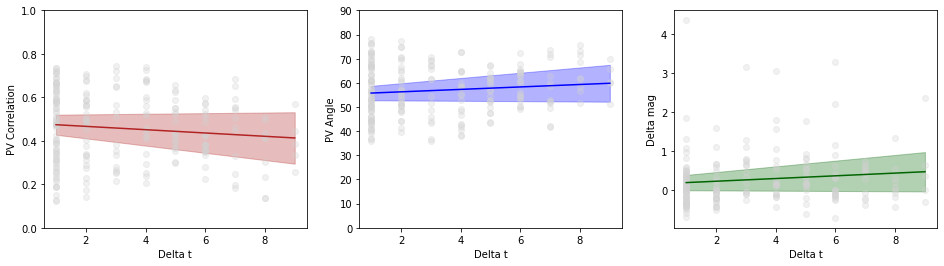

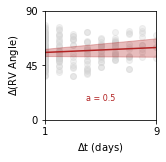

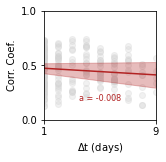

In [15]:
from scipy.stats import linregress

n_se = 1.97

drift_pair_idxs = [[0, 1], [1, 2], [0, 2]]
n_drifts = len(drift_pair_idxs)

cre_line_idxs = np.zeros((n_containers, n_drifts), dtype=np.int32)
drift_deltat = np.zeros((n_containers, n_drifts))

drift_corrs = np.zeros((n_containers, n_drifts))
drift_angles = np.zeros((n_containers, n_drifts))
drift_deltamag = np.zeros((n_containers, n_drifts))

delta_t_thresh = 5 # Minimum number of points for plot

for container_idx in range(n_containers):

    exps_container = exps[container_idx*n_sessions:(container_idx+1)*n_sessions]
    cell_ids_container = cell_ids_experiments[container_idx*n_sessions:(container_idx+1)*n_sessions]
    dff_vals_container = dff_vals_experiments[container_idx*n_sessions:(container_idx+1)*n_sessions]
    ages_container = ages_experiments[container_idx*n_sessions:(container_idx+1)*n_sessions]

    # Find shared IDs
    unique_cell_ids = get_unique_cell_ids(cell_ids_container)
    shared_cell_idxs = get_shared_cell_idxs(unique_cell_ids, verbose=False)
    n_shared = shared_cell_idxs[0].shape[0]

    means_session = np.zeros((n_sessions, n_divs, n_shared))

    for session_idx in range(n_sessions):
        dff_vals_session = dff_vals_container[session_idx][:, :, shared_cell_idxs[session_idx]]

        # Averages across repeats to get mean response in a given session    
        means_session[session_idx] = np.mean(dff_vals_session, axis=0)

    for drift_idx in range(n_drifts):
        session_idx1 = drift_pair_idxs[drift_idx][0]
        session_idx2 = drift_pair_idxs[drift_idx][1]

        drift_div_corrs = np.zeros((n_divs,))
        drift_div_angles = np.zeros((n_divs,))
        drift_div_deltamags = np.zeros((n_divs,))

        for div_idx in range(n_divs):
            drift_div_corrs[div_idx] = np.corrcoef(
                means_session[session_idx1, div_idx],
                means_session[session_idx2, div_idx]
            )[0, 1]
            drift_div_angles[div_idx] = get_align_angle(
                means_session[session_idx1, div_idx],
                means_session[session_idx2, div_idx]
            )
            drift_div_deltamags[div_idx] = (
                np.linalg.norm(means_session[session_idx2, div_idx]) -
                np.linalg.norm(means_session[session_idx1, div_idx])
            )/np.linalg.norm(means_session[session_idx1, div_idx])

        drift_deltat[container_idx, drift_idx] = (
            ages_container[session_idx2] - ages_container[session_idx1] 
        )
        # Cre lines for all drifts are the same, so just gets cre line from first session
        cre_line_idxs[container_idx, drift_idx] = cre_lines.index(
            cre_lines_experiments[container_idx*n_sessions])
        
        drift_corrs[container_idx, drift_idx] = np.mean(drift_div_corrs)
        drift_angles[container_idx, drift_idx] = np.mean(drift_div_angles)
        drift_deltamag[container_idx, drift_idx] = np.mean(drift_div_deltamags)

fit_X = drift_deltat.flatten()
# Number of occurences for each delta t:
delta_t_cutoff = None
for delta_t_val in range(1, int(np.max(fit_X)+1)):
    print('Delta t {} occurences:'.format(delta_t_val), np.sum(fit_X == delta_t_val))
    if np.sum(fit_X == delta_t_val) < delta_t_thresh and delta_t_cutoff == None:
        delta_t_cutoff = delta_t_val

fit_X = drift_deltat.flatten()
if delta_t_thresh == None:
    delta_t_filter = np.ones(fit_X.shape)
else:
    print('Filtering delta t values at:', delta_t_cutoff)
    delta_t_filter = fit_X < delta_t_cutoff
    print('Total removed: {}/{}'.format(np.sum(delta_t_filter), fit_X.shape[0]))
fit_X = fit_X[delta_t_filter]    

fig, ax = plt.subplots(1, 3, figsize=(16,4))

fit_y = drift_corrs.flatten()[delta_t_filter]
cre_colors = [c_vals_l[cre_idx] for cre_idx in cre_line_idxs.flatten()]
# fit_y = drift_corrs.flatten()[drift_deltat.flatten() < 10.0]
# fit_X = drift_deltat.flatten()[drift_deltat.flatten() < 10.0]

reg = linregress(fit_X, fit_y)
print('Slope: {:.2f} (se: {:.2f}), r: {:.2f} p: {:.2e}'.format(
      reg.slope, reg.stderr, reg.rvalue, reg.pvalue))
reg_plot_X = np.linspace(np.min(fit_X), np.max(fit_X), num=50)
reg_plot_y = reg.slope * reg_plot_X + reg.intercept
reg_plot_min_y = ((reg.slope - n_se* reg.stderr) * reg_plot_X + 
                  (reg.intercept - n_se * reg.intercept_stderr))
reg_plot_max_y = ((reg.slope + n_se * reg.stderr) * reg_plot_X + 
                  (reg.intercept + n_se * reg.intercept_stderr))
ax[0].fill_between(reg_plot_X, reg_plot_min_y, reg_plot_max_y, 
                    color=c_vals[0], alpha=0.3)
ax[0].plot(reg_plot_X, reg_plot_y, color=c_vals[0])

ax[0].scatter(fit_X, fit_y, color='lightgrey', alpha=0.3)

ax[0].set_xlabel('Delta t')
ax[0].set_ylabel('PV Correlation')
ax[0].set_ylim([0.0, 1.0])

fit_y = drift_angles.flatten()[delta_t_filter]

reg = linregress(fit_X, fit_y)
print('Slope: {:.2f} (se: {:.2f}), r: {:.2f} p: {:.2e}'.format(
      reg.slope, reg.stderr, reg.rvalue, reg.pvalue))
reg_plot_X = np.linspace(np.min(fit_X), np.max(fit_X), num=50)
reg_plot_y = reg.slope * reg_plot_X + reg.intercept
reg_plot_min_y = ((reg.slope - n_se* reg.stderr) * reg_plot_X + 
                  (reg.intercept - n_se * reg.intercept_stderr))
reg_plot_max_y = ((reg.slope + n_se * reg.stderr) * reg_plot_X + 
                  (reg.intercept + n_se * reg.intercept_stderr))
ax[1].fill_between(reg_plot_X, reg_plot_min_y, reg_plot_max_y, 
                    color=c_vals[2], alpha=0.3)
ax[1].plot(reg_plot_X, reg_plot_y, color=c_vals[2])

ax[1].scatter(fit_X, fit_y, color='lightgrey', alpha=0.3)

ax[1].set_xlabel('Delta t')
ax[1].set_ylabel('PV Angle')
ax[1].set_ylim([0, 90.0])

fit_y = drift_deltamag.flatten()[delta_t_filter]

reg = linregress(fit_X, fit_y)
print('Slope: {:.2f} (se: {:.2f}), r: {:.2f} p: {:.2e}'.format(
      reg.slope, reg.stderr, reg.rvalue, reg.pvalue))
reg_plot_X = np.linspace(np.min(fit_X), np.max(fit_X), num=50)
reg_plot_y = reg.slope * reg_plot_X + reg.intercept
reg_plot_min_y = ((reg.slope - n_se* reg.stderr) * reg_plot_X + 
                  (reg.intercept - n_se * reg.intercept_stderr))
reg_plot_max_y = ((reg.slope + n_se * reg.stderr) * reg_plot_X + 
                  (reg.intercept + n_se * reg.intercept_stderr))
ax[2].fill_between(reg_plot_X, reg_plot_min_y, reg_plot_max_y, 
                    color=c_vals[1], alpha=0.3)
ax[2].plot(reg_plot_X, reg_plot_y, color=c_vals[1])

ax[2].scatter(fit_X, fit_y, color='lightgrey', alpha=0.3)

ax[2].set_xlabel('Delta t')
ax[2].set_ylabel('Delta mag')
# ax[2].set_ylim([1.5, -1.5])

# Final figures for angle/correlation

fig, ax = plt.subplots(1, 1, figsize=(2,2))

fit_y = drift_angles.flatten()[delta_t_filter]

reg = linregress(fit_X, fit_y)
print('Slope: {:.2f} (se: {:.2f}), r: {:.2f} p: {:.2e}'.format(
      reg.slope, reg.stderr, reg.rvalue, reg.pvalue))
reg_plot_X = np.linspace(np.min(fit_X), np.max(fit_X), num=50)
reg_plot_y = reg.slope * reg_plot_X + reg.intercept
reg_plot_min_y = ((reg.slope - n_se* reg.stderr) * reg_plot_X + 
                  (reg.intercept - n_se * reg.intercept_stderr))
reg_plot_max_y = ((reg.slope + n_se * reg.stderr) * reg_plot_X + 
                  (reg.intercept + n_se * reg.intercept_stderr))

ax.scatter(fit_X, fit_y, color='lightgrey', alpha=0.3)

ax.fill_between(reg_plot_X, reg_plot_min_y, reg_plot_max_y, 
                    color=c_vals[0], alpha=0.3)
ax.plot(reg_plot_X, reg_plot_y, color=c_vals[0])

ax.text(0.5, 0.2, 'a = {:.1f}'.format(reg.slope), 
           horizontalalignment='center', verticalalignment='center', 
           color=c_vals[0], fontsize=8, transform=ax.transAxes)

ax.set_xlabel('$\Delta$t (days)')
ax.set_ylabel('$\Delta$(RV Angle)')
ax.set_ylim([0, 90.0])
ax.set_xlim([1, np.max(fit_X)])
ax.set_yticks([0, 45.0, 90.0])
ax.set_xticks([1, np.max(fit_X)])

try:
    jetplot.breathe(ax=ax)
except NameError:
    pass

# Correlation plot
fig, ax = plt.subplots(1, 1, figsize=(2,2))

fit_y = drift_corrs.flatten()[delta_t_filter]

reg = linregress(fit_X, fit_y)
print('Slope: {:.2f} (se: {:.2f}), r: {:.2f} p: {:.2e}'.format(
      reg.slope, reg.stderr, reg.rvalue, reg.pvalue))
reg_plot_X = np.linspace(np.min(fit_X), np.max(fit_X), num=50)
reg_plot_y = reg.slope * reg_plot_X + reg.intercept
reg_plot_min_y = ((reg.slope - n_se* reg.stderr) * reg_plot_X + 
                  (reg.intercept - n_se * reg.intercept_stderr))
reg_plot_max_y = ((reg.slope + n_se * reg.stderr) * reg_plot_X + 
                  (reg.intercept + n_se * reg.intercept_stderr))

ax.scatter(fit_X, fit_y, color='lightgrey', alpha=0.3)

ax.fill_between(reg_plot_X, reg_plot_min_y, reg_plot_max_y, 
                    color=c_vals[0], alpha=0.3)
ax.plot(reg_plot_X, reg_plot_y, color=c_vals[0])

ax.text(0.5, 0.2, 'a = {:.3f}'.format(reg.slope), 
           horizontalalignment='center', verticalalignment='center', 
           color=c_vals[0], fontsize=8, transform=ax.transAxes)

ax.set_xlabel('$\Delta$t (days)')
ax.set_ylabel('Corr. Coef.')
ax.set_ylim([0, 1.0])
ax.set_xlim([1, np.max(fit_X)])
ax.set_yticks([0, 0.5, 1.0])
ax.set_xticks([1, np.max(fit_X)])

try:
    jetplot.breathe(ax=ax)
except NameError:
    pass

Number in bin: 73
Number in bin: 31
Number in bin: 16
Number in bin: 21
Number in bin: 20
Number in bin: 21
Number in bin: 13
Number in bin: 9
Slope: 0.03 (se: 0.02), r: 0.11 p: 1.29e-01
Slope: -0.00 (se: 0.01), r: -0.02 p: 7.59e-01
Slope: -0.61 (se: 0.21), r: -0.21 p: 3.22e-03
Slope: -0.01 (se: 0.00), r: -0.11 p: 1.03e-01


(0.0, 1.0)

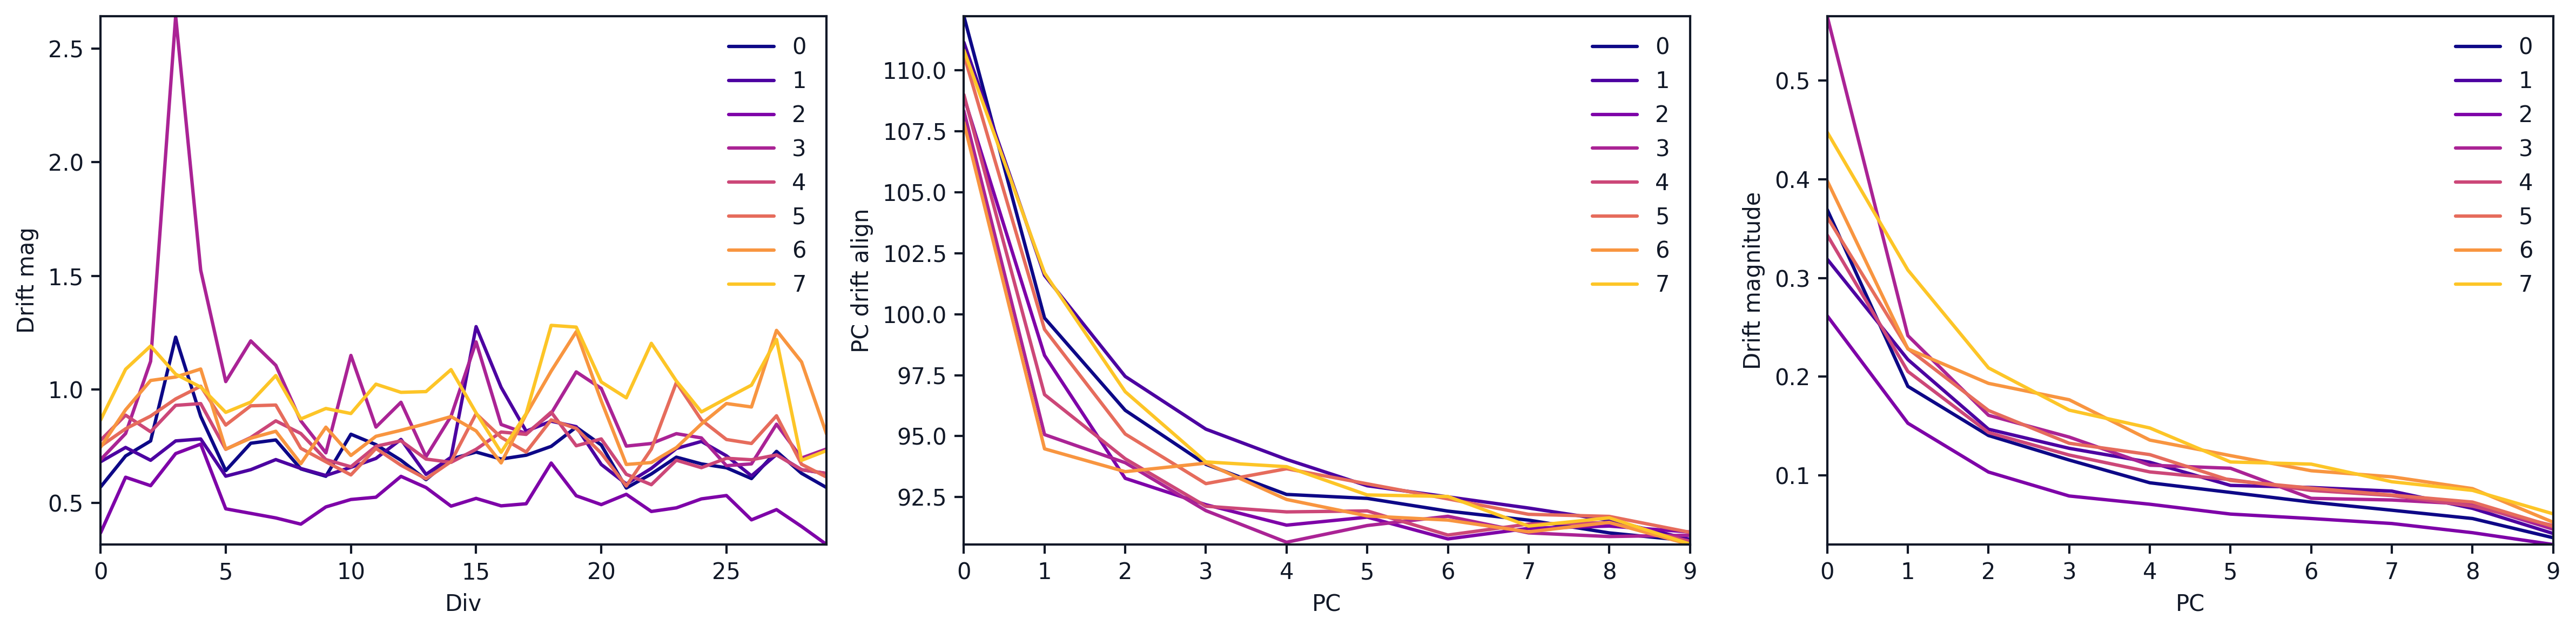

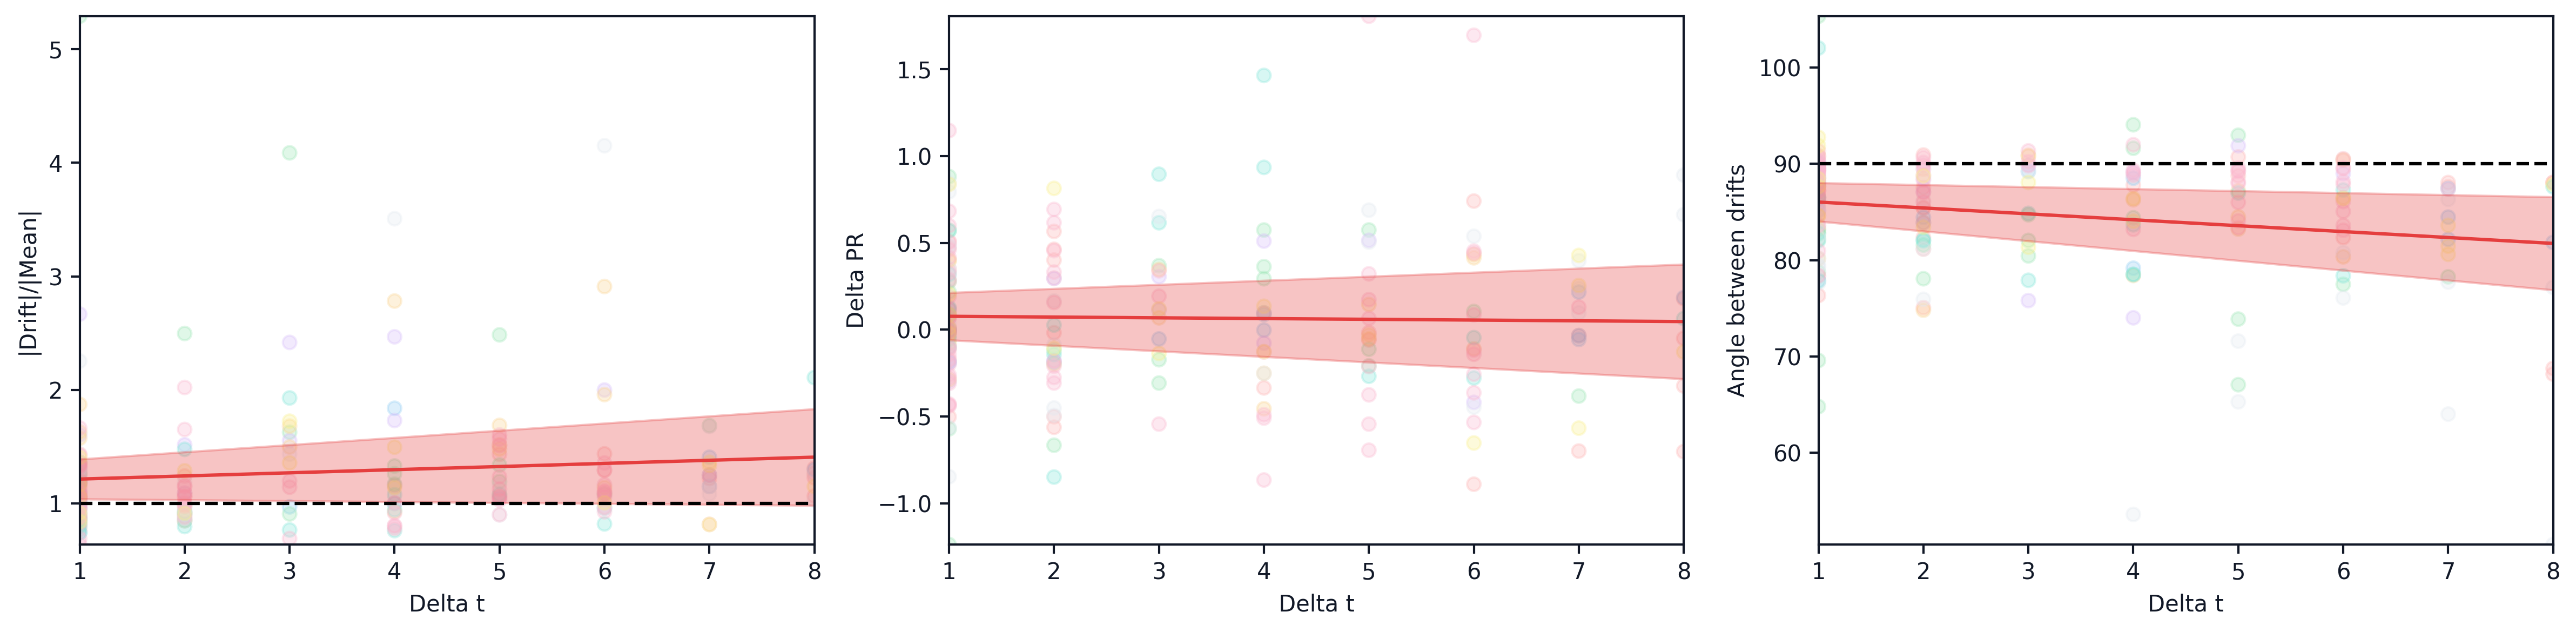

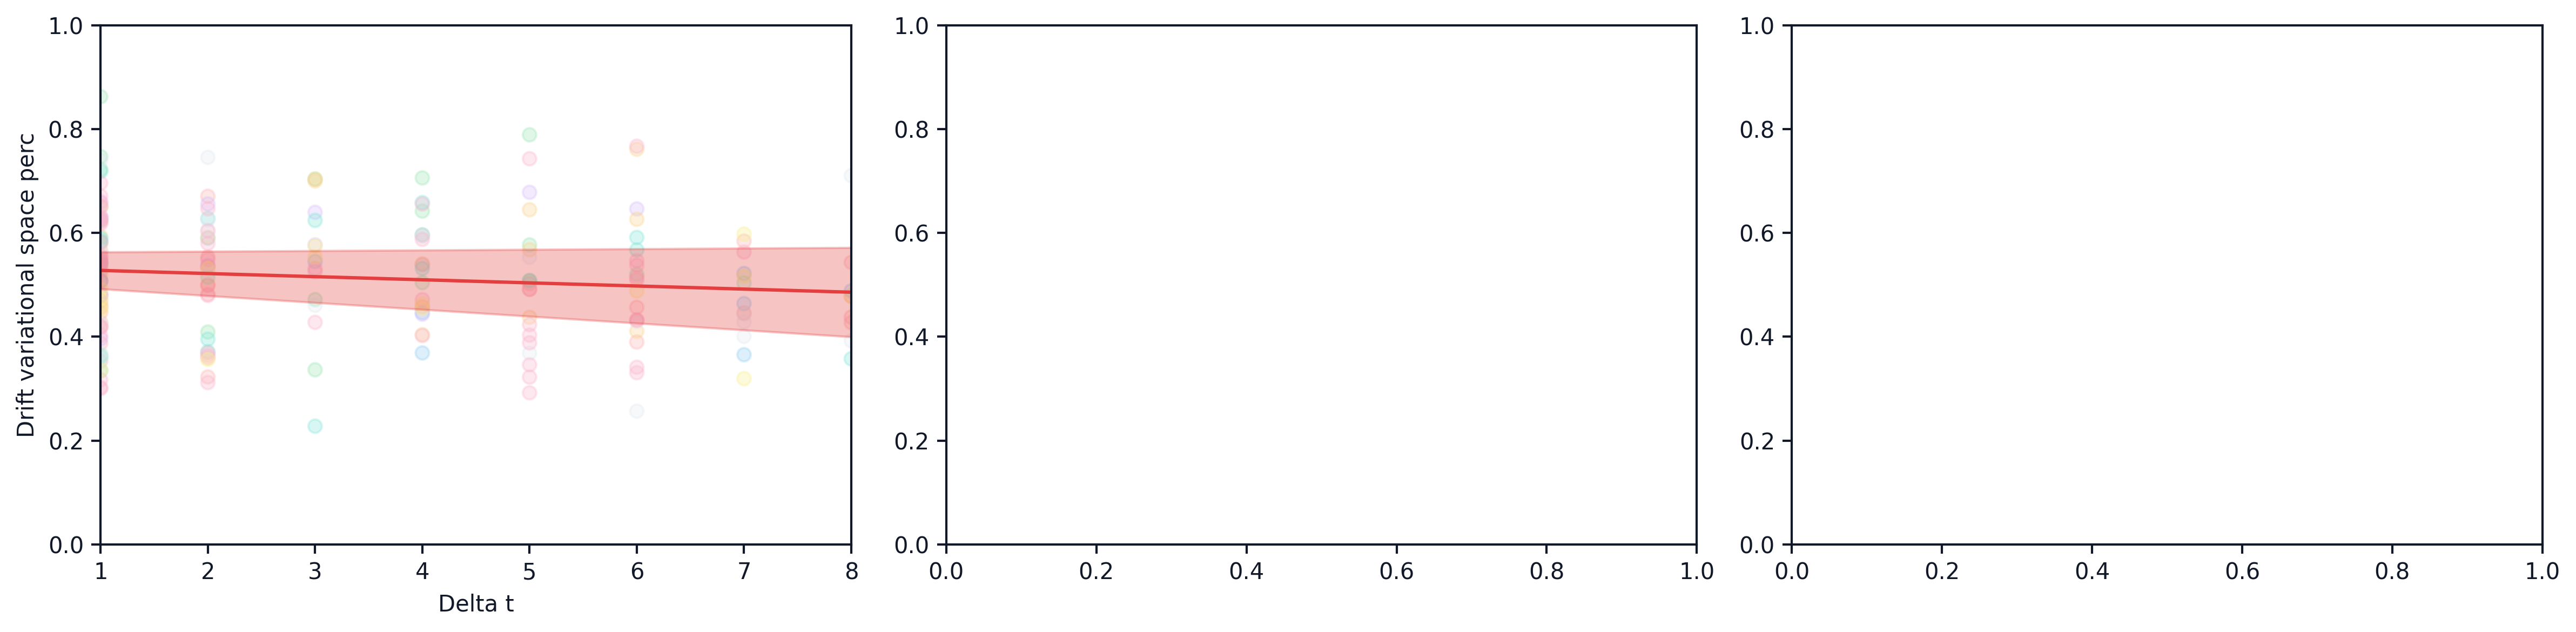

In [45]:
from sklearn.decomposition import PCA

def subspace_perc(A, b):
    """
    A: an N x M matrix, whose column space represents some M-dimensional subspace
    b: an N x P vector
    For each of b's columns, finds the percentage of its magnitude which lies in 
    the subspace formed by the columns of A (its columnspace). Then averages these together
    """
    if len(b.shape) == 1:
        b = b[:, np.newaxis]

    proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T) # N x N matrix
    b_proj = np.matmul(proj, b) # N x P martix

    norm_perc = np.linalg.norm(b_proj, axis=0)/np.linalg.norm(b, axis=0) # P dim vector

    return np.sum(norm_perc**2)/np.min((A.shape[1], b.shape[1]))

def subspace_perc_new(A, b):
    """
    A: an N x M matrix, whose column space represents some M-dimensional subspace
    b: an N x P vector
    For each of b's columns, finds the percentage of its magnitude which lies in 
    the subspace formed by the columns of A (its columnspace). Then averages these together
    """
    proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T) # N x N matrix
    b_proj = np.matmul(proj, b) # N x P martix

    norm_perc = np.linalg.norm(b_proj, axis=0)/np.linalg.norm(b, axis=0) # P dim vector

    return np.sum(norm_perc**2)/np.min((A.shape[1], b.shape[1]))

# Plots metrics by delta t

drift_pair_idxs = [[0, 1], [1, 2], [0, 2]]
n_drifts = len(drift_pair_idxs)

drift_deltat = np.zeros((n_containers, n_drifts))
cre_line_idxs = np.zeros((n_containers, n_drifts), dtype=np.int32)

mean_mags_experiments = np.zeros((n_containers, n_sessions, n_divs))
prs_experiments = np.zeros((n_containers, n_sessions, n_divs))
delta_prs_experiments = np.zeros((n_containers, n_sessions, n_divs))
drift_mags_experiments = np.zeros((n_containers, n_drifts, n_divs))
rel_drift_mags_experiments = np.zeros((n_containers, n_drifts, n_divs))

n_subset = 10 # Number of divs to take from start and end of movie
drift_aligns_experiments = np.zeros((n_containers, n_drifts, n_subset*n_subset))

# Assumes max number of PCAs is always going to be at most n_repeats (filter for this to make it true)
pca_var_exp_i_experiments = np.zeros((n_containers, n_drifts, n_divs, n_repeats))
pca_drift_align_experiments = np.zeros((n_containers, n_drifts, n_divs, n_repeats))
pca_drift_magnitude_experiments = np.zeros((n_containers, n_drifts, n_divs, n_repeats))
drift_varspace_perc_experiments = np.zeros((n_containers, n_drifts, n_divs,))
varspace1_varspace2_perc_experiments = np.zeros((n_containers, n_drifts, n_divs,))
varspace2_varspace1_perc_experiments = np.zeros((n_containers, n_drifts, n_divs,))
varspace1_varspace2_chance_experiments = np.zeros((n_containers, n_drifts, n_divs,))
pca1_var_exp2_experiments = np.zeros((n_containers, n_drifts, n_divs, n_repeats))

for container_idx in range(n_containers):

    exps_container = exps[container_idx*n_sessions:(container_idx+1)*n_sessions]
    cell_ids_container = cell_ids_experiments[container_idx*n_sessions:(container_idx+1)*n_sessions]
    dff_vals_container = dff_vals_experiments[container_idx*n_sessions:(container_idx+1)*n_sessions]
    ages_containder = ages_experiments[container_idx*n_sessions:(container_idx+1)*n_sessions]

    # Find shared IDs
    unique_cell_ids = get_unique_cell_ids(cell_ids_container)
    shared_cell_idxs = get_shared_cell_idxs(unique_cell_ids, verbose=False)
    n_shared = shared_cell_idxs[0].shape[0]

    n_pcas = np.min((n_repeats, n_shared))

    means_session = np.zeros((n_sessions, n_divs, n_shared))

    pcas_session = [[] for _ in range(n_sessions)] 
    var_exp_session = np.zeros((n_sessions, n_divs, n_repeats))
    prs_session = np.zeros((n_sessions, n_divs))

    for session_idx in range(n_sessions):
        # dff_vals = np.zeros((n_repeats, n_divs, n_cells))
        dff_vals_session = dff_vals_container[session_idx][:, :, shared_cell_idxs[session_idx]]
        
        means_session[session_idx] = np.mean(dff_vals_session, axis=0)
        for div_idx in range(n_divs):
            pca_div = PCA()
            pca_div.fit(dff_vals_session[:, div_idx])
            
            # Removes ambiguity in PCA direction by making sure all means (along PC directions) are positive
            pca_dir_signs = np.sign(np.mean(np.matmul(dff_vals_session[:, div_idx], pca_div.components_.T), axis=0))
            for pca_idx, pca_dir in enumerate(pca_div.components_):
                pca_div.components_[pca_idx, :] = pca_dir_signs[pca_idx] * pca_dir        
            pcas_session[session_idx].append(pca_div)
            
            var_exp_session[session_idx, div_idx] = pca_div.explained_variance_ratio_

            prs_session[session_idx, div_idx] = participation_ratio_vector(
                pca_div.explained_variance_ratio_
            )

    drifts_session = np.zeros((n_drifts, n_divs, n_shared))
    var_exp_i_session = np.zeros((n_drifts, n_divs, n_repeats))
    rel_drift_mag_session = np.zeros((n_drifts, n_divs,))
    delta_pr_session = np.zeros((n_drifts, n_divs,))
    drift_varspace_perc_session = np.zeros((n_drifts, n_divs,))
    varspace1_varspace2_perc_session = np.zeros((n_drifts, n_divs,))
    varspace2_varspace1_perc_session = np.zeros((n_drifts, n_divs,))
    varspace1_varspace2_chance_session = np.zeros((n_drifts, n_divs,))

    pca_drift_align = np.zeros((n_drifts, n_divs, n_pcas))
    pca_drift_magnitude = np.zeros((n_drifts, n_divs, n_pcas))

    pca1_var_exp2_session = np.zeros((n_drifts, n_divs, n_repeats))

    # Pairwise alignment, 
    drift_aligns_session = np.zeros((n_drifts, n_subset*n_subset))

    for drift_idx in range(n_drifts):
        session_idx1 = drift_pair_idxs[drift_idx][0]
        session_idx2 = drift_pair_idxs[drift_idx][1]

        var_exp_i_session[drift_idx] = var_exp_session[session_idx1]

        drift_deltat[container_idx, drift_idx] = (
            ages_containder[session_idx2] - ages_containder[session_idx1] 
        )
        # Cre lines for all drifts are the same, so just gets cre line from first session
        cre_line_idxs[container_idx, drift_idx] = cre_lines.index(
            cre_lines_experiments[container_idx*n_sessions])

        drifts_session[drift_idx] = (means_session[session_idx2] - 
                        means_session[session_idx1])        
        delta_pr_session[drift_idx] = (prs_session[session_idx2] - 
                        prs_session[session_idx1])

        rel_drift_mag_session[drift_idx] = np.linalg.norm(
            drifts_session[drift_idx], axis=-1
            )/np.linalg.norm(
            means_session[session_idx1], axis=-1
        )

        for div_idx in range(n_divs):
            # Drift in the PCA coordinates (of starting session)
            pca_drift = np.matmul( 
                pcas_session[session_idx1][div_idx].components_,
                drifts_session[drift_idx, div_idx]
            )
            for pca_idx in range(n_pcas):
                pca_drift_align[drift_idx, div_idx, pca_idx] = get_align_angle(
                    drifts_session[drift_idx, div_idx],
                    pcas_session[session_idx1][div_idx].components_[pca_idx]
                )
                pca_drift_magnitude[drift_idx, div_idx, pca_idx] = np.abs(pca_drift[pca_idx])

            # Drift in variational space
            dim_session1 = int(np.ceil(prs_session[session_idx1, div_idx])) # Dimension of session 1 var space
            dim_session2 = int(np.ceil(prs_session[session_idx2, div_idx])) # Dimension of session 1 var space
            drift_varspace_perc_session[drift_idx, div_idx] = subspace_perc(
                pcas_session[session_idx1][div_idx].components_[:dim_session1].T,
                drifts_session[drift_idx, div_idx]
            )
            varspace1_varspace2_perc_session[drift_idx, div_idx] = subspace_perc_new(
                pcas_session[session_idx1][div_idx].components_[:dim_session1].T,
                pcas_session[session_idx2][div_idx].components_[:dim_session2].T
            )
            varspace2_varspace1_perc_session[drift_idx, div_idx] = subspace_perc_new(
                pcas_session[session_idx2][div_idx].components_[:dim_session2].T,
                pcas_session[session_idx1][div_idx].components_[:dim_session1].T
            )
            varspace1_varspace2_chance_session[drift_idx, div_idx] = (
                np.max((dim_session1, dim_session2)) / n_shared
            )
            # print('Dims 1: {} 2:{}'.format(dim_session1, dim_session2))
            # print('1, 2: {:.3f}'.format(varspace1_varspace2_perc_session[drift_idx, div_idx]))
            # print('2, 1: {:.3f}'.format(varspace2_varspace1_perc_session[drift_idx, div_idx]))

            data1 = dff_vals_container[session_idx1][:, div_idx, shared_cell_idxs[session_idx1]]
            data2 = dff_vals_container[session_idx2][:, div_idx, shared_cell_idxs[session_idx2]]

            # Flow of variation
            pca1_data1 = np.matmul(data1, pcas_session[session_idx1][div_idx].components_.T)
            pca1_data2 = np.matmul(data2, pcas_session[session_idx1][div_idx].components_.T)
            
            pca1_data1_cov = np.cov(pca1_data1.T)
            pca1_data1_vars = np.diag(pca1_data1_cov)
            pca1_data1_vars_ratio = pca1_data1_vars/np.sum(pca1_data1_vars)
            pca1_data2_cov = np.cov(pca1_data2.T)
            pca1_data2_vars = np.diag(pca1_data2_cov)
            pca1_var_exp2_session[drift_idx, div_idx] = pca1_data2_vars/np.sum(pca1_data2_vars)

        # Pairwise drift aligns
        count_idx = 0
        for div_idx1 in range(n_subset):
            for div_idx2 in range(n_divs - n_subset, n_divs):
                drift_aligns_session[drift_idx, count_idx] = get_align_angle(
                    drifts_session[drift_idx, div_idx1],
                    drifts_session[drift_idx, div_idx2] 
                )
                count_idx+= 1

    mean_mags_experiments[container_idx] = np.linalg.norm(means_session, axis=-1)
    prs_experiments[container_idx] = prs_session
    delta_prs_experiments[container_idx] = delta_pr_session
    drift_mags_experiments[container_idx] = np.linalg.norm(drifts_session, axis=-1)
    rel_drift_mags_experiments[container_idx] = rel_drift_mag_session
    
    pca_var_exp_i_experiments[container_idx] = var_exp_i_session
    pca_drift_align_experiments[container_idx, :, :, :n_pcas] = pca_drift_align
    pca_drift_magnitude_experiments[container_idx, :, :, :n_pcas] = pca_drift_magnitude
    drift_aligns_experiments[container_idx] = drift_aligns_session
    pca1_var_exp2_experiments[container_idx] = pca1_var_exp2_session

    drift_varspace_perc_experiments[container_idx] = drift_varspace_perc_session
    varspace1_varspace2_perc_experiments[container_idx] = varspace1_varspace2_perc_session
    varspace2_varspace1_perc_experiments[container_idx] = varspace2_varspace1_perc_session
    varspace1_varspace2_chance_experiments[container_idx] = varspace1_varspace2_chance_session

# Sorts data into bins
# If delta t is 1, then will corresponding bin idx is 0
time_bins = [1, 2, 3, 4, 5, 6, 7, 8, 9,]
time_bins_labels = ['1', '2', '3', '4', '5', '6', '7', '8']
n_bins = len(time_bins) - 1

delta_prs_bins = []
drift_mag_bins = np.zeros((n_bins, n_divs))
rel_drift_mags_bins = []
drift_aligns_bins = []
cre_line_idxs_bins = []

pca_drift_align_bins = np.zeros((n_bins, n_repeats))
pca_drift_mag_bins = np.zeros((n_bins, n_repeats))
drift_varspace_perc_bins = []

drift_deltat_flat = drift_deltat.reshape(n_containers * n_drifts)
bin_idxs = np.digitize(drift_deltat_flat, time_bins) - 1

# average over divisions and reshape
pca_drift_align_div_avg = np.mean(pca_drift_align_experiments, axis=2).reshape((n_containers*n_drifts, n_repeats))
pca_drift_mag_div_avg = np.mean(pca_drift_magnitude_experiments, axis=2).reshape((n_containers*n_drifts, n_repeats))

for bin_idx in range(n_bins):
    print('Number in bin:', bin_idxs[bin_idxs == bin_idx].shape[0])
    # Average over all divisions
    delta_prs_bins.append(np.mean(
        delta_prs_experiments.reshape((n_containers*n_drifts, n_divs))[bin_idxs == bin_idx],
        axis = -1))
    rel_drift_mags_bins.append(np.mean(
        rel_drift_mags_experiments.reshape((n_containers*n_drifts, n_divs))[bin_idxs == bin_idx],
        axis = -1))
    drift_aligns_bins.append(np.mean(
        drift_aligns_experiments.reshape((n_containers*n_drifts, n_subset*n_subset))[bin_idxs == bin_idx],
        axis = -1))
    drift_varspace_perc_bins.append(np.mean(
        drift_varspace_perc_experiments.reshape((n_containers*n_drifts, n_divs))[bin_idxs == bin_idx],
        axis = -1))
    
    cre_line_idxs_bins.append(cre_line_idxs.reshape((n_containers*n_drifts,))[bin_idxs == bin_idx])
    
    # Average over all examples of the given time difference
    drift_mag_bins[bin_idx] = np.mean(
        drift_mags_experiments.reshape((n_containers*n_drifts, n_divs))[bin_idxs == bin_idx],
        axis = 0)
    pca_drift_align_bins[bin_idx] = np.mean(pca_drift_align_div_avg[bin_idxs == bin_idx], axis=0)
    pca_drift_mag_bins[bin_idx] = np.mean(pca_drift_mag_div_avg[bin_idxs == bin_idx], axis=0)

fig, ax = plt.subplots(1, 3, figsize=(16,4))
fig2, ax2 = plt.subplots(1, 3, figsize=(16,4))
fig3, ax3 = plt.subplots(1, 3, figsize=(16,4))

cmap = plt.cm.get_cmap('plasma')

for bin_idx in range(n_bins):
    ax[0].plot(drift_mag_bins[bin_idx], color=cmap(bin_idx/n_bins), label=bin_idx)
    ax[1].plot(pca_drift_align_bins[bin_idx], color=cmap(bin_idx/n_bins), label=bin_idx)
    ax[2].plot(pca_drift_mag_bins[bin_idx], color=cmap(bin_idx/n_bins), label=bin_idx)

# Average over all divisions
# ax2[0].plot(np.mean(rel_drift_mags_bins, axis=-1), color=c_vals[0])

# # Average over all drift examples
# avg_pr_bins = np.array([np.mean(bin_vals) for bin_vals in prs_bins])
# std_pr_bins = np.array([np.std(bin_vals) for bin_vals in prs_bins])
# ax2[1].plot(time_bins[:-1], avg_pr_bins, color=c_vals[0])
# ax2[1].fill_between(time_bins[:-1], avg_pr_bins-std_pr_bins,
#                     avg_pr_bins+std_pr_bins, color=c_vals[0], alpha=0.3)

def scatter_with_fit_bins(time_bins, y_vals, ax):
    X = []
    y = []
    color_idxs = []
    for bin_idx, delta_t in enumerate(time_bins):
        X.extend([delta_t for _ in range(len(y_vals[bin_idx]))])
        y.extend(y_vals[bin_idx])
        color_idxs.extend(cre_line_idxs_bins[bin_idx])
    X = np.array(X)
    y = np.array(y)
    cre_colors = [c_vals_l[cre_idx] for cre_idx in color_idxs]

    # ax.scatter(X, y, color='grey', alpha=0.3)
    ax.scatter(X, y, color=cre_colors, alpha=0.3)
    
    reg = linregress(X, y)
    print('Slope: {:.2f} (se: {:.2f}), r: {:.2f} p: {:.2e}'.format(
        reg.slope, reg.stderr, reg.rvalue, reg.pvalue))
    reg_plot_X = np.linspace(np.min(X), np.max(X), num=50)
    reg_plot_y = reg.slope * reg_plot_X + reg.intercept
    reg_plot_min_y = ((reg.slope - n_se* reg.stderr) * reg_plot_X + 
                    (reg.intercept - n_se * reg.intercept_stderr))
    reg_plot_max_y = ((reg.slope + n_se * reg.stderr) * reg_plot_X + 
                    (reg.intercept + n_se * reg.intercept_stderr))
    ax.fill_between(reg_plot_X, reg_plot_min_y, reg_plot_max_y, 
                        color=c_vals[0], alpha=0.3)
    ax.plot(reg_plot_X, reg_plot_y, color=c_vals[0])
    

cre_colors = [c_vals_l[cre_idx] for cre_idx in cre_line_idxs.flatten()]

scatter_with_fit_bins(time_bins[:-1], rel_drift_mags_bins, ax2[0])
scatter_with_fit_bins(time_bins[:-1], delta_prs_bins, ax2[1])
scatter_with_fit_bins(time_bins[:-1], drift_aligns_bins, ax2[2])
scatter_with_fit_bins(time_bins[:-1], drift_varspace_perc_bins, ax3[0])

ax[0].set_xlabel('Div')
ax[0].set_ylabel('Drift mag')
ax[0].legend()

ax[1].set_xlabel('PC')
ax[1].set_ylabel('PC drift align')
ax[1].legend()

ax[2].set_xlabel('PC')
ax[2].set_ylabel('Drift magnitude') 
ax[2].legend()

ax2[0].set_xlabel('Delta t')
ax2[0].set_ylabel('|Drift|/|Mean|')
# ax2[0].set_ylim([0.0, 1.1*np.max(np.mean(rel_drift_mags_bins, axis=-1))])
ax2[0].axhline(1.0, color='k', linestyle='dashed')

ax2[1].set_xlabel('Delta t')
ax2[1].set_ylabel('Delta PR')
# ax2[1].set_ylim([0.0, 1.1*np.max(avg_pr_bins+std_pr_bins)])

ax2[2].set_xlabel('Delta t')
ax2[2].set_ylabel('Angle between drifts')
ax2[2].axhline(90.0, color='k', linestyle='dashed')

ax3[0].set_xlabel('Delta t')
ax3[0].set_ylabel('Drift variational space perc')
ax3[0].set_ylim([0.0, 1.0])

1, 2: 0.52 (std: 0.113)
2, 1: 0.52 (std: 0.113)


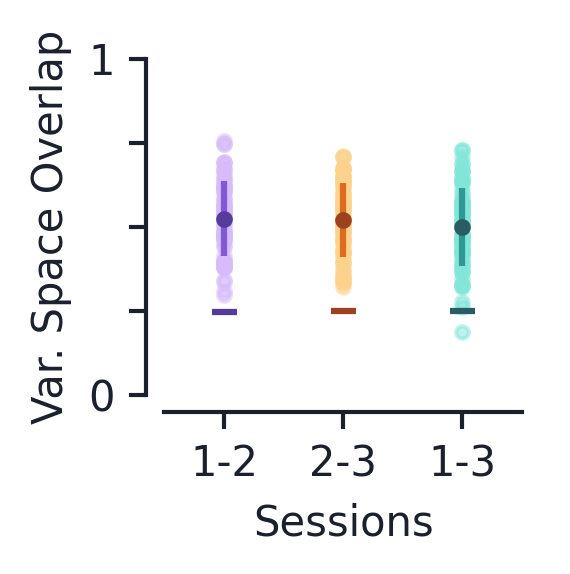

In [ ]:
# Average over divisions
plot_locs = [1, 2, 3]

# Mean over divisions
avg_12 = np.mean(np.sqrt(varspace1_varspace2_perc_experiments), axis=-1)
avg_21 = np.mean(np.sqrt(varspace2_varspace1_perc_experiments), axis=-1)
chance = np.mean(np.sqrt(varspace1_varspace2_chance_experiments), axis=-1)

print('1, 2: {:.2f} (std: {:.3f})'.format(avg_12.mean(), avg_12.std()))
print('2, 1: {:.2f} (std: {:.3f})'.format(avg_21.mean(), avg_21.std()))

fig, ax = plt.subplots(1, 1, figsize=(2,2))

drift_labels = []

for drift_idx in range(n_drifts):
    session_idx1 = drift_pair_idxs[drift_idx][0]
    session_idx2 = drift_pair_idxs[drift_idx][1]
    
    ax.scatter(plot_locs[drift_idx]*np.ones(avg_12[:, drift_idx].shape), 
               avg_12[:, drift_idx],
               color=c_vals_l[3+drift_idx],
               marker='.', alpha=0.5)

    ax.errorbar(plot_locs[drift_idx], avg_12[:, drift_idx].mean(),
                yerr=avg_12[:, drift_idx].std(), color=c_vals[3+drift_idx],
                marker='.')

    ax.scatter(plot_locs[drift_idx], avg_12[:, drift_idx].mean(),
                color=c_vals_d[3+drift_idx],
                marker='.', zorder=5)
    
    ax.scatter(plot_locs[drift_idx], chance[:, drift_idx].mean(),
                color=c_vals_d[3+drift_idx],
                marker='_', zorder=5)


    drift_labels.append('{}-{}'.format(session_idx1+1, session_idx2+1))

ax.set_xlabel('Sessions')
ax.set_ylabel('Var. Space Overlap')
ax.set_ylim([0, 1])
ax.set_xlim([0.5, 3.5])
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax.set_yticklabels([0, None, None, None, 1])
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(drift_labels)

jetplot.breathe(ax=ax)

##### No binning

This just plots things normally, without bins. (Final plots)

Filtering delta t values at: 10
Total removed: 209/219
Mag a: -0.0 (std: 0.19)
Mag b: 1.29 (std: 0.762)
Drift perc a: 0.00 (std: 0.047)
Drift perc b: 0.53 (std: 0.132)
Slope: 0.0321 (se: 0.02), r: 0.13 p: 6.14e-02
Slope: -0.0027 (se: 0.01), r: -0.01 p: 8.33e-01
Slope: -0.0066 (se: 0.00), r: -0.13 p: 5.21e-02


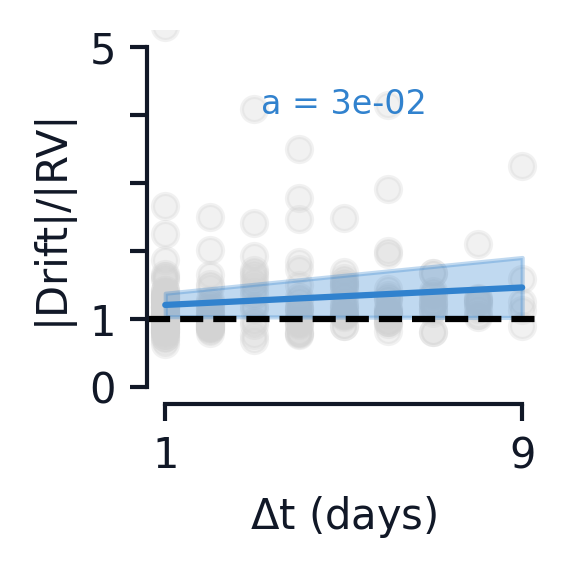

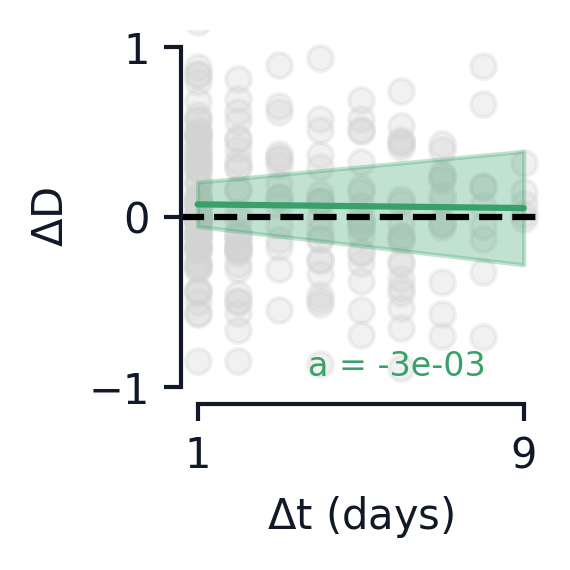

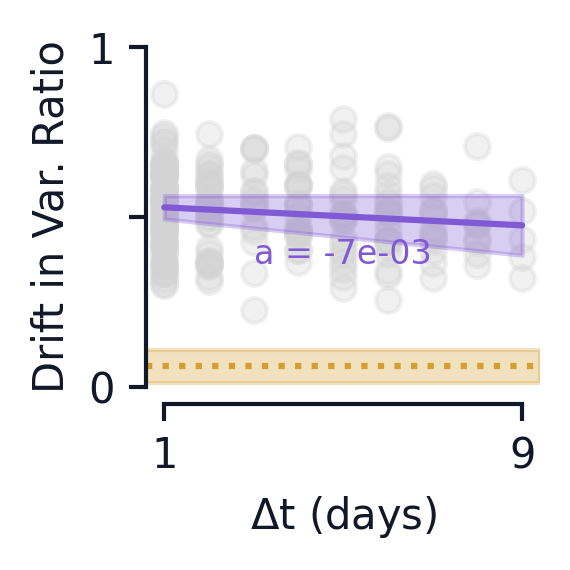

In [46]:
from sklearn.decomposition import PCA
from scipy.stats import linregress

def subspace_perc(A, b):
    """
    A: an N x M matrix, whose column space represents some M-dimensional subspace
    b: an N x P vector
    For each of b's columns, finds the percentage of its magnitude which lies in 
    the subspace formed by the columns of A (its columnspace). Then averages these together
    """
    if len(b.shape) == 1:
        b = b[:, np.newaxis]

    proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T) # N x N matrix
    b_proj = np.matmul(proj, b) # N x P martix

    norm_perc = np.linalg.norm(b_proj, axis=0)/np.linalg.norm(b, axis=0) # P dim vector

    return np.sum(norm_perc**2)/np.min((A.shape[1], b.shape[1]))

# Plots metrics by delta t

drift_pair_idxs = [[0, 1], [1, 2], [0, 2]]
n_drifts = len(drift_pair_idxs)

n_se = 1.97

delta_t_thresh = 5 # Minimum number of points for plot

drift_deltat = np.zeros((n_containers, n_drifts))
cre_line_idxs = np.zeros((n_containers, n_drifts), dtype=np.int32)

mean_mags_experiments = np.zeros((n_containers, n_sessions, n_divs))
prs_experiments = np.zeros((n_containers, n_sessions, n_divs))
delta_prs_experiments = np.zeros((n_containers, n_sessions, n_divs))
drift_mags_experiments = np.zeros((n_containers, n_drifts, n_divs))
rel_drift_mags_experiments = np.zeros((n_containers, n_drifts, n_divs))

n_subset = 10 # Number of divs to take from start and end of movie
drift_aligns_experiments = np.zeros((n_containers, n_drifts, n_subset*n_subset))

# Assumes max number of PCAs is always going to be at most n_repeats (filter for this to make it true)
n_pcas = n_repeats
pca_means_experiments = np.zeros((n_containers, n_sessions, n_divs, n_pcas))
pca_var_exp_experiments = np.zeros((n_containers, n_sessions, n_divs, n_pcas)) # Variance for each session
pca_var_exp_i_experiments = np.zeros((n_containers, n_drifts, n_divs, n_pcas)) # Variance explained of initial drift session
pca_drift_align_experiments = np.zeros((n_containers, n_drifts, n_divs, n_pcas))
pca_drift_magnitude_experiments = np.zeros((n_containers, n_drifts, n_divs, n_pcas))

drift_varspace_perc_experiments = np.zeros((n_containers, n_drifts, n_divs,))
drift_varspace_perc_experiments_chance = np.zeros((n_containers, n_drifts, n_divs,))
pca1_var_exp2_experiments = np.zeros((n_containers, n_drifts, n_divs, n_repeats))

for container_idx in range(n_containers):

    exps_container = exps[container_idx*n_sessions:(container_idx+1)*n_sessions]
    cell_ids_container = cell_ids_experiments[container_idx*n_sessions:(container_idx+1)*n_sessions]
    dff_vals_container = dff_vals_experiments[container_idx*n_sessions:(container_idx+1)*n_sessions]
    ages_containder = ages_experiments[container_idx*n_sessions:(container_idx+1)*n_sessions]

    # Find shared IDs
    unique_cell_ids = get_unique_cell_ids(cell_ids_container)
    shared_cell_idxs = get_shared_cell_idxs(unique_cell_ids, verbose=False)
    n_shared = shared_cell_idxs[0].shape[0]

    n_pcas = np.min((n_repeats, n_shared))

    means_session = np.zeros((n_sessions, n_divs, n_shared))

    pcas_session = [[] for _ in range(n_sessions)] 
    var_exp_session = np.zeros((n_sessions, n_divs, n_pcas))
    pca_means_session = np.zeros((n_drifts, n_divs, n_pcas))
    prs_session = np.zeros((n_sessions, n_divs))

    for session_idx in range(n_sessions):
        # dff_vals = np.zeros((n_repeats, n_divs, n_cells))
        dff_vals_session = dff_vals_container[session_idx][:, :, shared_cell_idxs[session_idx]]
        
        means_session[session_idx] = np.mean(dff_vals_session, axis=0)
        for div_idx in range(n_divs):
            pca_div = PCA()
            pca_div.fit(dff_vals_session[:, div_idx])
            
            # Removes ambiguity in PCA direction by making sure all means (along PC directions) are positive
            pca_dir_signs = np.sign(np.mean(np.matmul(dff_vals_session[:, div_idx], pca_div.components_.T), axis=0))
            for pca_idx, pca_dir in enumerate(pca_div.components_):
                pca_div.components_[pca_idx, :] = pca_dir_signs[pca_idx] * pca_dir        
            pcas_session[session_idx].append(pca_div)
            
            pca_means_session[session_idx, div_idx] = (
                np.mean(np.matmul(dff_vals_session[:, div_idx], pca_div.components_.T), axis=0) /
                np.linalg.norm(means_session[session_idx, div_idx])
            )
            var_exp_session[session_idx, div_idx] = pca_div.explained_variance_ratio_

            prs_session[session_idx, div_idx] = participation_ratio_vector(
                pca_div.explained_variance_ratio_
            )

    var_exp_init_session = np.zeros((n_drifts, n_divs, n_pcas))
    drifts_session = np.zeros((n_drifts, n_divs, n_shared))
    rel_drift_mag_session = np.zeros((n_drifts, n_divs,))
    delta_pr_session = np.zeros((n_drifts, n_divs,))
    drift_varspace_perc_session = np.zeros((n_drifts, n_divs,))
    drift_varspace_perc_session_chance = np.zeros((n_drifts, n_divs,))

    pca_drift_align = np.zeros((n_drifts, n_divs, n_pcas))
    pca_drift_magnitude = np.zeros((n_drifts, n_divs, n_pcas))

    pca1_var_exp2_session = np.zeros((n_drifts, n_divs, n_repeats))

    # Pairwise alignment, 
    drift_aligns_session = np.zeros((n_drifts, n_subset*n_subset))

    for drift_idx in range(n_drifts):
        session_idx1 = drift_pair_idxs[drift_idx][0]
        session_idx2 = drift_pair_idxs[drift_idx][1]

        var_exp_init_session[drift_idx] = var_exp_session[session_idx1]

        drift_deltat[container_idx, drift_idx] = (
            ages_containder[session_idx2] - ages_containder[session_idx1] 
        )
        # Cre lines for all drifts are the same, so just gets cre line from first session
        cre_line_idxs[container_idx, drift_idx] = cre_lines.index(
            cre_lines_experiments[container_idx*n_sessions])

        drifts_session[drift_idx] = (means_session[session_idx2] - 
                        means_session[session_idx1])        
        delta_pr_session[drift_idx] = (prs_session[session_idx2] - 
                        prs_session[session_idx1])

        rel_drift_mag_session[drift_idx] = np.linalg.norm(
            drifts_session[drift_idx], axis=-1
            )/np.linalg.norm(
            means_session[session_idx1], axis=-1
        )

        for div_idx in range(n_divs):
            # Drift in the PCA coordinates (of starting session)
            pca_drift = np.matmul( 
                pcas_session[session_idx1][div_idx].components_,
                drifts_session[drift_idx, div_idx]
            )
            for pca_idx in range(n_pcas):
                pca_drift_align[drift_idx, div_idx, pca_idx] = get_align_angle(
                    drifts_session[drift_idx, div_idx],
                    pcas_session[session_idx1][div_idx].components_[pca_idx]
                )
                # pca_drift_magnitude[drift_idx, div_idx, pca_idx] = (
                #     np.abs(pca_drift[pca_idx])
                # )
                pca_drift_magnitude[drift_idx, div_idx, pca_idx] = (
                    np.abs(pca_drift[pca_idx]) / np.linalg.norm(
                        drifts_session[drift_idx, div_idx]
                    )
                )

            # Drift in variational space
            dim_session1 = int(np.ceil(prs_session[session_idx1, div_idx])) # Dimension of session 1 var space
            drift_varspace_perc_session[drift_idx, div_idx] = subspace_perc(
                pcas_session[session_idx1][div_idx].components_[:dim_session1].T,
                drifts_session[drift_idx, div_idx]
            )

            drift_varspace_perc_session_chance[drift_idx, div_idx] = (
                dim_session1 / n_shared) 

            data1 = dff_vals_container[session_idx1][:, div_idx, shared_cell_idxs[session_idx1]]
            data2 = dff_vals_container[session_idx2][:, div_idx, shared_cell_idxs[session_idx2]]

            # Flow of variation
            pca1_data1 = np.matmul(data1, pcas_session[session_idx1][div_idx].components_.T)
            pca1_data2 = np.matmul(data2, pcas_session[session_idx1][div_idx].components_.T)
            
            pca1_data1_cov = np.cov(pca1_data1.T)
            pca1_data1_vars = np.diag(pca1_data1_cov)
            pca1_data1_vars_ratio = pca1_data1_vars/np.sum(pca1_data1_vars)
            pca1_data2_cov = np.cov(pca1_data2.T)
            pca1_data2_vars = np.diag(pca1_data2_cov)
            pca1_var_exp2_session[drift_idx, div_idx] = pca1_data2_vars/np.sum(pca1_data2_vars)

        # Pairwise drift aligns
        count_idx = 0
        for div_idx1 in range(n_subset):
            for div_idx2 in range(n_divs - n_subset, n_divs):
                drift_aligns_session[drift_idx, count_idx] = get_align_angle(
                    drifts_session[drift_idx, div_idx1],
                    drifts_session[drift_idx, div_idx2] 
                )
                count_idx+= 1

    mean_mags_experiments[container_idx] = np.linalg.norm(means_session, axis=-1)
    prs_experiments[container_idx] = prs_session
    delta_prs_experiments[container_idx] = delta_pr_session
    drift_mags_experiments[container_idx] = np.linalg.norm(drifts_session, axis=-1)
    rel_drift_mags_experiments[container_idx] = rel_drift_mag_session
    
    pca_var_exp_experiments[container_idx] = var_exp_session
    pca_var_exp_i_experiments[container_idx] = var_exp_init_session
    pca_means_experiments[container_idx] = pca_means_session
    pca_drift_align_experiments[container_idx, :, :, :n_pcas] = pca_drift_align
    pca_drift_magnitude_experiments[container_idx, :, :, :n_pcas] = pca_drift_magnitude
    drift_aligns_experiments[container_idx] = drift_aligns_session
    pca1_var_exp2_experiments[container_idx] = pca1_var_exp2_session

    drift_varspace_perc_experiments[container_idx] = drift_varspace_perc_session
    drift_varspace_perc_experiments_chance[container_idx] = drift_varspace_perc_session_chance

# Average over all divisions
# ax2[0].plot(np.mean(rel_drift_mags_bins, axis=-1), color=c_vals[0])

# # Average over all drift examples
# avg_pr_bins = np.array([np.mean(bin_vals) for bin_vals in prs_bins])
# std_pr_bins = np.array([np.std(bin_vals) for bin_vals in prs_bins])
# ax2[1].plot(time_bins[:-1], avg_pr_bins, color=c_vals[0])
# ax2[1].fill_between(time_bins[:-1], avg_pr_bins-std_pr_bins,
#                     avg_pr_bins+std_pr_bins, color=c_vals[0], alpha=0.3)

def scatter_with_fit(delta_ts, y_vals, ax, c_idx):
    X = delta_ts.flatten()[delta_t_filter] 
    y = y_vals.flatten()[delta_t_filter] 

    # y = y[X < 11.0]
    # X = X[X < 11.0]

    ax.scatter(X, y, color='lightgrey', alpha=0.3)
    
    reg = linregress(X, y)
    print('Slope: {:.4f} (se: {:.2f}), r: {:.2f} p: {:.2e}'.format(
        reg.slope, reg.stderr, reg.rvalue, reg.pvalue))
    reg_plot_X = np.linspace(np.min(X), np.max(X), num=50)
    reg_plot_y = reg.slope * reg_plot_X + reg.intercept
    reg_plot_min_y = ((reg.slope - n_se* reg.stderr) * reg_plot_X + 
                    (reg.intercept - n_se * reg.intercept_stderr))
    reg_plot_max_y = ((reg.slope + n_se * reg.stderr) * reg_plot_X + 
                    (reg.intercept + n_se * reg.intercept_stderr))
    ax.fill_between(reg_plot_X, reg_plot_min_y, reg_plot_max_y, 
                        color=c_vals[c_idx], alpha=0.3)
    ax.plot(reg_plot_X, reg_plot_y, color=c_vals[c_idx])
    
    return reg

fit_X = drift_deltat.flatten()
# Number of occurences for each delta t:
delta_t_cutoff = None
for delta_t_val in range(1, int(np.max(fit_X)+1)):
    if np.sum(fit_X == delta_t_val) < delta_t_thresh and delta_t_cutoff == None:
        delta_t_cutoff = delta_t_val

fit_X = drift_deltat.flatten()
if delta_t_thresh == None:
    delta_t_filter = np.ones(fit_X.shape)
else:
    print('Filtering delta t values at:', delta_t_cutoff)
    delta_t_filter = fit_X < delta_t_cutoff
    print('Total removed: {}/{}'.format(np.sum(delta_t_filter), fit_X.shape[0]))

max_delta_t = np.max(fit_X[delta_t_filter])

# Fit to individual mice first for ANN comparison. Note that this does not average over divisions anymore
reg4_slopes = []
reg4_intercepts = []
reg6_slopes = []
reg6_intercepts = []
for container_idx in range(n_containers): # Fits over drifts, divisions, and PCs
    # X = np.repeat(drift_deltat[container_idx, :, np.newaxis], n_divs, axis=-1).flatten()
    # y4 = rel_drift_mags_experiments[container_idx].flatten()
    # y5 = drift_varspace_perc_experiments[container_idx].flatten()
    # y6 = drift_varspace_perc_experiments[container_idx].flatten()

    X = drift_deltat[container_idx]
    y4 = np.mean(rel_drift_mags_experiments[container_idx], axis=-1)
    y5 = np.mean(drift_varspace_perc_experiments[container_idx], axis=-1)
    y6 = np.mean(drift_varspace_perc_experiments[container_idx], axis=-1)

    reg4 = linregress(X, y4)
    reg5 = linregress(X, y5)
    reg6 = linregress(X, y6)

    reg4_slopes.append(reg4.slope)
    reg4_intercepts.append(reg4.intercept)
    reg6_slopes.append(reg6.slope)
    reg6_intercepts.append(reg6.intercept)

print('Mag a: {:.1f} (std: {:.2f})'.format(np.mean(reg4_slopes), np.std(reg4_slopes)))
print('Mag b: {:.2f} (std: {:.3f})'.format(np.mean(reg4_intercepts), np.std(reg4_intercepts)))
print('Drift perc a: {:.2f} (std: {:.3f})'.format(np.mean(reg6_slopes), np.std(reg6_slopes)))
print('Drift perc b: {:.2f} (std: {:.3f})'.format(np.mean(reg6_intercepts), np.std(reg6_intercepts)))

# Average over divisions
avg_rel_drift_mags = np.mean(rel_drift_mags_experiments, axis=-1)
avg_drift_varspace_perc = np.mean(drift_varspace_perc_experiments, axis=-1)
avg_delta_prs = np.mean(delta_prs_experiments, axis=-1)

cre_colors = [c_vals_l[cre_idx] for cre_idx in cre_line_idxs.flatten()]

fig, ax = plt.subplots(1, 1, figsize=(2,2))

reg4 = scatter_with_fit(drift_deltat, avg_rel_drift_mags, ax, 1)

ax.text(0.5, 0.8, 'a = {:.0e}'.format(reg4.slope), 
           horizontalalignment='center', verticalalignment='center', 
           color=c_vals[1], fontsize=8, transform=ax.transAxes)

ax.set_xlabel('$\Delta$t (days)')
ax.set_ylabel('|Drift|/|RV|')
ax.axhline(1.0, color='k', linestyle='dashed')
ax.set_ylim([0, 5])
ax.set_xlim([1, max_delta_t])
ax.set_yticks([0, 1, 2, 3, 4, 5])
ax.set_yticklabels([0, 1, None, None, None, 5])
ax.set_xticks([1, max_delta_t])

jetplot.breathe(ax=ax)

fig, ax = plt.subplots(1, 1, figsize=(2,2))

reg5 = scatter_with_fit(drift_deltat, avg_delta_prs, ax, 2)

ax.text(0.6, 0.1, 'a = {:.0e}'.format(reg5.slope), 
           horizontalalignment='center', verticalalignment='center', 
           color=c_vals[2], fontsize=8, transform=ax.transAxes)

ax.set_xlabel('$\Delta$t (days)')
ax.set_ylabel('$\Delta$D')
ax.axhline(0.0, color='k', linestyle='dashed')
ax.set_ylim([-1, 1])
ax.set_xlim([1, max_delta_t])
ax.set_yticks([-1, 0, 1])
ax.set_xticks([1, max_delta_t])

jetplot.breathe(ax=ax)

fig, ax = plt.subplots(1, 1, figsize=(2,2))

reg6 = scatter_with_fit(drift_deltat, avg_drift_varspace_perc, ax, 3)

ax.text(0.5, 0.4, 'a = {:.0e}'.format(reg6.slope), 
           horizontalalignment='center', verticalalignment='center', 
           color=c_vals[3], fontsize=8, transform=ax.transAxes)

# Mean over divisions and drifts
avg_drift_perc_chance = np.mean(drift_varspace_perc_experiments_chance, axis=(1,2))
ax.axhspan( 
    (avg_drift_perc_chance.mean()-avg_drift_perc_chance.std()),
    (avg_drift_perc_chance.mean()+avg_drift_perc_chance.std()), 
    color=c_vals[8], alpha=0.3
)
ax.axhline(avg_drift_perc_chance.mean(), linestyle='dotted', color=c_vals[8])

ax.set_xlabel('$\Delta$t (days)')
ax.set_ylabel('Drift in Var. Ratio')
ax.set_ylim([0, 1])
ax.set_xlim([1, max_delta_t])
ax.set_yticks([0, 0.5, 1])
ax.set_yticklabels([0, None, 1])
ax.set_xticks([1, max_delta_t])

jetplot.breathe(ax=ax)

Angle a: 33.1 (std: 12.44)
Angle r: 0.80 (std: 0.158)
Var flow a: 0.30 (std: 0.118)
Var flow r: 0.85 (std: 0.135)
Fit: Slope - 0.62 (se: 0.01), r: 0.92 p: 0.00e+00
  Alt fit - Slope: 0.06 (se: 0.00), r: 0.81 p: 0.00e+00
  Rtest, mean: 0.92 (std: 0.009)
Fit - Slope: 32.52 (se: 0.64), r: 0.75 p: 0.00e+00
  Alt fit - Slope: 0.06 (se: 0.00), r: 0.81 p: 0.00e+00
  Rtest, mean: 0.75 (std: 0.015)
Slope: 0.27 (se: 0.00), r: 0.81 p: 0.00e+00
  Rtest, mean: 0.81 (std: 0.013)


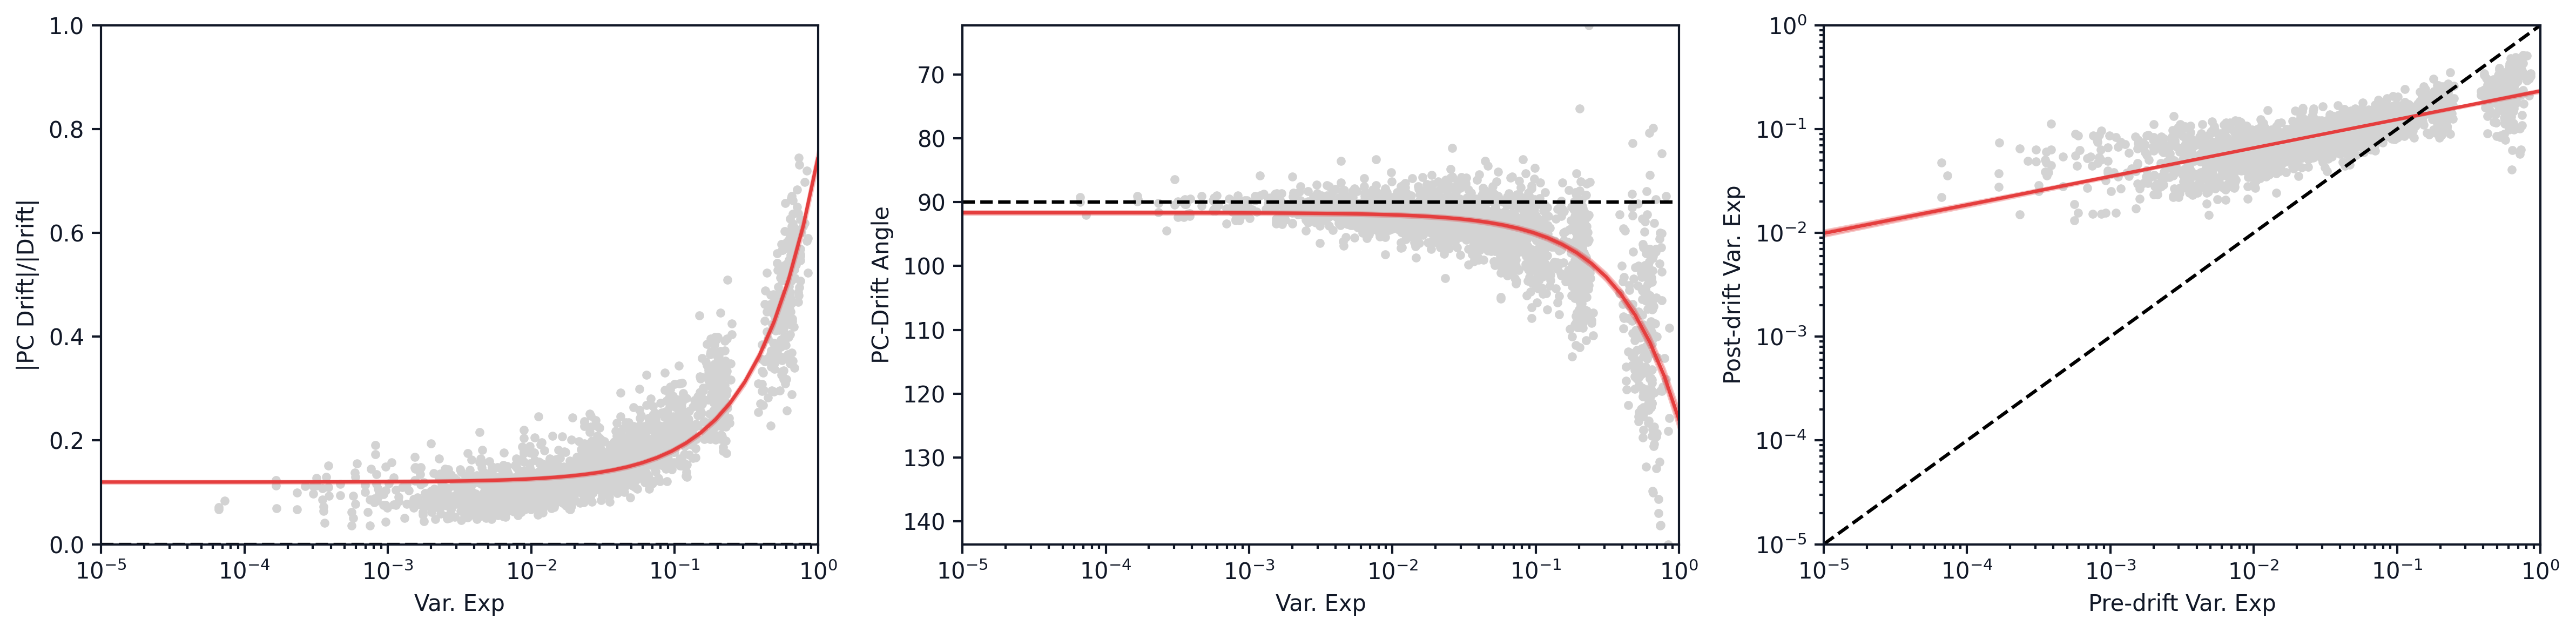

In [47]:
def predict_rdist(X, y, reg, n_trials = 1000):
    r_vals = []
    sst = np.sum((y - np.mean(y))**2)
    sst = np.sum((y - np.mean(y))**2)
    for _ in range(n_trials):
        rand_slope = np.random.normal(reg.slope, reg.stderr)
        rand_intercept = np.random.normal(reg.intercept, reg.intercept_stderr)
        y_pred = rand_slope * X + rand_intercept
        ssreg = np.sum((y_pred - np.mean(y))**2)
        r_vals.append(np.sqrt(ssreg/sst))

    print('  Rtest, mean: {:.2f} (std: {:.3f})'.format(np.mean(r_vals), np.std(r_vals)))

    return np.mean(r_vals), np.std(r_vals)

min_var_exp = 1e-5

# Fits for mice individually first, this is for matching onto ANN data
reg2_slopes = []
reg2_rvalues = []
reg3_slopes = []
reg3_rvalues = []
for container_idx in range(n_containers): # Fits over drifts, divisions, and PCs
    X = np.mean(pca_var_exp_i_experiments[container_idx], axis=1).flatten()
    y0 = np.mean(pca_drift_magnitude_experiments[container_idx], axis=1).flatten()
    y1 = np.mean(pca_drift_align_experiments[container_idx], axis=1).flatten()
    y2 = np.mean(pca1_var_exp2_experiments[container_idx], axis=1).flatten()

    # Filters for minimum variance explained
    y0= y0[X > min_var_exp]
    y1= y1[X > min_var_exp]
    y2 = y2[X > min_var_exp]
    X = X[X > min_var_exp]

    reg1 = linregress(X, y0)
    reg2 = linregress(X, y1)
    reg3 = linregress(np.log(X), np.log(y2))

    reg2_slopes.append(reg2.slope)
    reg2_rvalues.append(reg2.rvalue)
    reg3_slopes.append(reg3.slope)
    reg3_rvalues.append(reg3.rvalue)

print('Angle a: {:.1f} (std: {:.2f})'.format(np.mean(reg2_slopes), np.std(reg2_slopes)))
print('Angle r: {:.2f} (std: {:.3f})'.format(np.mean(reg2_rvalues), np.std(reg2_rvalues)))
print('Var flow a: {:.2f} (std: {:.3f})'.format(np.mean(reg3_slopes), np.std(reg3_slopes)))
print('Var flow r: {:.2f} (std: {:.3f})'.format(np.mean(reg3_rvalues), np.std(reg3_rvalues)))

# Average over divisions (e.g. classes)
avg_pca_var_exp = np.mean(pca_var_exp_experiments, axis=2)
avg_pca_var_i_exp = np.mean(pca_var_exp_i_experiments, axis=2)
avg_drift_align = np.mean(pca_drift_align_experiments, axis=2)
avg_drift_mag = np.mean(pca_drift_magnitude_experiments, axis=2)
avg_var_flow = np.mean(pca1_var_exp2_experiments, axis=2)
avg_pca_means = np.mean(pca_means_experiments, axis=2)

X = avg_pca_var_i_exp.flatten()
y0 = avg_drift_mag.flatten()
y1 = avg_drift_align.flatten()
y2 = avg_var_flow.flatten()

X2 = avg_pca_var_exp.flatten()
y3 = avg_pca_means.flatten() # PCA vs means uses variance of corresponding session

# Filters for minimum variance explained
y0= y0[X > min_var_exp]
y1= y1[X > min_var_exp]
y2 = y2[X > min_var_exp]
y3 = y3[X2 > min_var_exp]
X = X[X > min_var_exp]
X2 = X2[X2 > min_var_exp]

fig, ax = plt.subplots(1, 3, figsize=(16,4))

ax[0].scatter(X, y0, color='lightgrey', marker='.')
ax[1].scatter(X, y1, color='lightgrey', marker='.')
ax[2].scatter(X, y2, color='lightgrey', marker='.')

reg = linregress(X, y0)
reg1 = reg # For saving
print('Fit: Slope - {:.2f} (se: {:.2f}), r: {:.2f} p: {:.2e}'.format(
    reg.slope, reg.stderr, reg.rvalue, reg.pvalue))
alt_reg = linregress(np.log(X), y0)
print('  Alt fit - Slope: {:.2f} (se: {:.2f}), r: {:.2f} p: {:.2e}'.format(
    alt_reg.slope, alt_reg.stderr, alt_reg.rvalue, alt_reg.pvalue))
reg_plot_X = np.logspace(np.log10(min_var_exp), 0, num=50)
reg_plot_y = reg.slope * reg_plot_X + reg.intercept
reg_plot_min_y = ((reg.slope - n_se* reg.stderr) * reg_plot_X + 
                (reg.intercept - n_se * reg.intercept_stderr))
reg_plot_max_y = ((reg.slope + n_se * reg.stderr) * reg_plot_X + 
                (reg.intercept + n_se * reg.intercept_stderr))
ax[0].fill_between(reg_plot_X, reg_plot_min_y, reg_plot_max_y, 
                    color=c_vals[0], alpha=0.3)
ax[0].plot(reg_plot_X, reg_plot_y, color=c_vals[0])
_, reg1_rstd = predict_rdist(X, y0, reg1)

reg = linregress(X, y1)
reg2 = reg
print('Fit - Slope: {:.2f} (se: {:.2f}), r: {:.2f} p: {:.2e}'.format(
    reg.slope, reg.stderr, reg.rvalue, reg.pvalue))
alt_reg = linregress(np.log(X), y0)
print('  Alt fit - Slope: {:.2f} (se: {:.2f}), r: {:.2f} p: {:.2e}'.format(
    alt_reg.slope, alt_reg.stderr, alt_reg.rvalue, alt_reg.pvalue))
reg_plot_X = np.logspace(np.log10(min_var_exp), 0, num=50)
reg_plot_y = reg.slope * reg_plot_X + reg.intercept
reg_plot_min_y = ((reg.slope - n_se* reg.stderr) * reg_plot_X + 
                (reg.intercept - n_se * reg.intercept_stderr))
reg_plot_max_y = ((reg.slope + n_se * reg.stderr) * reg_plot_X + 
                (reg.intercept + n_se * reg.intercept_stderr))
ax[1].fill_between(reg_plot_X, reg_plot_min_y, reg_plot_max_y, 
                    color=c_vals[0], alpha=0.3)
ax[1].plot(reg_plot_X, reg_plot_y, color=c_vals[0])
_, reg2_rstd = predict_rdist(X, y1, reg2)

reg = linregress(np.log(X), np.log(y2))
reg3 = reg
print('Slope: {:.2f} (se: {:.2f}), r: {:.2f} p: {:.2e}'.format(
    reg.slope, reg.stderr, reg.rvalue, reg.pvalue))
reg_plot_X = np.logspace(np.log10(min_var_exp), 0, num=50)
reg_plot_y = np.exp(reg.slope * np.log(reg_plot_X) + reg.intercept)
reg_plot_min_y = np.exp((reg.slope - n_se* reg.stderr) * np.log(reg_plot_X) + 
                (reg.intercept - n_se * reg.intercept_stderr))
reg_plot_max_y = np.exp((reg.slope + n_se * reg.stderr) * np.log(reg_plot_X) + 
                (reg.intercept + n_se * reg.intercept_stderr))
ax[2].fill_between(reg_plot_X, reg_plot_min_y, reg_plot_max_y, 
                    color=c_vals[0], alpha=0.3)
ax[2].plot(reg_plot_X, reg_plot_y, color=c_vals[0])
_, reg3_rstd = predict_rdist(np.log(X), np.log(y2), reg3)

ax[0].axhline(0.0, color='k', linestyle='dashed')
ax[0].set_xlabel('Var. Exp')
ax[0].set_ylabel('|PC Drift|/|Drift|')
ax[0].set_xlim([min_var_exp, 1.0])
ax[0].set_xscale('log')
ax[0].set_ylim([0, 1])

ax[1].axhline(90.0, color='k', linestyle='dashed')
ax[1].set_xlabel('Var. Exp')
ax[1].set_ylabel('PC-Drift Angle')
ax[1].set_xlim([min_var_exp, 1.0])
ax[1].set_xscale('log')
ax[1].invert_yaxis()

ax[2].plot(reg_plot_X, reg_plot_X, color='k', linestyle='dashed')
ax[2].set_xlabel('Pre-drift Var. Exp')
ax[2].set_ylabel('Post-drift Var. Exp')
ax[2].set_xlim([min_var_exp, 1.0])
ax[2].set_ylim([min_var_exp, 1.0])
ax[2].set_xscale('log')
ax[2].set_yscale('log')

Fit: Slope - 0.62 (se: 0.01), r: 0.92 p: 0.00e+00
Alt fit - Slope: 0.06 (se: 0.00), r: 0.81 p: 0.00e+00
Fit - Slope: 32.52 (se: 0.64), r: 0.75 p: 0.00e+00
Alt fit - Slope: 0.06 (se: 0.00), r: 0.81 p: 0.00e+00
Slope: 0.27 (se: 0.00), r: 0.81 p: 0.00e+00
Fit - Slope: 0.45 (se: 0.00), r: 0.95 p: 0.00e+00
Alt fit - Slope: 0.28 (se: 0.00), r: 0.85 p: 0.00e+00


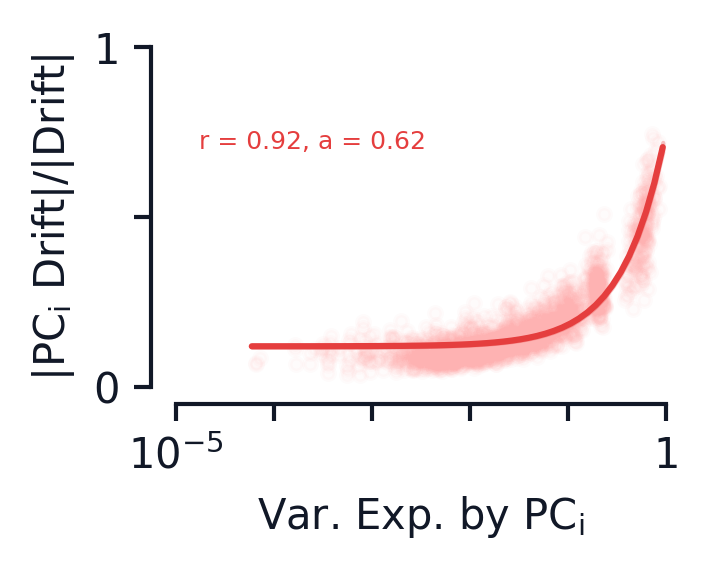

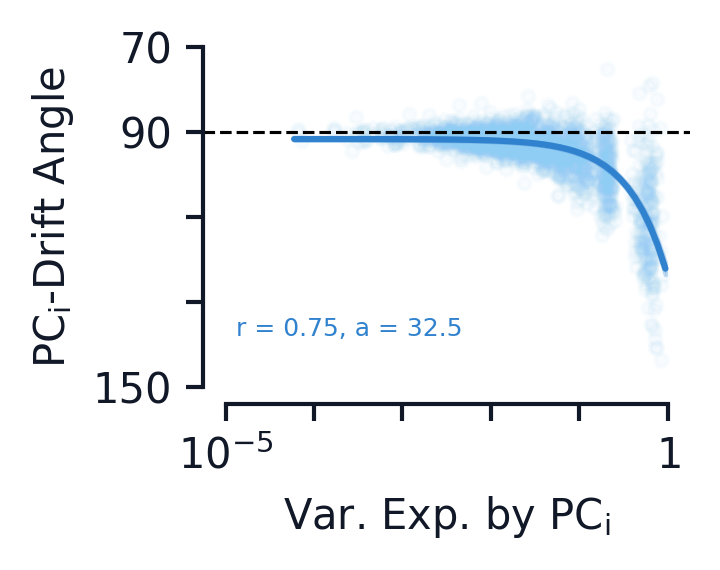

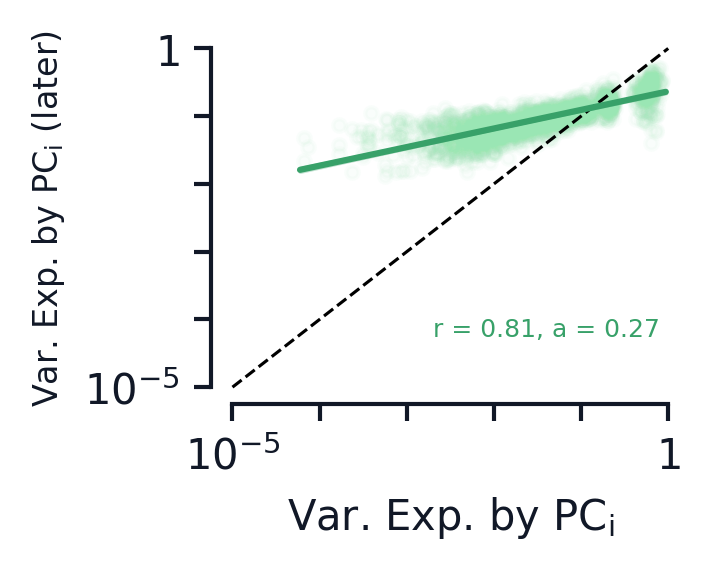

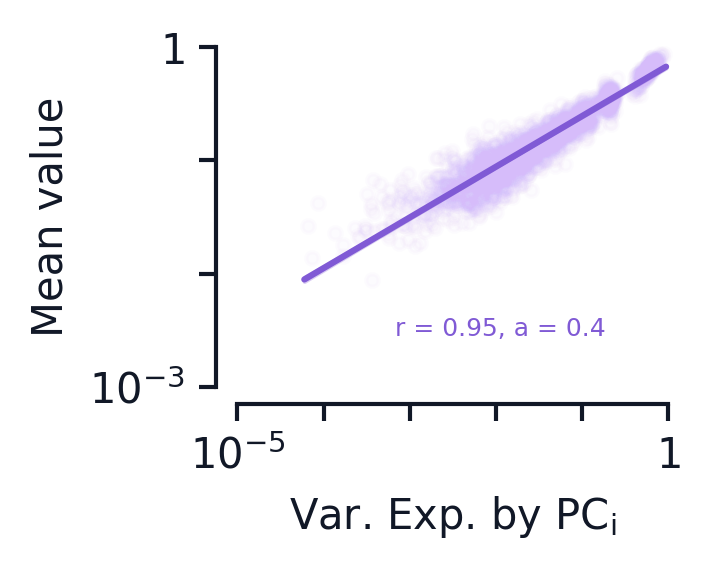

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,2))

ax.scatter(X, y0, color=c_vals_l[0], marker='.', alpha=0.05,
           zorder=-5)

reg = linregress(X, y0)
reg1 = reg # For saving
print('Fit: Slope - {:.2f} (se: {:.2f}), r: {:.2f} p: {:.2e}'.format(
    reg.slope, reg.stderr, reg.rvalue, reg.pvalue))
alt_reg = linregress(np.log(X), y0)
print('Alt fit - Slope: {:.2f} (se: {:.2f}), r: {:.2f} p: {:.2e}'.format(
    alt_reg.slope, alt_reg.stderr, alt_reg.rvalue, alt_reg.pvalue))
reg_plot_X = np.logspace(np.log10(0.9*np.min(X)), np.log10(1.1*np.max(X)), num=50)
reg_plot_y = reg.slope * reg_plot_X + reg.intercept
reg_plot_min_y = ((reg.slope - n_se* reg.stderr) * reg_plot_X + 
                (reg.intercept - n_se * reg.intercept_stderr))
reg_plot_max_y = ((reg.slope + n_se * reg.stderr) * reg_plot_X + 
                (reg.intercept + n_se * reg.intercept_stderr))
ax.fill_between(reg_plot_X, reg_plot_min_y, reg_plot_max_y, 
                    color=c_vals[0], alpha=0.3, zorder=0)
ax.plot(reg_plot_X, reg_plot_y, color=c_vals[0], zorder=5)

ax.set_xlabel('Var. Exp. by PC$_i$')
ax.set_ylabel('|PC$_i$ Drift|/|Drift|')
ax.set_ylim([0, 1])
ax.set_yticks([0, 0.5, 1])
ax.set_yticklabels([0, None, 1])
ax.set_xlim([min_var_exp, 1.0])
ax.set_xscale('log')
ax.set_xticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax.set_xticklabels(['$10^{-5}$', None, None, None, None, '$1$'])

ax.text(0.3, 0.7, 'r = {:.2f}, a = {:.2f}'.format(reg.rvalue, reg.slope), 
           horizontalalignment='center', verticalalignment='center', 
           color=c_vals[0], fontsize=6, transform=ax.transAxes)

jetplot.breathe(ax=ax)

fig, ax = plt.subplots(1, 1, figsize=(2.5,2))

ax.scatter(X, y1, color=c_vals_l[1], marker='.', alpha=0.05,
           zorder=-5)

reg = linregress(X, y1)
reg2 = reg # For saving
print('Fit - Slope: {:.2f} (se: {:.2f}), r: {:.2f} p: {:.2e}'.format(
    reg.slope, reg.stderr, reg.rvalue, reg.pvalue))
alt_reg = linregress(np.log(X), y0)
print('Alt fit - Slope: {:.2f} (se: {:.2f}), r: {:.2f} p: {:.2e}'.format(
    alt_reg.slope, alt_reg.stderr, alt_reg.rvalue, alt_reg.pvalue))
reg_plot_X = np.logspace(np.log10(0.9*np.min(X)), np.log10(1.1*np.max(X)), num=50)
reg_plot_y = reg.slope * reg_plot_X + reg.intercept
reg_plot_min_y = ((reg.slope - n_se* reg.stderr) * reg_plot_X + 
                (reg.intercept - n_se * reg.intercept_stderr))
reg_plot_max_y = ((reg.slope + n_se * reg.stderr) * reg_plot_X + 
                (reg.intercept + n_se * reg.intercept_stderr))
ax.fill_between(reg_plot_X, reg_plot_min_y, reg_plot_max_y, 
                    color=c_vals[1], alpha=0.3, zorder=0)
ax.plot(reg_plot_X, reg_plot_y, color=c_vals[1], zorder=5)

ax.text(0.3, 0.2, 'r = {:.2f}, a = {:.1f}'.format(reg.rvalue, reg.slope), 
           horizontalalignment='center', verticalalignment='center', 
           color=c_vals[1], fontsize=6, transform=ax.transAxes)

ax.axhline(90.0, color='k', linestyle='dashed', linewidth=0.75)
ax.set_xlabel('Var. Exp. by PC$_i$')
ax.set_ylabel('PC$_i$-Drift Angle')
ax.set_ylim([70, 150])
ax.set_yticks([70, 90, 110, 130, 150])
ax.set_yticklabels([70, 90, None, None, 150])
ax.set_xlim([min_var_exp, 1.0])
ax.set_xscale('log')
ax.set_xticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax.set_xticklabels(['$10^{-5}$', None, None, None, None, '$1$'])
ax.invert_yaxis()

jetplot.breathe(ax=ax)

fig, ax = plt.subplots(1, 1, figsize=(2.5,2))

ax.scatter(X, y2, color=c_vals_l[2], marker='.', alpha=0.05,
           zorder=-5)
reg = linregress(np.log(X), np.log(y2))
reg3 = reg # For saving
print('Slope: {:.2f} (se: {:.2f}), r: {:.2f} p: {:.2e}'.format(
    reg.slope, reg.stderr, reg.rvalue, reg.pvalue))
reg_plot_X = np.logspace(np.log10(0.9*np.min(X)), np.log10(1.1*np.max(X)), num=50)
reg_plot_y = np.exp(reg.slope * np.log(reg_plot_X) + reg.intercept)
reg_plot_min_y = np.exp((reg.slope - n_se* reg.stderr) * np.log(reg_plot_X) + 
                (reg.intercept - n_se * reg.intercept_stderr))
reg_plot_max_y = np.exp((reg.slope + n_se * reg.stderr) * np.log(reg_plot_X) + 
                (reg.intercept + n_se * reg.intercept_stderr))
ax.fill_between(reg_plot_X, reg_plot_min_y, reg_plot_max_y, 
                    color=c_vals[2], alpha=0.3, zorder=0)
ax.plot(reg_plot_X, reg_plot_y, color=c_vals[2], zorder=5)

ax.text(0.7, 0.2, 'r = {:.2f}, a = {:.2f}'.format(reg.rvalue, reg.slope), 
           horizontalalignment='center', verticalalignment='center', 
           color=c_vals[2], fontsize=6, transform=ax.transAxes)

diag_X = np.logspace(np.log10(min_var_exp), 0, num=50)
ax.plot(diag_X, diag_X, color='k', linestyle='dashed', linewidth=0.75)
ax.set_xlabel('Var. Exp. by PC$_i$')
ax.set_ylabel('Var. Exp. by PC$_i$ (later)', fontsize=8)
ax.set_xlim([min_var_exp, 1.0])
ax.set_xscale('log')
ax.set_xticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax.set_xticklabels(['$10^{-5}$', None, None, None, None, '$1$'])
ax.set_ylim([min_var_exp, 1.0])
ax.set_yscale('log')
ax.set_yticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax.set_yticklabels(['$10^{-5}$', None, None, None, None, '$1$'])
jetplot.breathe(ax=ax)

# Plots of means versus variance explained
fig, ax = plt.subplots(1, 1, figsize=(2.5,2))

ax.scatter(X2, y3, color=c_vals_l[3], marker='.', alpha=0.05,
           zorder=-5)

reg = linregress(np.log(X2), np.log(y3))
reg7 = reg # For saving
print('Fit - Slope: {:.2f} (se: {:.2f}), r: {:.2f} p: {:.2e}'.format(
    reg.slope, reg.stderr, reg.rvalue, reg.pvalue))
alt_reg = linregress(np.log(X), np.log(y0))
print('Alt fit - Slope: {:.2f} (se: {:.2f}), r: {:.2f} p: {:.2e}'.format(
    alt_reg.slope, alt_reg.stderr, alt_reg.rvalue, alt_reg.pvalue))
reg_plot_X = np.logspace(np.log10(0.9*np.min(X)), np.log10(1.1*np.max(X)), num=50)
reg_plot_y = np.exp(reg.slope * np.log(reg_plot_X) + reg.intercept)
reg_plot_min_y = np.exp((reg.slope - n_se* reg.stderr) * np.log(reg_plot_X) + 
                (reg.intercept - n_se * reg.intercept_stderr))
reg_plot_max_y = np.exp((reg.slope + n_se * reg.stderr) * np.log(reg_plot_X) + 
                (reg.intercept + n_se * reg.intercept_stderr))
ax.fill_between(reg_plot_X, reg_plot_min_y, reg_plot_max_y, 
                    color=c_vals[3], alpha=0.3, zorder=0)
ax.plot(reg_plot_X, reg_plot_y, color=c_vals[3], zorder=5)

ax.text(0.6, 0.2, 'r = {:.2f}, a = {:.1f}'.format(reg.rvalue, reg.slope), 
           horizontalalignment='center', verticalalignment='center', 
           color=c_vals[3], fontsize=6, transform=ax.transAxes)

ax.set_xlabel('Var. Exp. by PC$_i$')
ax.set_ylabel('Mean value')
# ax.set_ylim([0, 1])
# ax.set_yticks([0, 0.5, 1])
# ax.set_yticklabels([0, 0.5, 1])
ax.set_xlim([min_var_exp, 1.0])
ax.set_xscale('log')
ax.set_ylim([1e-3, 1.0])
ax.set_yscale('log')
ax.set_xticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax.set_xticklabels(['$10^{-5}$', None, None, None, None, '$1$'])
ax.set_yticks([1e-3, 1e-2, 1e-1, 1e0])
ax.set_yticklabels(['$10^{-3}$', None, None, '$1$'])

jetplot.breathe(ax=ax)

Plot vs PC dimension instead

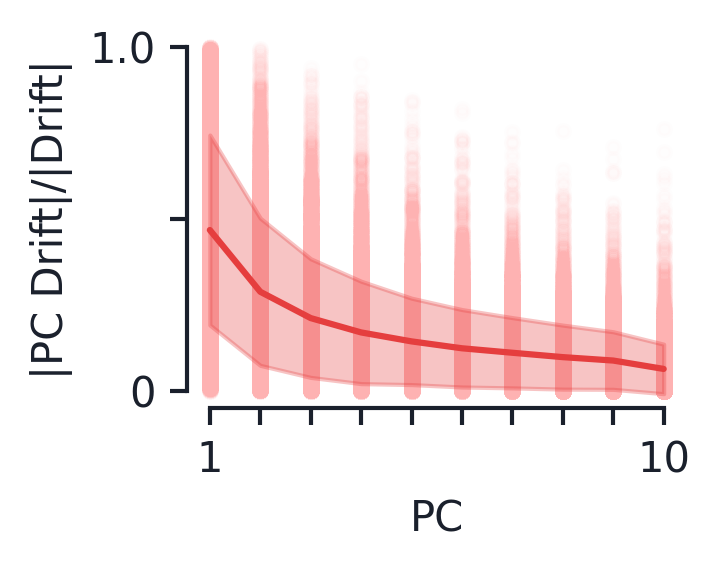

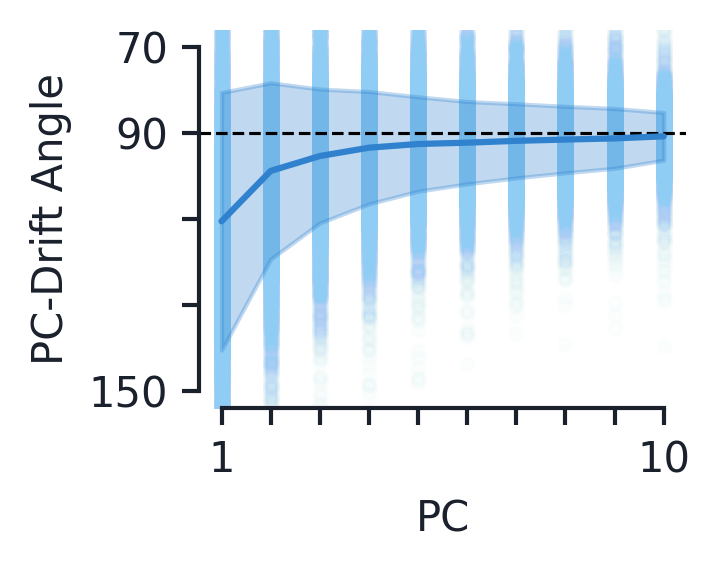

In [ ]:
drift_align_flat = pca_drift_align_experiments.reshape((-1, n_pcas))
drift_mag_flat = pca_drift_magnitude_experiments.reshape((-1, n_pcas))
n_per_pca = drift_align_flat.shape[0]
pca_plot = np.arange(1, n_pcas+1)

fig, ax = plt.subplots(1, 1, figsize=(2.5,2))

avg_drift_mag = np.mean(drift_mag_flat, axis=0)
std_drift_mag = np.std(drift_mag_flat, axis=0)

for pca_idx in range(n_pcas):
    ax.scatter((pca_idx+1)*np.ones((n_per_pca,)), 
               drift_mag_flat[:, pca_idx], 
               color=c_vals_l[0], marker='.', alpha=0.02,
               zorder=-5)

ax.fill_between(pca_plot, avg_drift_mag-std_drift_mag, 
                avg_drift_mag+std_drift_mag, 
                color=c_vals[0], alpha=0.3, zorder=0)
ax.plot(pca_plot, avg_drift_mag, color=c_vals[0], zorder=5)

ax.set_xlabel('PC')
ax.set_ylabel('|PC Drift|/|Drift|')
ax.set_ylim([0, 1.0])
ax.set_yticks([0, 0.5, 1,])
ax.set_yticklabels([0, None, 1.0,])
ax.set_xlim([1, 10])
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
ax.set_xticklabels([1, None, None, None, None, None, None, None, None, 10])

jetplot.breathe(ax=ax)

fig, ax = plt.subplots(1, 1, figsize=(2.5,2))

avg_drift_angle = np.mean(drift_align_flat, axis=0)
std_drift_angle = np.std(drift_align_flat, axis=0)

for pca_idx in range(n_pcas):
    ax.scatter((pca_idx+1)*np.ones((n_per_pca,)), 
               drift_align_flat[:, pca_idx], 
               color=c_vals_l[1], marker='.', alpha=0.02,
               zorder=-5)

ax.fill_between(pca_plot, avg_drift_angle-std_drift_angle, 
                avg_drift_angle+std_drift_angle, 
                color=c_vals[1], alpha=0.3, zorder=0)
ax.plot(pca_plot, avg_drift_angle, color=c_vals[1], zorder=5)

ax.axhline(90.0, color='k', linestyle='dashed', linewidth=0.75)
ax.set_xlabel('PC')
ax.set_ylabel('PC-Drift Angle')
ax.set_ylim([70, 150])
ax.set_yticks([70, 90, 110, 130, 150])
ax.set_yticklabels([70, 90, None, None, 150])
ax.set_xlim([1, 10])
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
ax.set_xticklabels([1, None, None, None, None, None, None, None, None, 10])
ax.invert_yaxis()

jetplot.breathe(ax=ax)

# fig, ax = plt.subplots(1, 1, figsize=(2.5,2))

# ax.scatter(X, y2, color=c_vals_l[2], marker='.', alpha=0.02,
#            zorder=-5)
# reg = linregress(np.log(X), np.log(y0))
# print('Slope: {:.2f} (se: {:.2f}), r: {:.2f} p: {:.2e}'.format(
#     reg.slope, reg.stderr, reg.rvalue, reg.pvalue))
# reg_plot_X = np.logspace(np.log10(min_var_exp), 0, num=50)
# reg_plot_y = np.exp(reg.slope * np.log(reg_plot_X) + reg.intercept)
# reg_plot_min_y = np.exp((reg.slope - n_se* reg.stderr) * np.log(reg_plot_X) + 
#                 (reg.intercept - n_se * reg.intercept_stderr))
# reg_plot_max_y = np.exp((reg.slope + n_se * reg.stderr) * np.log(reg_plot_X) + 
#                 (reg.intercept + n_se * reg.intercept_stderr))
# ax.fill_between(reg_plot_X, reg_plot_min_y, reg_plot_max_y, 
#                     color=c_vals[2], alpha=0.3, zorder=0)
# ax.plot(reg_plot_X, reg_plot_y, color=c_vals[2], zorder=5)

# ax.text(0.7, 0.2, 'r = {:.2f}, a = {:.2f}'.format(reg.rvalue, reg.slope), 
#            horizontalalignment='center', verticalalignment='center', 
#            color=c_vals[2], fontsize=6, transform=ax.transAxes)

# ax.plot(reg_plot_X, reg_plot_X, color='k', linestyle='dashed', linewidth=0.75)
# ax.set_xlabel('Var. Exp.')
# ax.set_ylabel('Var. Exp. (final)')
# ax.set_xlim([min_var_exp, 1.0])
# ax.set_xscale('log')
# ax.set_xticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0])
# ax.set_xticklabels(['$10^{-5}$', None, None, None, None, '$1$'])
# ax.set_ylim([min_var_exp, 1.0])
# ax.set_yscale('log')
# ax.set_yticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0])
# ax.set_yticklabels(['$10^{-5}$', None, None, None, None, '$1$'])
# jetplot.breathe(ax=ax)

#### SVC Populations

In [33]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from scipy.stats import linregress

drift_pair_idxs = [(0, 1), (1, 2)]
n_drifts = len(drift_pair_idxs)
class_idxs = (0, n_divs-1)
n_classes = len(class_idxs)

n_folds = 10
n_trials = 10 # Number of random rotations to test
n_angles = 19 # Number of random angles
scan_angles = np.linspace(0, 180, n_angles)

cross_deltats = np.zeros((n_containers, n_sessions, n_sessions))

cross_aligns_containers = np.zeros((n_containers, n_sessions, n_sessions))
cross_angles_containers = np.zeros((n_containers, n_sessions, n_sessions))
cross_accs_containers = np.zeros((n_containers, n_sessions, n_sessions))
cross_accs_rand_containers = np.zeros((n_containers, n_sessions, n_sessions))
cross_accs_scan_containers = np.zeros((n_containers, n_sessions, n_sessions, n_angles))
cross_angles_rand_containers = np.zeros((n_containers, n_sessions, n_sessions))

for container_idx in range(n_containers):
        
    cell_ids_container = cell_ids_experiments[container_idx*n_sessions:(container_idx+1)*n_sessions]
    dff_vals_container = dff_vals_experiments[container_idx*n_sessions:(container_idx+1)*n_sessions]

    # Find shared IDs
    unique_cell_ids = get_unique_cell_ids(cell_ids_container)
    shared_cell_idxs = get_shared_cell_idxs(unique_cell_ids, verbose=False)
    n_shared = shared_cell_idxs[0].shape[0]
    n_feats = n_shared

    n_pcas = np.min((n_repeats, n_shared))

    X_data_sessions = []
    y_labels_sessions = []

    models_sessions = []

    for session_idx in range(n_sessions):
        
        dff_vals_session = dff_vals_container[session_idx][:, :, shared_cell_idxs[session_idx]]

        # Create the classification data 
        X_data = []
        y_labels = []

        for class_idx_idx, class_idx in enumerate(class_idxs):
            X_data.append(dff_vals_session[:, class_idx, :])
            y_labels.append(class_idx_idx * np.ones(
                dff_vals_session[:, class_idx, :].shape[0], 
                dtype=np.int32
            ))

        X_data = np.concatenate(X_data, axis=0)
        y_labels = np.concatenate(y_labels, axis=0)

        # Shuffle the classification data
        arr_idxs = np.arange(X_data.shape[0])
        np.random.seed(10)
        np.random.shuffle(arr_idxs)
        X_data = X_data[arr_idxs]
        y_labels = y_labels[arr_idxs]

        X_data_sessions.append(X_data)
        y_labels_sessions.append(y_labels)

        # k-Fold Cross validation, saving the model details at each step
        kf = KFold(n_splits=n_folds)

        models = []
        coefs = np.zeros((n_folds, n_feats))
        intercepts = np.zeros((n_folds,))
        raw_accs = np.zeros((n_folds, ))

        for fold_idx, (train_index, test_index) in enumerate(kf.split(X_data)):
            X_train, X_test = X_data[train_index], X_data[test_index]
            y_train, y_test = y_labels[train_index], y_labels[test_index]

            # SVC classifier
            # clf = svm.LinearSVC(class_weight=class_weights, fit_intercept=False)
            clf = svm.LinearSVC(class_weight='balanced', fit_intercept=True, max_iter=100000)
            # clf = svm.LinearSVC(fit_intercept=False)

            clf.fit(X_train, y_train)
            models.append(clf)
            coefs[fold_idx] = clf.coef_[0]
            intercepts[fold_idx] = clf.intercept_[0]

            y_pred = clf.predict(X_test)
            raw_accs[fold_idx] = np.sum(y_pred == y_test) / y_test.shape[0]

        # print(np.mean(raw_accs))
        models_sessions.append(models)

    cross_aligns = np.zeros((n_sessions, n_sessions))
    cross_angles = np.zeros((n_sessions, n_sessions))
    cross_accs = np.zeros((n_sessions, n_sessions))
    cross_accs_rand = np.zeros((n_sessions, n_sessions))
    cross_angles_rand = np.zeros((n_sessions, n_sessions))
    cross_accs_scan = np.zeros((n_sessions, n_sessions, n_angles))

    for session_idx_c in range(n_sessions): # Classifier index
        for session_idx_d in range(n_sessions): # Data index
            
            cross_deltats[container_idx, session_idx_c, session_idx_d] = (
                ages_experiments[container_idx*n_sessions+session_idx_c] - 
                ages_experiments[container_idx*n_sessions+session_idx_d]
            )
            
            X_data = X_data_sessions[session_idx_d]
            y_labels = y_labels_sessions[session_idx_d]

            models = models_sessions[session_idx_c]
            models_d = models_sessions[session_idx_d]

            aligns = np.zeros((n_folds,))
            angles = np.zeros((n_folds,))
            cross_accs_folds = np.zeros((n_folds,))
            cross_accs_folds_rand = np.zeros((n_folds,))
            angles_rand_folds = np.zeros((n_folds,))
            cross_accs_folds_scan = np.zeros((n_folds, n_angles))

            # k-Fold Cross validation, saving the model details at each step
            kf = KFold(n_splits=n_folds)

            for fold_idx, (train_index, test_index) in enumerate(kf.split(X_data)):
                X_test = X_data[test_index]
                y_test = y_labels[test_index]

                # SVC classifier
                clf = models[fold_idx]
                y_cross_pred = clf.predict(X_test)
                cross_accs_folds[fold_idx] = np.sum(y_cross_pred == y_test) / y_test.shape[0]

                clf_d = models_d[fold_idx]
                # aligns[fold_idx] = get_align(
                #     clf.coef_[0], clf_d.coef_[0]
                # ) 
                angles[fold_idx] = get_align_angle(
                    clf.coef_[0], clf_d.coef_[0]
                )
                # print('True angle:', angles[fold_idx])
                # Now geneate the null case using a randomly rotated classifier
                angle_radians = np.pi/180 * angles[fold_idx]
                svc_unit_normal = clf_d.coef_[0]/np.linalg.norm(clf_d.coef_[0])
                rand_accs = np.zeros((n_trials,))
                rand_angles = np.zeros((n_trials,))
                rand_scan_accs = np.zeros((n_angles, n_trials,))
                for trial_idx in range(n_trials):
                    rand_dir = np.random.normal(size=clf_d.coef_.shape[1])
                    rand_dir = rand_dir/np.linalg.norm(rand_dir) # Unit mag
                    # Project out direction parallel to svc_normal
                    rand_dir = rand_dir - np.dot(rand_dir, svc_unit_normal) * svc_unit_normal
                    
                    rand_degree = np.cos(angle_radians) * svc_unit_normal + np.sin(angle_radians) * rand_dir
                    rand_degree = rand_degree/np.linalg.norm(rand_degree)

                    rand_angles[trial_idx] = get_align_angle(
                                                clf_d.coef_[0], rand_degree
                                            )
                    # Scales random degree to be same length as SVC normal vector
                    rand_degree = np.linalg.norm(clf_d.coef_[0])/np.linalg.norm(rand_degree) * rand_degree
                        
                    y_pred_rand = ((np.dot(X_test, rand_degree) + clf_d.intercept_) > 0).astype(int)
                    rand_accs[trial_idx] = np.sum(y_pred_rand == y_test) / y_test.shape[0]
                    # Same as above but scans over angles
                    for angle_idx, angle_val in enumerate(scan_angles): 
                        angle_val_radians = np.pi/180 * angle_val
                        rand_dir = np.random.normal(size=clf_d.coef_.shape[1])
                        rand_dir = rand_dir/np.linalg.norm(rand_dir) # Unit mag
                        # Project out direction parallel to svc_normal
                        rand_dir = rand_dir - np.dot(rand_dir, svc_unit_normal) * svc_unit_normal
                        
                        rand_degree = np.cos(angle_val_radians) * svc_unit_normal + np.sin(angle_val_radians) * rand_dir
                        rand_degree = rand_degree/np.linalg.norm(rand_degree)

                        # Scales random degree to be same length as SVC normal vector
                        rand_degree = np.linalg.norm(clf_d.coef_[0])/np.linalg.norm(rand_degree) * rand_degree
                        
                        y_pred_rand = ((np.dot(X_test, rand_degree) + clf_d.intercept_) > 0).astype(int)
                        rand_scan_accs[angle_idx, trial_idx] = np.sum(y_pred_rand == y_test) / y_test.shape[0]
                # if angle_val == 180:
                    # print('Dot of random:', np.dot(clf_d.coef_[0], rand_degree)/(np.linalg.norm(clf_d.coef_[0])*np.linalg.norm(rand_degree)))
                    # print('True dot:', np.dot(X_test, clf_d.coef_[0]) +  clf_d.intercept_, 'True label:', clf_d.predict(X_test))
                    # print('Rand dot:', np.dot(X_test, rand_degree) -  clf_d.intercept_, 'Rand label:', y_pred_rand)
                cross_accs_folds_rand[fold_idx] = np.mean(rand_accs)
                angles_rand_folds[fold_idx] = np.mean(rand_angles)
                cross_accs_folds_scan[fold_idx] = np.mean(rand_scan_accs, axis=-1)
            
            # print(sfddsfsd)
            cross_accs[session_idx_c, session_idx_d] = np.mean(cross_accs_folds)
            cross_aligns[session_idx_c, session_idx_d] = np.mean(aligns)
            cross_angles[session_idx_c, session_idx_d] = np.mean(angles)
            cross_accs_rand[session_idx_c, session_idx_d] = np.mean(cross_accs_folds_rand)
            cross_angles_rand[session_idx_c, session_idx_d] = np.mean(angles_rand_folds)
            cross_accs_scan[session_idx_c, session_idx_d] = np.mean(cross_accs_folds_scan, axis=0)
        

    cross_aligns_containers[container_idx] = cross_aligns
    cross_angles_containers[container_idx] = cross_angles
    cross_accs_containers[container_idx] = cross_accs
    cross_accs_rand_containers[container_idx] = cross_accs_rand
    cross_angles_rand_containers[container_idx] = cross_angles_rand
    cross_accs_scan_containers[container_idx] = cross_accs_scan

print('Mean Acc: {:.3f} (std: {:.3f})'.format(np.mean(cross_accs_containers), np.std(cross_accs_containers)))
print('Mean Random Acc: {:.3f} (std: {:.3f})'.format(np.mean(cross_accs_rand_containers), np.std(cross_accs_rand_containers)))
print('Mean Angle: {:.1f} (std: {:.1f})'.format(np.mean(cross_angles_containers), np.std(cross_angles_containers)))
print('Mean Random Angle: {:.1f} (std: {:.1f})'.format(np.mean(cross_angles_rand_containers), np.std(cross_angles_rand_containers)))

Mean Acc: 0.792 (std: 0.153)
Mean Random Acc: 0.763 (std: 0.160)
Mean Angle: 38.1 (std: 28.9)
Mean Random Angle: 37.9 (std: 28.8)


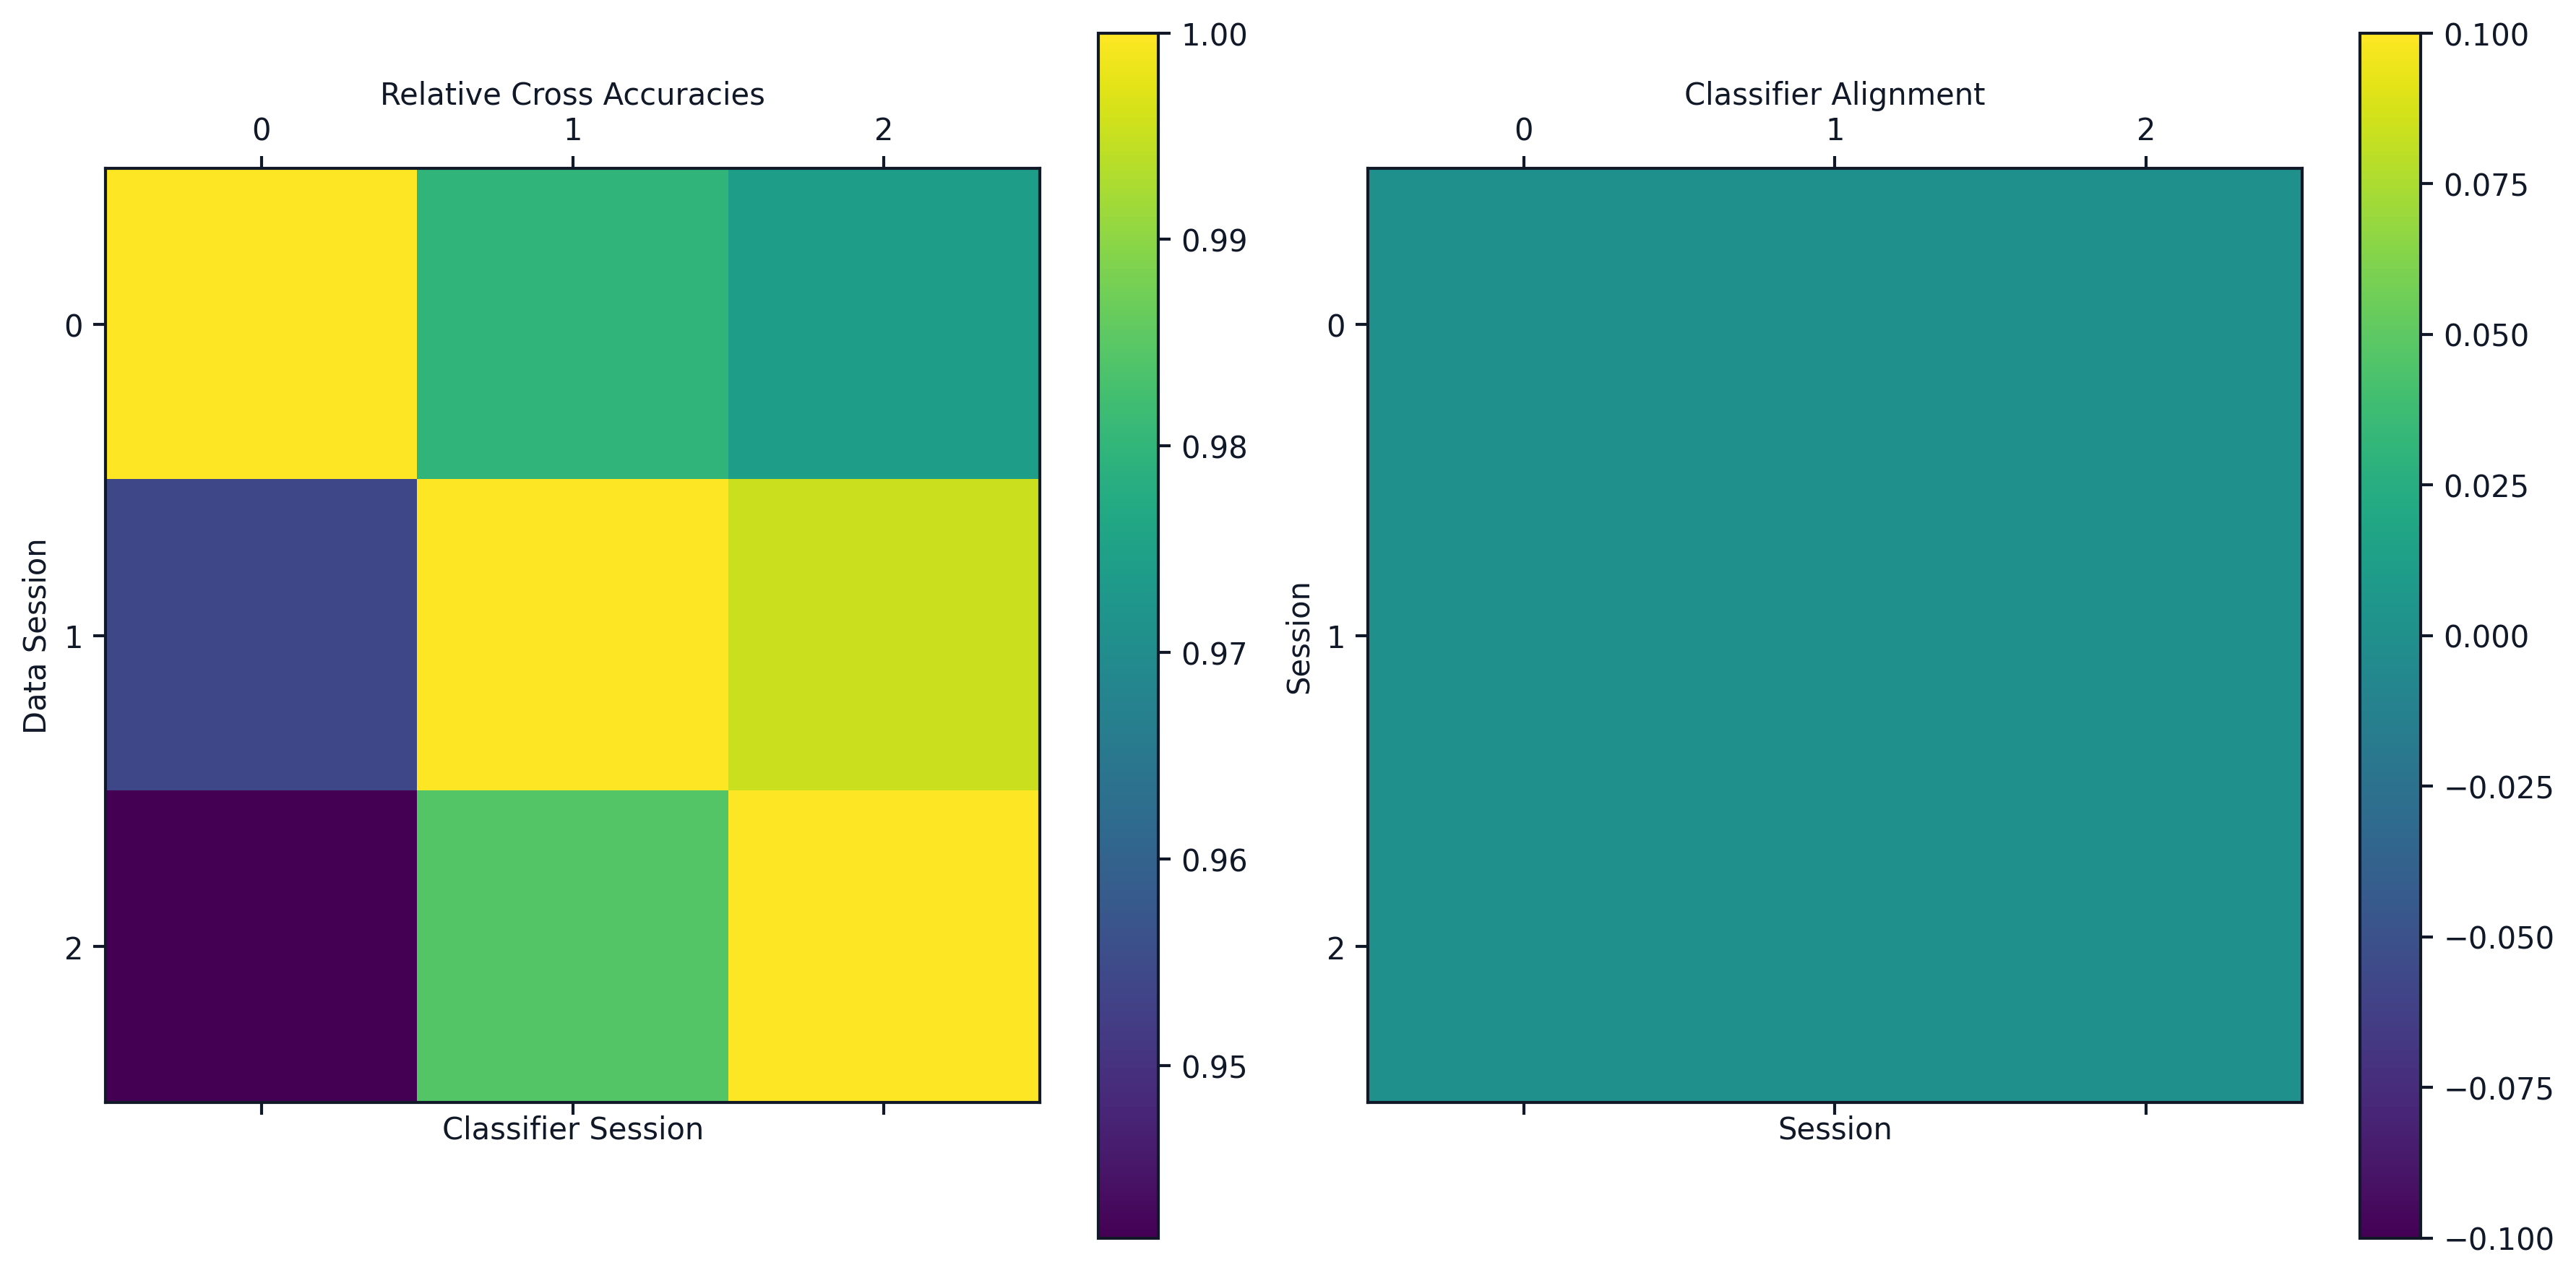

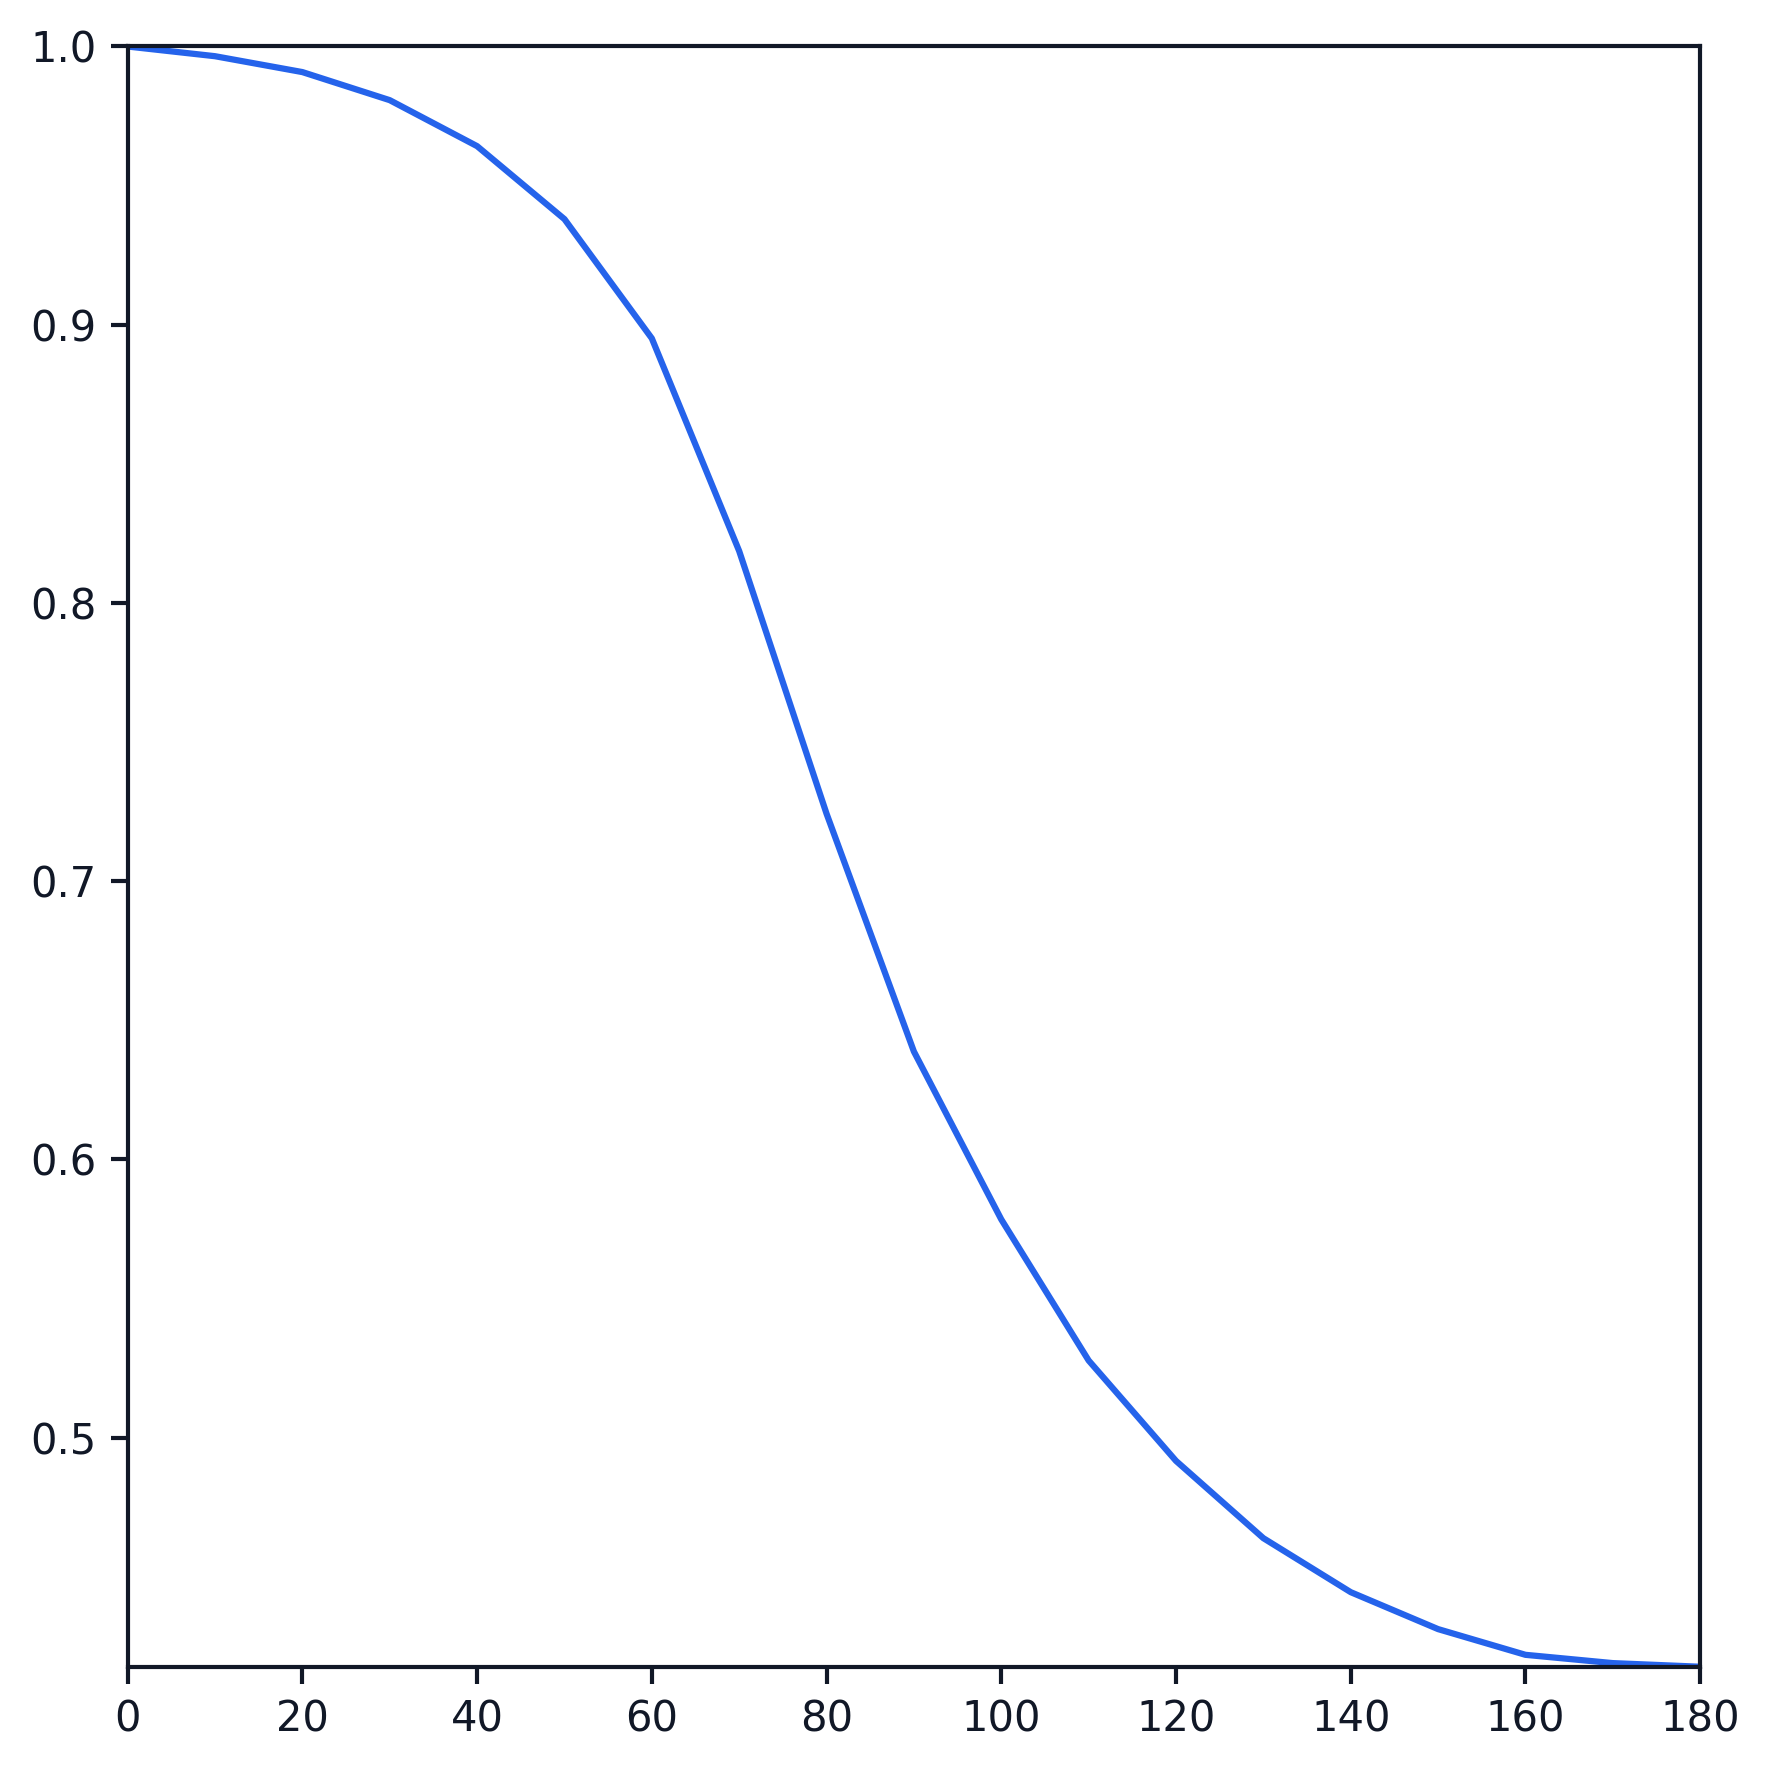

In [35]:
cross_accs_rel_containers = np.zeros((n_containers, n_sessions, n_sessions))
cross_accs_rand_rel_containers = np.zeros((n_containers, n_sessions, n_sessions))
cross_accs_scan_rel_containers = np.zeros((n_containers, n_sessions, n_sessions, n_angles))

for container_idx in range(n_containers):
    for session_idx_d in range(n_sessions): # Classifier index
        cross_accs_rel_containers[container_idx, :, session_idx_d] = (
            cross_accs_containers[container_idx, :, session_idx_d] / 
            cross_accs_containers[container_idx, session_idx_d, session_idx_d]
        )
        cross_accs_rand_rel_containers[container_idx, :, session_idx_d] = (
            cross_accs_rand_containers[container_idx, :, session_idx_d] / 
            cross_accs_containers[container_idx, session_idx_d, session_idx_d]
        )
        cross_accs_scan_rel_containers[container_idx, :, session_idx_d, :] = (
            cross_accs_scan_containers[container_idx, :, session_idx_d, :] / 
            cross_accs_containers[container_idx, session_idx_d, session_idx_d, np.newaxis]
        )


fig, ax = plt.subplots(1, 2, figsize=(12, 6))

acc_plot = ax[0].matshow(np.mean(cross_accs_rel_containers, axis=0))
plt.colorbar(acc_plot, ax=ax[0])

ax[0].set_xlabel('Classifier Session')
ax[0].set_ylabel('Data Session')
ax[0].set_title('Relative Cross Accuracies')

align_plot = ax[1].matshow(np.mean(cross_aligns_containers, axis=0))
plt.colorbar(align_plot, ax=ax[1])

ax[1].set_xlabel('Session')
ax[1].set_ylabel('Session')
ax[1].set_title('Classifier Alignment')

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

avg_cross_acc = np.mean(cross_accs_scan_rel_containers, axis=(0, 1, 2))
# avg_cross_acc = np.mean(cross_accs_scan_rel_containers[:, 0, 0], axis=0)

ax.plot(scan_angles, avg_cross_acc)


Plots data

Mean angle: 57.1 (std: 12.71)
Mean rel cross acc: 0.97 (std: 0.19)
Slope: -0.00 (se: 0.00), r: -0.05 p: 3.56e-01


NameError: ignored

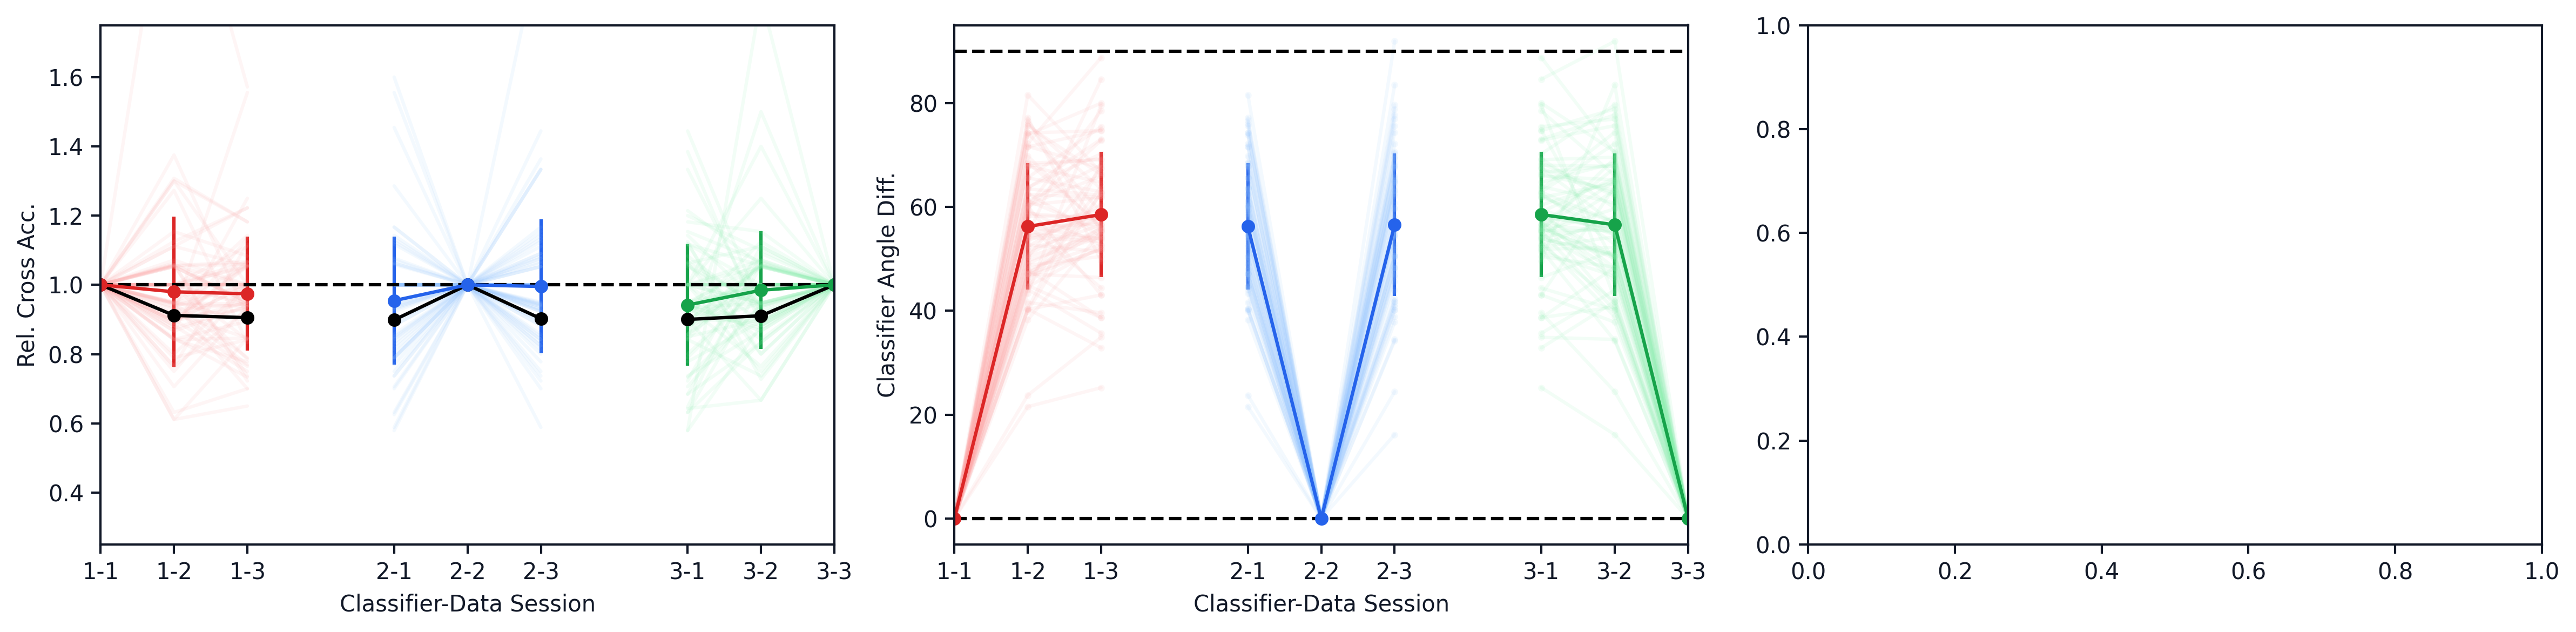

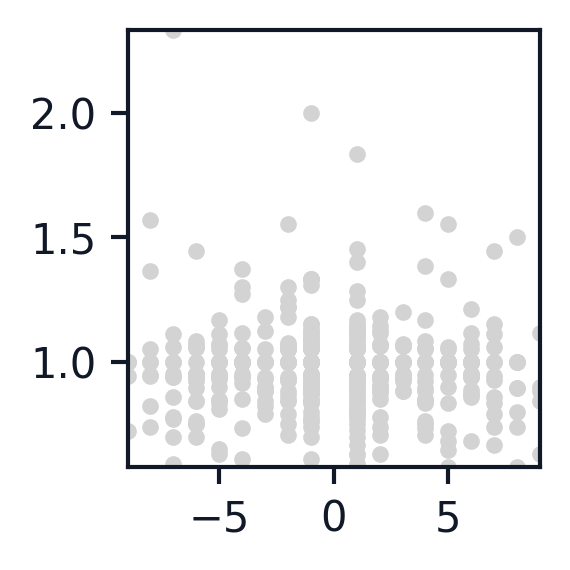

In [36]:
session_locs = [
    [0, 1, 2],
    [4, 5, 6],
    [8, 9, 10],
]
classifier_labels = ['One', 'Two', 'Three']

fig, ax = plt.subplots(1, 3, figsize=(16, 4))

avg_cross_accs_rel = np.mean(cross_accs_rel_containers, axis=0)
std_cross_accs_rel = np.std(cross_accs_rel_containers, axis=0)

avg_cross_accs_rand_rel = np.mean(cross_accs_rand_rel_containers, axis=0)

avg_cross_angles = np.mean(cross_angles_containers, axis=0)
std_cross_angles = np.std(cross_angles_containers, axis=0)

cross_rel_acc_vals = []
cross_angle_vals = []
for session_idx1 in range(n_sessions):
    for session_idx2 in range(n_sessions):
        if session_idx1 != session_idx2:
            cross_angle_vals.extend(cross_angles_containers[:, session_idx1, session_idx2])
            cross_rel_acc_vals.extend(cross_accs_rel_containers[:, session_idx1, session_idx2])

print('Mean angle: {:.1f} (std: {:.2f})'.format(np.mean(cross_angle_vals), np.std(cross_angle_vals)))
print('Mean rel cross acc: {:.2f} (std: {:.2f})'.format(np.mean(cross_rel_acc_vals), np.std(cross_rel_acc_vals)))

for session_idx_c in range(n_sessions): # Classifier index
    for container_idx in range(n_containers):
        ax[0].plot(session_locs[session_idx_c],
                   cross_accs_rel_containers[container_idx, session_idx_c],
                   alpha=0.1, color=c_vals_l[session_idx_c])
        ax[1].plot(session_locs[session_idx_c],
                   cross_angles_containers[container_idx, session_idx_c],
                   marker='.', alpha=0.1, color=c_vals_l[session_idx_c])
    ax[0].errorbar(session_locs[session_idx_c], 
                    avg_cross_accs_rel[session_idx_c],
                    yerr=std_cross_accs_rel[session_idx_c],
                    color=c_vals[session_idx_c],
                    capsize=5.0, marker='o')
    ax[0].plot(session_locs[session_idx_c], 
               avg_cross_accs_rand_rel[session_idx_c],
               color='k', marker='o')
    ax[1].errorbar(session_locs[session_idx_c], 
                    avg_cross_angles[session_idx_c],
                    yerr=std_cross_angles[session_idx_c],
                    color=c_vals[session_idx_c],
                    capsize=5.0, marker='o')

# ax[0].set_ylim([0, 1.1*np.max(cross_accs_rel_containers)])
ax[0].set_ylim([0.25, 1.75])
ax[0].axhline(1.0, color='k', linestyle='dashed')
ax[0].set_ylabel('Rel. Cross Acc.')

ax[1].set_ylim([-5, 95])
ax[1].axhline(0.0, color='k', linestyle='dashed')
ax[1].axhline(90.0, color='k', linestyle='dashed')
ax[1].set_ylabel('Classifier Angle Diff.')

for ax_it in (ax[0], ax[1]):
    ax_it.set_xticks([0, 1, 2, 4, 5, 6, 8, 9, 10])
    ax_it.set_xticklabels(['1-1', '1-2', '1-3', '2-1', '2-2', '2-3', '3-1', '3-2', '3-3'])
    ax_it.set_xlabel('Classifier-Data Session')

# Removes deltat=0 values
deltat_filter = np.logical_and(np.abs(cross_deltats.flatten()) > 0, np.abs(cross_deltats.flatten()) < 10)

fit_X = cross_deltats.flatten()[deltat_filter]
# fit_X = np.abs(cross_deltats.flatten()[deltat_filter])
fit_y = cross_accs_rel_containers.flatten()[deltat_filter]


fig, ax = plt.subplots(1, 1, figsize=(2,2))

ax.scatter(fit_X, fit_y,
               marker='.', color='lightgrey')
reg = linregress(fit_X, fit_y)
print('Slope: {:.2f} (se: {:.2f}), r: {:.2f} p: {:.2e}'.format(
      reg.slope, reg.stderr, reg.rvalue, reg.pvalue))
reg_plot_X = np.linspace(np.min(fit_X), np.max(fit_X), num=50)
reg_plot_y = reg.slope * reg_plot_X + reg.intercept
reg_plot_min_y = ((reg.slope - n_se* reg.stderr) * reg_plot_X + 
                  (reg.intercept - n_se * reg.intercept_stderr))
reg_plot_max_y = ((reg.slope + n_se * reg.stderr) * reg_plot_X + 
                  (reg.intercept + n_se * reg.intercept_stderr))
ax.fill_between(reg_plot_X, reg_plot_min_y, reg_plot_max_y, 
                    color=c_vals[4], alpha=0.3)
ax.plot(reg_plot_X, reg_plot_y, color=c_vals[4])

ax.set_xlabel('$t_{class.}$ - $t_{data}$ (days)')
ax.set_ylabel('Rel. Cross Acc.')
ax.axhline(1.0, color='k', linestyle='dashed', linewidth=0.75)
ax.set_xlim([-9, 9])
ax.set_xticks([-9, 0, 9])
ax.set_ylim([-0, 2])
ax.set_yticks([0, 1, 2])

ax.text(0.5, 0.1, 'a = {:.0e}'.format(reg.slope), 
           horizontalalignment='center', verticalalignment='center', 
           color=c_vals[4], fontsize=8, transform=ax.transAxes)

jetplot.breathe(ax=ax)

fig, ax = plt.subplots(1, 1, figsize=(2,2))

fit_X = np.abs(cross_deltats.flatten()[deltat_filter])
# fit_X = np.abs(cross_deltats.flatten()[deltat_filter])
fit_y = cross_angles_containers.flatten()[deltat_filter]

ax.scatter(fit_X, fit_y,
               marker='.', color='lightgrey')
reg = linregress(fit_X, fit_y)
print('Slope: {:.2f} (se: {:.2f}), r: {:.2f} p: {:.2e}'.format(
      reg.slope, reg.stderr, reg.rvalue, reg.pvalue))
reg_plot_X = np.linspace(np.min(fit_X), np.max(fit_X), num=50)
reg_plot_y = reg.slope * reg_plot_X + reg.intercept
reg_plot_min_y = ((reg.slope - n_se* reg.stderr) * reg_plot_X + 
                  (reg.intercept - n_se * reg.intercept_stderr))
reg_plot_max_y = ((reg.slope + n_se * reg.stderr) * reg_plot_X + 
                  (reg.intercept + n_se * reg.intercept_stderr))
ax.fill_between(reg_plot_X, reg_plot_min_y, reg_plot_max_y, 
                    color=c_vals[7], alpha=0.3)
ax.plot(reg_plot_X, reg_plot_y, color=c_vals[7])

ax.set_xlabel('$\Delta$t (days)')
ax.set_ylabel('$\Delta$SVC Angle')
ax.axhline(90.0, color='k', linestyle='dashed', linewidth=0.75)
ax.set_xlim([0, 9])
ax.set_xticks([0, 3, 6, 9])
ax.set_ylim([10, 110])
ax.set_yticks([10, 30, 50, 70, 90, 110])
ax.set_yticklabels([10, None, 50, None, 90, 110])

ax.text(0.5, 0.9, 'a = {:.0e}'.format(reg.slope), 
           horizontalalignment='center', verticalalignment='center', 
           color=c_vals[7], fontsize=8, transform=ax.transAxes)

jetplot.breathe(ax=ax)


Average angle: 56.55


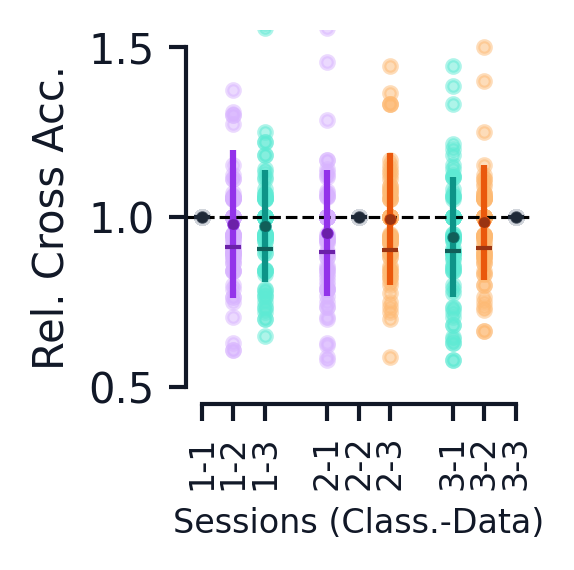

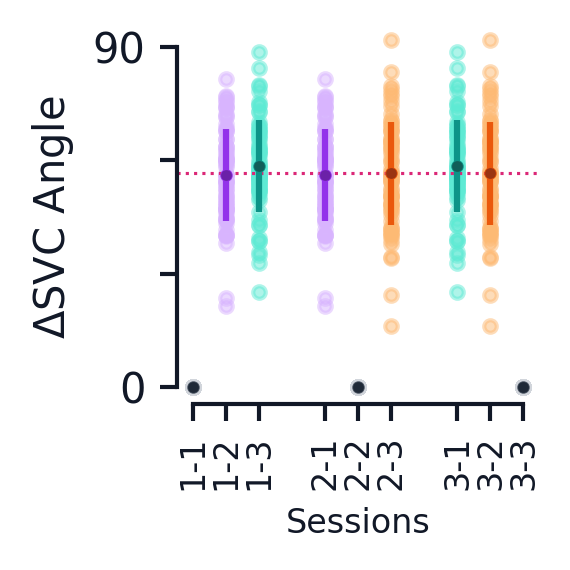

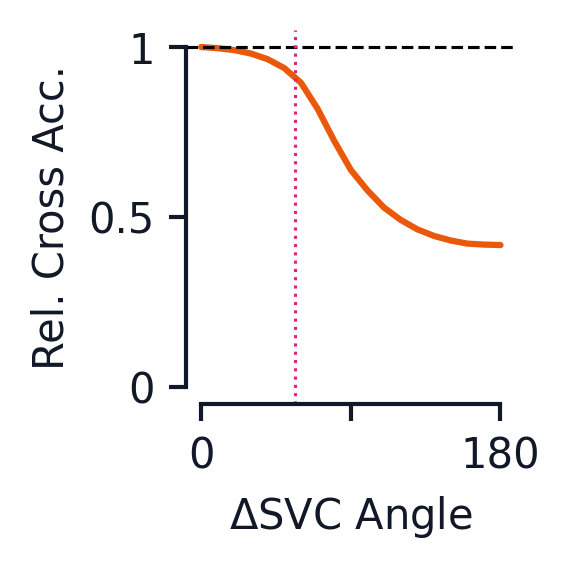

In [37]:
session_locs = [
    [0, 1, 2],
    [4, 5, 6],
    [8, 9, 10],
]
classifier_labels = ['One', 'Two', 'Three']

cross_angle_vals = []
for session_idx1 in range(1, n_sessions):
    for session_idx2 in range(session_idx1+1, n_sessions):
         cross_angle_vals.extend(cross_angles_containers[:, session_idx1, session_idx2])

fig, ax = plt.subplots(1, 1, figsize=(2,2))

avg_cross_accs_rel = np.mean(cross_accs_rel_containers, axis=0)
std_cross_accs_rel = np.std(cross_accs_rel_containers, axis=0)

avg_cross_angles = np.mean(cross_angles_containers, axis=0)
std_cross_angles = np.std(cross_angles_containers, axis=0)

avg_cross_accs_rand_rel = np.mean(cross_accs_rand_rel_containers, axis=0)

session_colors = [
    [6, 3, 5],
    [3, 6, 4],
    [5, 4, 6]
]

for session_idx_c in range(n_sessions): # Classifier index
    for container_idx in range(n_containers):
        for session_idx_d in range(n_sessions):
            ax.scatter(session_locs[session_idx_c][session_idx_d],
                    cross_accs_rel_containers[container_idx, session_idx_c, session_idx_d],
                    alpha=0.5, color=c_vals_l[session_colors[session_idx_c][session_idx_d]],
                    marker='.')
        # ax.plot(session_locs[session_idx_c],
        #             cross_accs_rel_containers[container_idx, session_idx_c],
        #             alpha=0.1, color='lightgrey')

# for session_idx_c in range(n_sessions): # Classifier index
#     ax.errorbar(session_locs[session_idx_c], 
#                     avg_cross_accs_rel[session_idx_c],
#                     yerr=std_cross_accs_rel[session_idx_c],
#                     color=c_vals[session_idx_c],
#                     capsize=5.0, marker='.', zorder=4)
#     ax.scatter(session_locs[session_idx_c], 
#                avg_cross_accs_rel[session_idx_c],
#                color=c_vals_d[session_idx_c], marker='.', s=10, zorder=5)


for session_idx_c in range(n_sessions): # Classifier index
    for session_idx_d in range(n_sessions): # Data index
        ax.errorbar(session_locs[session_idx_c][session_idx_d], 
                        avg_cross_accs_rel[session_idx_c, session_idx_d],
                        yerr=std_cross_accs_rel[session_idx_c, session_idx_d],
                        color=c_vals[session_colors[session_idx_c][session_idx_d]],
                        capsize=5.0, marker='.', zorder=4)
        ax.scatter(session_locs[session_idx_c][session_idx_d], 
                avg_cross_accs_rel[session_idx_c, session_idx_d],
                color=c_vals_d[session_colors[session_idx_c][session_idx_d]], 
                marker='.', s=10, zorder=5)
    
        ax.scatter(session_locs[session_idx_c][session_idx_d], 
               avg_cross_accs_rand_rel[session_idx_c, session_idx_d],
               color=c_vals_d[session_colors[session_idx_c][session_idx_d]],
               marker='_', s=15, zorder=5, linewidth=1.0)

# ax[0].set_ylim([0, 1.1*np.max(cross_accs_rel_containers)])
ax.set_ylim([0.5, 1.5])
ax.set_yticks([0.5, 1.0, 1.5])
# ax.set_yticklabels([0.5, 1.0, None, 2])
ax.axhline(1.0, color='k', linestyle='dashed', linewidth=0.75)
ax.set_ylabel('Rel. Cross Acc.')

ax.set_xticks([0, 1, 2, 4, 5, 6, 8, 9, 10])
ax.xaxis.set_tick_params(rotation=90)
ax.set_xticklabels(['1-1', '1-2', '1-3', '2-1', '2-2', '2-3',  '3-1', '3-2', '3-3',], fontsize=8)
ax.set_xlabel('Sessions (Class.-Data)', fontsize=8)

jetplot.breathe(ax=ax)

fig, ax = plt.subplots(1, 1, figsize=(2,2))

for session_idx_c in range(n_sessions): # Classifier index
    for container_idx in range(n_containers):
        for session_idx_d in range(n_sessions): # Data index
            ax.scatter(session_locs[session_idx_c][session_idx_d],
                   cross_angles_containers[container_idx, session_idx_c, session_idx_d],
                   marker='.', alpha=0.5, 
                   color=c_vals_l[session_colors[session_idx_c][session_idx_d]])
        # ax.plot(session_locs[session_idx_c],
        #         cross_angles_containers[container_idx, session_idx_c],
        #         alpha=0.05, color='lightgrey')
        
for session_idx_c in range(n_sessions): # Classifier index
    for session_idx_d in range(n_sessions): # Data index
        ax.errorbar(session_locs[session_idx_c][session_idx_d], 
                        avg_cross_angles[session_idx_c, session_idx_d],
                        yerr=std_cross_angles[session_idx_c, session_idx_d],
                        color=c_vals[session_colors[session_idx_c][session_idx_d]],
                        capsize=5.0, marker='.', zorder=4)
        ax.scatter(session_locs[session_idx_c][session_idx_d], 
                    avg_cross_angles[session_idx_c, session_idx_d],
                        color=c_vals_d[session_colors[session_idx_c][session_idx_d]],
                        marker='.', s=10, zorder=5)

print('Average angle: {:.2f}'.format(np.mean(cross_angle_vals)))
ax.set_ylim([0, 90])
ax.set_yticks([0, 30, 60, 90])
ax.set_yticklabels([0, None, None, 90])
ax.axhline(np.mean(cross_angle_vals), color=c_vals[7], linestyle='dotted', linewidth=0.75)
# ax.axhline(0.0, color='k', linestyle='dashed')
# ax.axhline(90.0, color='k', linestyle='dashed')
ax.set_ylabel('$\Delta$SVC Angle')


ax.set_xticks([0, 1, 2, 4, 5, 6, 8, 9, 10])
ax.xaxis.set_tick_params(rotation=90)
ax.set_xticklabels(['1-1', '1-2', '1-3', '2-1', '2-2', '2-3',  '3-1', '3-2', '3-3',], fontsize=8)
ax.set_xlabel('Sessions', fontsize=8)

jetplot.breathe(ax=ax)

fig, ax = plt.subplots(1, 1, figsize=(2,2))

avg_cross_acc = np.mean(cross_accs_scan_rel_containers, axis=(0, 1, 2))

ax.plot(scan_angles, avg_cross_acc, color=c_vals[4])

ax.set_xlabel('$\Delta$SVC Angle')
ax.set_xlim([0, 180])
ax.set_xticks([0, 90, 180])
ax.set_xticklabels([0, None, 180])
ax.set_ylabel('Rel. Cross Acc.')
ax.set_ylim([0, 1])
ax.set_yticks([0, 0.5, 1])
ax.set_yticklabels([0, 0.5, 1])
ax.axhline(1.0, color='k', linestyle='dashed', linewidth=0.75)
ax.axvline(np.mean(cross_angle_vals), color=c_vals[7], linestyle='dotted', linewidth=0.75)

jetplot.breathe(ax=ax)

#### SVC Sessions

In [38]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from scipy.stats import linregress

drift_pair_idxs = [(0, 1), (1, 2), (0, 2)]
n_drifts = len(drift_pair_idxs)
n_classes = dff_vals_container[0].shape[1]
n_folds = 5

# Takes accuracies across classes
raw_accs = np.zeros((n_containers, n_drifts, n_classes, n_folds))
null_accs = np.zeros((n_containers, n_sessions, n_classes, n_folds))
short_accs = np.zeros((n_containers, n_sessions, n_classes, n_folds))

for container_idx in range(n_containers):
        
    cell_ids_container = cell_ids_experiments[container_idx*n_sessions:(container_idx+1)*n_sessions]
    dff_vals_container = dff_vals_experiments[container_idx*n_sessions:(container_idx+1)*n_sessions]

    # Find shared IDs
    unique_cell_ids = get_unique_cell_ids(cell_ids_container)
    shared_cell_idxs = get_shared_cell_idxs(unique_cell_ids, verbose=False)
    n_shared = shared_cell_idxs[0].shape[0]
    n_feats = n_shared

    n_pcas = np.min((n_repeats, n_shared))

    X_data_sessions = []
    y_labels_sessions = []

    models_sessions = []

    for drift_idx in range(n_drifts):
        session_idx1 = drift_pair_idxs[drift_idx][0]
        session_idx2 = drift_pair_idxs[drift_idx][1]
        
        for class_idx in range(n_classes):
            # Create the classification data for each class
            X_data = []
            y_labels = []

            # Session 1 (label: 0)
            dff_vals_session1 = dff_vals_container[session_idx1][:, :, shared_cell_idxs[session_idx1]]
            X_data.append(dff_vals_session1[:, class_idx, :])
            y_labels.append(0 * np.ones(
                dff_vals_session1[:, class_idx, :].shape[0], 
                dtype=np.int32
            ))
            # Session 2 (label: 1)
            dff_vals_session2 = dff_vals_container[session_idx2][:, :, shared_cell_idxs[session_idx2]]
            X_data.append(dff_vals_session2[:, class_idx, :])
            y_labels.append(1 * np.ones(
                dff_vals_session2[:, class_idx, :].shape[0], 
                dtype=np.int32
            ))

            X_data = np.concatenate(X_data, axis=0)
            y_labels = np.concatenate(y_labels, axis=0)

            # Shuffle the classification data
            arr_idxs = np.arange(X_data.shape[0])
            np.random.seed(10)
            np.random.shuffle(arr_idxs)
            X_data = X_data[arr_idxs]
            y_labels = y_labels[arr_idxs]

            # k-Fold Cross validation, saving the model details at each step
            kf = KFold(n_splits=n_folds)

            for fold_idx, (train_index, test_index) in enumerate(kf.split(X_data)):
                X_train, X_test = X_data[train_index], X_data[test_index]
                y_train, y_test = y_labels[train_index], y_labels[test_index]

                # SVC classifier
                clf = svm.LinearSVC(class_weight='balanced', fit_intercept=True, max_iter=100000)

                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                raw_accs[container_idx, drift_idx, class_idx, fold_idx] = np.sum(y_pred == y_test) / y_test.shape[0]

    # Now does the null cases (even/odd or first/second from a single session)
    for session_idx in range(n_sessions):
        for class_idx in range(n_classes):
            ##### Even/Odd #####
            X_data = []
            y_labels = []
            
            n_samples = dff_vals_container[session_idx].shape[0]
            n_samples_2 = int(np.floor(n_samples/2))

            # Even (label: 0)
            dff_vals_even = dff_vals_container[session_idx][0:n_samples_2*2:2, :, shared_cell_idxs[session_idx]]
            X_data.append(dff_vals_even[:, class_idx, :])
            y_labels.append(0 * np.ones(
                dff_vals_even[:, class_idx, :].shape[0], 
                dtype=np.int32
            ))
            # Odd (label: 1)
            dff_vals_odd = dff_vals_container[session_idx][1:n_samples_2*2:2, :, shared_cell_idxs[session_idx]]
            X_data.append(dff_vals_odd[:, class_idx, :])
            y_labels.append(1 * np.ones(
                dff_vals_odd[:, class_idx, :].shape[0], 
                dtype=np.int32
            ))

            X_data = np.concatenate(X_data, axis=0)
            y_labels = np.concatenate(y_labels, axis=0)

            # Shuffle the classification data
            arr_idxs = np.arange(X_data.shape[0])
            np.random.seed(10)
            np.random.shuffle(arr_idxs)
            X_data = X_data[arr_idxs]
            y_labels = y_labels[arr_idxs]

            # k-Fold Cross validation, saving the model details at each step
            kf = KFold(n_splits=n_folds)

            for fold_idx, (train_index, test_index) in enumerate(kf.split(X_data)):
                X_train, X_test = X_data[train_index], X_data[test_index]
                y_train, y_test = y_labels[train_index], y_labels[test_index]

                # SVC classifier
                clf = svm.LinearSVC(class_weight='balanced', fit_intercept=True, max_iter=100000)

                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                null_accs[container_idx, session_idx, class_idx, fold_idx] = np.sum(y_pred == y_test) / y_test.shape[0]

            ##### First/Second half #####
            X_data = []
            y_labels = []
            
            n_samples = dff_vals_container[session_idx].shape[0]
            n_samples_2 = int(np.floor(n_samples/2))

            # First (label: 0)
            dff_vals_first = dff_vals_container[session_idx][0:n_samples_2, :, shared_cell_idxs[session_idx]]
            X_data.append(dff_vals_first[:, class_idx, :])
            y_labels.append(0 * np.ones(
                dff_vals_first[:, class_idx, :].shape[0], 
                dtype=np.int32
            ))
            # Second (label: 1)
            dff_vals_second = dff_vals_container[session_idx][n_samples_2:2*n_samples_2*2, :, shared_cell_idxs[session_idx]]
            X_data.append(dff_vals_second[:, class_idx, :])
            y_labels.append(1 * np.ones(
                dff_vals_second[:, class_idx, :].shape[0], 
                dtype=np.int32
            ))

            X_data = np.concatenate(X_data, axis=0)
            y_labels = np.concatenate(y_labels, axis=0)

            # Shuffle the classification data
            arr_idxs = np.arange(X_data.shape[0])
            np.random.seed(10)
            np.random.shuffle(arr_idxs)
            X_data = X_data[arr_idxs]
            y_labels = y_labels[arr_idxs]

            # k-Fold Cross validation, saving the model details at each step
            kf = KFold(n_splits=n_folds)

            for fold_idx, (train_index, test_index) in enumerate(kf.split(X_data)):
                X_train, X_test = X_data[train_index], X_data[test_index]
                y_train, y_test = y_labels[train_index], y_labels[test_index]

                # SVC classifier
                clf = svm.LinearSVC(class_weight='balanced', fit_intercept=True, max_iter=100000)

                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                short_accs[container_idx, session_idx, class_idx, fold_idx] = np.sum(y_pred == y_test) / y_test.shape[0]

print('Mean Acc: {:.2f} (std: {:.3f})'.format(raw_accs.mean(), raw_accs.std()))
print('Null Acc: {:.2f} (std: {:.3f})'.format(null_accs.mean(), null_accs.std()))
print('Short Acc: {:.2f} (std: {:.3f})'.format(short_accs.mean(), short_accs.std()))

Mean Acc: 0.68 (std: 0.251)
Null Acc: 0.45 (std: 0.346)
Short Acc: 0.51 (std: 0.351)


In [40]:
# These all average over classes and folds.
raw_accs_avg = np.mean(raw_accs, axis=(2,3))
null_accs_avg = np.mean(null_accs, axis=(2,3))
short_accs_avg = np.mean(short_accs, axis=(2,3))

print('Mean Acc: {:.2f} (std: {:.3f})'.format(raw_accs_avg.mean(), raw_accs_avg.std()))
print('Null Acc: {:.2f} (std: {:.3f})'.format(null_accs_avg.mean(), null_accs_avg.std()))
print('Short Acc: {:.2f} (std: {:.3f})'.format(short_accs_avg.mean(), short_accs_avg.std()))

print('Drift evolution with time difference:')
for drift_idx in range(n_drifts):
    session_idx1 = drift_pair_idxs[drift_idx][0]
    session_idx2 = drift_pair_idxs[drift_idx][1]
    print('  Session {} to {}: Mean Acc: {:.2f} (std: {:.3f})'.format(
        session_idx1, session_idx2, raw_accs_avg[:, drift_idx].mean(),
        raw_accs_avg[:, drift_idx].std()
    ))

Mean Acc: 0.68 (std: 0.084)
Null Acc: 0.45 (std: 0.052)
Short Acc: 0.51 (std: 0.066)
Drift evolution with time difference:
  Session 0 to 1: Mean Acc: 0.68 (std: 0.088)
  Session 1 to 2: Mean Acc: 0.68 (std: 0.079)
  Session 0 to 2: Mean Acc: 0.69 (std: 0.086)


### Save Stuff

In [ ]:
def save_model_comparison(path):
    """ For comparison with ANNs"""

    save_the_file = True

    if os.path.exists(path):
        print('File already exists at:', path)
        override = input('Override? (Y/N):')
        if override == 'Y':
            save_the_file = True
        else:
            save_the_file = False

    if save_the_file:
        with open(path, 'wb') as save_file:
            # # Angle fit
            # pickle.dump((reg2.slope, reg2.stderr), save_file, protocol=pickle.HIGHEST_PROTOCOL)
            # pickle.dump((reg2.rvalue, reg2_rstd), save_file, protocol=pickle.HIGHEST_PROTOCOL)
            # # Variance flow fit
            # pickle.dump((reg3.slope, reg3.stderr), save_file, protocol=pickle.HIGHEST_PROTOCOL)
            # pickle.dump((reg3.rvalue, reg3_rstd), save_file, protocol=pickle.HIGHEST_PROTOCOL)
            # # Magntidue fit
            # pickle.dump((reg4.intercept, reg4.intercept_stderr), save_file, protocol=pickle.HIGHEST_PROTOCOL)
            # pickle.dump((reg4.slope, reg4.stderr), save_file, protocol=pickle.HIGHEST_PROTOCOL)
            # # Var fit
            # pickle.dump((reg6.intercept, reg6.intercept_stderr), save_file, protocol=pickle.HIGHEST_PROTOCOL)
            # pickle.dump((reg6.slope, reg6.stderr), save_file, protocol=pickle.HIGHEST_PROTOCOL)

            # Angle fit
            pickle.dump((np.mean(reg2_slopes), np.std(reg2_slopes)), save_file, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump((np.mean(reg2_rvalues), np.std(reg2_rvalues)), save_file, protocol=pickle.HIGHEST_PROTOCOL)
            # Variance flow fit
            pickle.dump((np.mean(reg3_slopes), np.std(reg3_slopes)), save_file, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump((np.mean(reg3_rvalues), np.std(reg3_rvalues)), save_file, protocol=pickle.HIGHEST_PROTOCOL)
            # Magntidue fit
            pickle.dump((np.mean(reg4_intercepts), np.std(reg4_intercepts)), save_file, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump((np.mean(reg4_slopes), np.std(reg4_slopes)), save_file, protocol=pickle.HIGHEST_PROTOCOL)
            # Var fit
            pickle.dump((np.mean(reg6_intercepts), np.std(reg6_intercepts)), save_file, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump((np.mean(reg6_slopes), np.std(reg6_slopes)), save_file, protocol=pickle.HIGHEST_PROTOCOL)
            # SVC
            pickle.dump((np.mean(cross_rel_acc_vals), np.std(cross_rel_acc_vals)), save_file, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump((np.mean(cross_angle_vals), np.std(cross_angle_vals)), save_file, protocol=pickle.HIGHEST_PROTOCOL)

    else:
        print('Data Not Saved')


In [ ]:
# Save data for matching to ANNs
path = '/content/drive/MyDrive/neuro_research/visual_change_drift/summary_data/passive_finalmatch_data.pickle'
save_model_comparison(path)

### Final Plotting Stuff

In [16]:
!python -m pip install git+https://github.com/nirum/jetplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/nirum/jetplot to /tmp/pip-req-build-qr7cn34w
  Running command git clone -q https://github.com/nirum/jetplot /tmp/pip-req-build-qr7cn34w
  Created wheel for jetplot: filename=jetplot-0.5.0-py3-none-any.whl size=15083 sha256=eda45eac0fa500918c2c2f890a284dda0d7f67e27c31165cfee4f66176dbf8f2
  Stored in directory: /tmp/pip-ephem-wheel-cache-_5rbpqd7/wheels/d6/cc/1a/e4ac81d12b484cdd54e3c32836bee518ea4f7d35d56e6038a8
Successfully built jetplot


In [17]:
import jetplot

print('Jetpack version:', jetplot.__version__)

Jetpack version: 0.5.0


In [18]:
from matplotlib import rcParams

rcParams.update({
    'lines.linewidth': 1.5,
    'lines.linestyle': '-',
    'lines.marker': None,
    'lines.markeredgewidth': 0.,
    'lines.markersize': 6.,
    'lines.antialiased': True,
    'lines.solid_joinstyle': 'round',
    'lines.solid_capstyle': 'round',

    'patch.linewidth': 1.,
    'patch.facecolor': '#cccccc',
    'patch.edgecolor': 'none',
    'patch.antialiased': True,

    'font.size': 10,
    'text.usetex': False,
    'mathtext.default': 'regular',

    'axes.linewidth': 1.0,
    'axes.grid': False,
    'axes.titlesize': 10,
    'axes.labelsize': 10,
    'axes.labelweight': 'normal',
    'axes.axisbelow': True,
    'axes.formatter.use_mathtext': False,
    'axes.xmargin': 0.,
    'axes.ymargin': 0.,
    'polaraxes.grid': True,

    'xtick.direction': 'out',
    'xtick.labelsize': 10.,
    'xtick.major.size': 4.,
    'xtick.minor.size': 2.,
    'xtick.major.width': 1.,
    'xtick.minor.width': 1.,

    'ytick.direction': 'out',
    'ytick.labelsize': 10.,
    'ytick.major.size': 4.,
    'ytick.minor.size': 2.,
    'ytick.major.width': 1.,
    'ytick.minor.width': 1.,

    'grid.linestyle': 'dotted',
    'grid.alpha': 0.5,
    'grid.linewidth': 1.0,

    'legend.frameon': False,
    'legend.fancybox': True,
    'legend.fontsize': 10.,
    'legend.loc': 'best',

    'figure.figsize': (5, 3),
    'figure.dpi': 300,
    'figure.autolayout': True,

    'image.cmap': 'viridis',
    'image.interpolation': None,
    'image.aspect': 'equal',

    'savefig.format': 'pdf',
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,
    'pdf.fonttype': 42,
})

In [21]:
c_vals = [jetplot.colors.red[6], jetplot.colors.blue[6], jetplot.colors.green[6], jetplot.colors.purple[6],
         jetplot.colors.orange[6], jetplot.colors.teal[6], jetplot.colors.gray[6], jetplot.colors.pink[6], jetplot.colors.yellow[6],
         jetplot.colors.pink[6]]

         
c_vals_l = [jetplot.colors.red[3], jetplot.colors.blue[3], jetplot.colors.green[3], jetplot.colors.purple[3],
                jetplot.colors.orange[3], jetplot.colors.teal[3], jetplot.colors.gray[3], jetplot.colors.pink[3],
            jetplot.colors.yellow[3], jetplot.colors.pink[3]]
c_vals_d = [jetplot.colors.red[8], jetplot.colors.blue[8], jetplot.colors.green[8], jetplot.colors.purple[8],
                jetplot.colors.orange[8], jetplot.colors.teal[8], jetplot.colors.gray[8], jetplot.colors.pink[8]]

ordered_map = list(jetplot.colors.cmap_colors('RdYlGn', 7))
ordered_map[3] = jetplot.colors.yellow[3]

In [19]:
c_vals = ['#e53e3e', '#3182ce', '#38a169', '#805ad5','#dd6b20', '#319795', '#718096', '#d53f8c', '#d69e2e',]
c_vals_l = ['#feb2b2', '#90cdf4', '#9ae6b4', '#d6bcfa', '#fbd38d', '#81e6d9', '#e2e8f0', '#fbb6ce', '#faf089',]
c_vals_d = ['#9b2c2c', '#2c5282', '#27674', '#553c9a', '#9c4221', '#285e61', '#2d3748', '#97266d', '#975a16',]